This script uses LDA to calculate decoding accuracy of neuron populations recorded from different sites. Decoding accuracy is calculated while controlling for number of trials and population size used from each recording. It performs the following steps:

1. Loads relevant data
    - Preprocessed spike times
    - ECoG decoding accuracy
2. Calcualtes decoding accuracy for each recording set under different parameters:
    - Event alignment (peripheral target onset, go cue, movement onset)
    - Number of trials
    - Unit adding
3. Calculates statistics between recordings as a function of ECoG decoding accuracy
4. Plot results and save figures


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import aopy
import os
import pandas as pds
from db import dbfunctions as db
from ipywidgets import interactive, widgets
import scipy
import h5py
from tqdm.auto import tqdm 
import seaborn as sn
import sklearn
from sklearn.decomposition import PCA, FactorAnalysis
from itertools import compress
import multiprocessing as mp
import time
import math
from scipy.fft import fft
import glob
from datetime import date

In [2]:
aopy.utils.get_memory_available_gb()

877

# Set parameters

In [3]:
save_figs = False
base_save_dir = "/media/moor-data/results/Ryan/neuropixel_targeting/"
np_preproc_data_folder = 'np_analysis_preproc_data'
ecog_dec_acc_file_name = 'ecog_decoding_maps/npinsert_ecog_decoding_all'

subject = 'affi'
align_events = ['TARGET ONSET', 'GO CUE', 'MOVEMENT ONSET']
trelevant1_time = -.1
trelevant2_time = 0.4

In [4]:
# Decoding calculation parameters
tbefore = 0.5 # For linear regression analysis
tafter = 1    # For linear regression analysis
nlda_lags = 1
niter_match = 50
ntrial_bin_size = 96
nfolds = 5

# Visualization parameters
colors = sn.color_palette(n_colors=9)
if subject == 'beignet':
    recording_brain_areas={'M1': [30, 56, 47, 40, 121, 48, 120, 98], 'PM':[11, 9, 18, 22, 10, 45]}
elif subject == 'affi':
    recording_brain_areas={'M1': [98, 74, 72, 107], 'PM':[10,19,29,31, 33, 44, 55, 46, 70, 72, 55,58,33,10]}

plt.rcParams['xtick.labelsize']=28
plt.rcParams['ytick.labelsize']=28
plt.rcParams['axes.labelsize']=32
plt.rcParams['axes.titlesize'] = 32
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.right']=False
plt.rcParams['lines.linewidth']=8


In [5]:
def xval_lda(data, labels, sample_rate, lags=3, nfolds=5, smooth_timeseries=False, smooth_width=150, return_weights=False, return_confusion_matrix=False):
    '''
        
    Args:
        data (ntime, nch, ntrials)
        labels (ntrials)
        sample_rate
        lags (int)
        nfolds (int)
        smooth_timeseries
        smooth_width (int): [ms]
        
    Returns:
        decoding_accuracy()
    '''
    ntime, nch, ntrials = data.shape 
    nlabels = len(np.unique(labels))
    
    if smooth_timeseries:
        smoothed_data = smooth_timeseries_gaus(data, sample_rate, smooth_width)
    else:
        smoothed_data = data

    # Perform n-fold xval LDA at each time point 
    decoding_accuracy = np.zeros((ntime-lags, nfolds))*np.nan
    weights = np.zeros((ntime-lags, nlabels, (1+lags)*nch, nfolds))*np.nan # (ntime, ntargets, nfeatures, nfolds)
    confusion_matrix = np.zeros((ntime-lags, nlabels, nlabels, nfolds))*np.nan
    nwind = smoothed_data.shape[0] - lags
    for iwind in range(nwind):
        lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
        # lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
        end_wind = iwind+lags+1
        
        # If there are nans at this timestep, return nan in all places
        if np.sum(np.isnan(smoothed_data[iwind:end_wind,:,:])):
            if nfolds < 2:
                decoding_accuracy[iwind] = np.nan
                weights[iwind,:,:] = np.nan
                confusion_matrix[iwind,:,:] = np.nan
            else:
                decoding_accuracy[iwind,:] = np.nan
                if return_weights:
                    weights[iwind,:,:,:] = np.nan
                if return_confusion_matrix:
                    confusion_matrix[iwind,:,:,:] = np.nan

        else:
            # If not cross validated
            if nfolds < 2:
                lda.fit(np.vstack(smoothed_data[iwind:end_wind,:,:]).T - np.mean(np.vstack(smoothed_data[iwind:end_wind,:,:]).T, axis=0), labels)
                decoding_accuracy[iwind] = lda.score(np.vstack(smoothed_data[iwind:end_wind,:,:]).T - np.mean(np.vstack(smoothed_data[iwind:end_wind,:,:]).T, axis=0), labels)
                predicted_labels = lda.predict(np.vstack(smoothed_data[iwind:end_wind,:,:]).T - np.mean(np.vstack(smoothed_data[iwind:end_wind,:,:]).T, axis=0))
                confusion_matrix[iwind,:,:,0] = sklearn.metrics.confusion_matrix(labels, predicted_labels)
                                    
                                    
            # if cross validated: 
            else:
                kf = sklearn.model_selection.KFold(n_splits=nfolds,shuffle=True,random_state=None)
                for ifold, (train_idx, test_idx) in enumerate(kf.split(np.vstack(smoothed_data[iwind:end_wind,:,:]).T)):
                    lda.fit(np.vstack(smoothed_data[iwind:end_wind,:,train_idx]).T - np.mean(np.vstack(smoothed_data[iwind:end_wind,:,train_idx]).T, axis=0), labels[train_idx])
                    decoding_accuracy[iwind, ifold] = lda.score(np.vstack(smoothed_data[iwind:end_wind,:,test_idx]).T - np.mean(np.vstack(smoothed_data[iwind:end_wind,:,test_idx]).T, axis=0), labels[test_idx])
                    predicted_labels = lda.predict(np.vstack(smoothed_data[iwind:end_wind,:,test_idx]).T - np.mean(np.vstack(smoothed_data[iwind:end_wind,:,test_idx]).T, axis=0))
                    if return_weights:
                        weights[iwind,:,:,ifold] = lda.coef_
                    if return_confusion_matrix:
                        confusion_matrix[iwind,:,:,ifold] = sklearn.metrics.confusion_matrix(labels[test_idx], predicted_labels, normalize='true')
            
    if return_weights & return_confusion_matrix:
        return decoding_accuracy, weights, confusion_matrix
    elif return_weights: 
        return decoding_accuracy, weights
    elif return_confusion_matrix:
        return decoding_accuracy, confusion_matrix
    else:
        return decoding_accuracy

def lda_single(data, labels, nfolds):
    '''
    data (ntime, nch, ntrials)
    '''
    kf = sklearn.model_selection.KFold(n_splits=nfolds,shuffle=True,random_state=1)
    lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
    data_out = np.zeros(nfolds)*np.nan 
    for ifold, (train_idx, test_idx) in enumerate(kf.split(np.vstack(data[:,:,:]).T)):            
        lda.fit(np.vstack(data[:,:,train_idx]).T - np.mean(np.vstack(data[:,:,train_idx]).T, axis=0), labels[train_idx])
        data_out[ifold] = lda.score(np.vstack(data[:,:,test_idx]).T - np.mean(np.vstack(data[:,:,test_idx]).T, axis=0), labels[test_idx])
    return data_out

def xval_lda_parallel(data, labels, sample_rate, lags=3, nfolds=5, smooth_timeseries=False, smooth_width=50):
    '''
    ** Needs to be able to handle just one lag **
    
    Args:
        data (ntime, nch, ntrials)
        labels (ntrials)
        sample_rate
        lags (int)
        nfolds (int)
        smooth_timeseries
        smooth_width (int): [ms]
        
    Returns:
        decoding_accuracy()
    '''
    ntime, nch, ntrials = data.shape 
    nlabels = len(np.unique(labels))
    
    if smooth_timeseries:
        smoothed_data = smooth_timeseries_gaus(data, sample_rate, smooth_width)
    else:
        smoothed_data = data
    
    # Perform n-fold xval LDA at each time point 
    decoding_accuracy = np.zeros((ntime-lags, nfolds))*np.nan
    nwind = smoothed_data.shape[0] - lags
    input_data = [smoothed_data[iwind:(iwind+lags),:,:] for iwind in range(nwind)]
    # print(len(input_data), len([labels for ii in range(nwind)]), itertools.repeat(nfolds))
    input_args = zip(input_data, [labels for ii in range(nwind)], itertools.repeat(nfolds))
    decoding_accuracy = lda_single(data, labels, nfolds)
    with Pool() as pool:
        decoding_accuracy = np.array(pool.starmap(lda_single, input_args))
    return decoding_accuracy

def smooth_timeseries_gaus(timeseries_data, samplerate, width, nstd=3, conv_mode='same'):
    '''
    Smooths across 2 
    
    Args:
        timeseries_data (ntime, ...)
        samplerate (int): Sample rate of timeseries
        width (float): Width of the gaussian in time [ms] from -nstd to +nstd
        nstd (float/int): Number of standard deviations to be used in the filter calculation.
        conv_mode (str): Sets the size of the output. Takes eithe 'full', 'valid', or 'same'. See scipy.signal.convolve for full documentationat
        
    Returns: 
        smoothed_timeseries
    '''
    sample_std = (width/nstd)*(samplerate/(1000)) # Convert from s to ms
    x = np.arange(-sample_std*nstd, nstd*sample_std+1)
    gaus_filter = (1/(sample_std*np.sqrt(2*np.pi)))*np.exp(-(x**2)/(2*sample_std**2))
    return np.apply_along_axis(scipy.signal.convolve, 0, timeseries_data, gaus_filter, mode=conv_mode, method='direct')

def get_pseudopopulation_raster(unit_df, raster_list, stable_unit_idx_list, target_idx_list, nunits):
    '''
    Args:
        unit_df [dataframe]: must have info on rec number, unitidx
        raster_list [list of (ntime, ntrials, nch) arrays]:
        stable_unit_idx_list [list of arrays]
        target_idx_list [list of (ntrial) arrays]
        nunits [int]

    Returns:
        (ntime, ntrial, nunits) pseudopopulation raster array
        (ntrial) target labels
    '''
    # Randomly select nunits from unit_df
    units_to_use = np.sort(np.random.choice(np.arange(len(unit_df)), size=nunits, replace=False))

    # Get the raster info from each of these units and compile
    ntime, ntrials, _ = raster_list[0].shape
    raster_output = np.zeros((ntime, ntrials, nunits))*np.nan
    # print(units_to_use)
    for iunit, unit in enumerate(units_to_use):
        rec_number = unit_df['rec_number'][unit]
        unit_idx = unit_df['unit_idx'][unit]
        # print(iunit, unit, rec_number, unit_idx)
        sorted_target_label_idx = np.argsort(target_idx_list[rec_number]) # Sort target labels for each unit
        raster_output[:,:,iunit] = raster_list[rec_number][:,sorted_target_label_idx,unit_idx]
        
    return raster_output, target_idx_list[rec_number][sorted_target_label_idx]
# test = get_pseudopopulation_raster(random_units[0].reset_index(), fr_zscore[align_event]['align_spikes_zscore'], stable_unit_idx, target_idx_list, nunits=13)

# Load relevant data

## Load ECoG decoding accuracy

In [6]:
def load_hdf_group(data_dir, hdf_filename, group="/"):
    '''
    Loads any datasets from the given hdf group into a dictionary. Also will
    recursively load other groups if any exist under the given group

    Args:
        data_dir (str): folder where data is located
        hdf_filename (str): name of hdf file
        group (str): name of the group to load
    
    Returns:
        dict: all the datasets contained in the given group
    '''
    full_file_name = os.path.join(data_dir, hdf_filename)
    hdf = h5py.File(full_file_name, 'r')
    if group not in hdf:
        raise ValueError('No such group in file {}'.format(hdf_filename))

    # Recursively load groups until datasets are reached
    def _load_hdf_group(hdf):
        keys = hdf.keys()
        data = dict()
        for k in keys:
            if isinstance(hdf[k], h5py.Group):
                data[k] = _load_hdf_group(hdf[k])
            else:
                k_, v = _load_hdf_dataset(hdf[k], k)
                data[k_] = v
        return data

    data = _load_hdf_group(hdf[group])
    hdf.close()
    return data

def _load_hdf_dataset(dataset, name):
    '''
    Internal function for loading hdf datasets. Decodes json and unicode data automatically.

    Args:
        dataset (hdf object): dataset to load
        name (str): name of the dataset

    Returns:
        tuple: Tuple containing:
            | **name (str):** name of the dataset (might be modified)
            | **data (object):** loaded data
    '''
    data = dataset[()]
    if '_json' in name:
        import json
        name = name.replace('_json', '')
        data = json.loads(data)
    try:
        data = data.decode('utf-8')
    except:
        pass
    return name, data

In [74]:
# print(os.path.join(base_save_dir, ecog_dec_acc_file_name_all))
ecog_dec_acc_file_name_all = 'ecog_decoding_maps/npinsert_ecog_decoding'
ecog_dec_acc_file_name_x = 'ecog_decoding_maps/npinsert_ecog_decoding_x'
ecog_dec_acc_file_name_y = 'ecog_decoding_maps/npinsert_ecog_decoding_y'
ecog_dec_acc = load_hdf_group(base_save_dir, ecog_dec_acc_file_name_all)
ecog_dec_acc_x = load_hdf_group(base_save_dir, ecog_dec_acc_file_name_x)
ecog_dec_acc_y = load_hdf_group(base_save_dir, ecog_dec_acc_file_name_y)
day_colors = ecog_dec_acc[subject]['day_colors']

In [8]:
# print(ecog_dec_acc[subject].keys())
# ecog_dec_acc[subject]['rec_locations'] = np.array([[-1.99999496,  3.99998992],
#        [ 1.99999496,  3.99998992],
#        [ 1.99999496, -1.99999496],
#        [-3.99998992,  1.99999496],
#        [ 0.99999748, -0.99999748],
#        [ 2.99999244,  2.99999244],
#        [-1.99999496,  1.99999496],
#        [-1.99999496,  3.99998992],
#        [-3.99998992,  1.99999496],
#        [ 5.31998858, -0.75999837],
#        [-1.51999674,  4.55999021],
#        [-4.55999021,  3.03999347],
#        [ 4.55999021, -1.51999674],
#        [ 3.79999184,  0.75999837],
#        [ 0.        ,  3.03999347]])

## Load preprocessed neuropixel data

In [8]:
start = time.time()
aopy.utils.release_memory_limit()
df, rasters, preproc_metadata = aopy.data.base.pkl_read(f"{subject}_np_preprocessed", os.path.join(base_save_dir, np_preproc_data_folder))
print(f"{np.round((time.time()-start)/60)} min to load preprocessed data")
nrecs = preproc_metadata['nrecs']
recording_site = preproc_metadata['recording_sites'] # will be the same for all align events
implants = ['NPinsert72' if preproc_metadata['implant'][irec] == 'NP_Insert72' else 'NPinsert137' for irec in range(len(preproc_metadata['implant']))] #Rename because name in bmi3d is slightly different (TODO)
dates = np.unique(df['date'])
ntargets = len(np.unique(df['target_idx']))

7.0 min to load preprocessed data


In [9]:
ch_ypos, rasters_sbp, _ = aopy.data.base.pkl_read(f"{subject}_np_preprocessed_sbp", os.path.join(base_save_dir, np_preproc_data_folder)) # Load sbp
# start = time.time()
# _, rasters['lfp'], _ = aopy.data.base.pkl_read(f"{subject}_np_preprocessed_lfp", os.path.join(base_save_dir, np_preproc_data_folder))
# print(f"{np.round((time.time()-start)/60)} min to load preprocessed LFP data")

In [14]:
start = time.time()
_, rasters['lfp'], _ = aopy.data.base.pkl_read(f"{subject}_np_preprocessed_lfp", os.path.join(base_save_dir, np_preproc_data_folder))
print(f"{np.round((time.time()-start)/60)} min to load preprocessed LFP data")

UnpicklingError: pickle data was truncated

In [10]:
random_units, column_units, depth_units, depth_group_info_by_site, pseudopopulation_metadata, unit_df = aopy.data.base.pkl_read(f"{subject}_np_psuedopopulations",  os.path.join(base_save_dir, np_preproc_data_folder))

In [11]:
trelevant1 = np.where(preproc_metadata['trial_time_axis']>trelevant1_time)[0][0]
trelevant2 = np.where(preproc_metadata['trial_time_axis']>trelevant2_time)[0][0]

## Identify stable units

In [166]:
qc_results, _ = aopy.data.base.pkl_read(f"{subject}_QCunits", os.path.join(base_save_dir, np_preproc_data_folder))
stable_unit_labels = [qc_results['final_good_unit_labels'][irec] for irec in range(nrecs)]
stable_unit_idx = [qc_results['final_good_unit_idx'][irec] for irec in range(nrecs)]
nstable_unit = np.array([len(qc_results['final_good_unit_idx'][irec]) for irec in range(nrecs)])
neuron_pos = [qc_results['position'][irec] for irec in range(nrecs)]
if subject == 'affi':
    stable_unit_labels = [qc_results['manual_good_unit_labels'][irec] for irec in range(nrecs)]
    stable_unit_idx = [qc_results['manual_good_unit_idx'][irec] for irec in range(nrecs)]
    nstable_unit = np.array([len(qc_results['manual_good_unit_idx'][irec]) for irec in range(nrecs)])
    neuron_pos = [qc_results['manual_position'][irec] for irec in range(nrecs)]

## Zscore FR

In [15]:
def compile_raster(data, trigger_idx, tbefore, tafter, samplerate, unit_data=False, smooth=False):
    '''
    args:
        data(ntrial-list of data dict): Each element of the list is a dictionary with each entry being a (nt) array of binned spikes
        trigger_idx (ntrial):
        tbefore (float):
        tafter (float):
        unit_data (bool): If data is labelled units
        samplerate (int): neural data samplerate
    '''
    
    idx_before = int(np.ceil(tbefore*samplerate))
    idx_after = int(np.ceil(tafter*samplerate))    
    ntrials = len(data)
    ntime = int(idx_before+idx_after)
    
    if unit_data:
        unique_unit_labels = np.sort(np.unique([list(itrial_data.keys()) for itrial_data in data]).astype(int))
        nunits = len(unique_unit_labels)
        raster_array = np.zeros((ntime, ntrials, nunits))*np.nan
    else:
        unique_unit_labels = None
        raster_array = np.zeros((ntime, ntrials, data[0].shape[1]))*np.nan
    
    for itrial in range(ntrials):
        start_idx = int(trigger_idx[itrial]-idx_before)
        end_idx = int(trigger_idx[itrial]+idx_after)
        raster_idx_start = int(0)
        raster_idx_end = ntime
        
        if unit_data:
            trial_len = len(data[itrial][str(unique_unit_labels[0])])
        else:
            trial_len = data[itrial].shape[0]
        
        # Contingency if start_idx < 0 or end_idx is longer than the data segment
        if start_idx < 0:
            print('start_idx < 0')
            raster_idx_start = -start_idx
            start_idx = 0
            
        if end_idx > trial_len:
            print('end_idx < trial_len')
            if unit_data:
                trial_len = len(data[itrial][str(unique_unit_labels[itrial])])
            else:
                trial_len = len(data[itrial][itrial])
            raster_idx_end = int(trial_len - trigger_idx[itrial] + idx_before)
            end_idx = trial_len

        if unit_data:
            for iunit, unit_label in enumerate(unique_unit_labels):
                if smooth:
                    # [smooth_timeseries_gaus(data_segs[itr], 1/spike_bin_width_mc, width=smooth_width, nstd=smooth_nstd) for itr in range(len(data_segs))]
                    raster_array[raster_idx_start:raster_idx_end,itrial,iunit] = smooth_timeseries_gaus(data[itrial][str(unit_label)], 1/spike_bin_width_mc, width=smooth_width, nstd=smooth_nstd)[start_idx:end_idx]
                else:
                    raster_array[raster_idx_start:raster_idx_end,itrial,iunit] = data[itrial][str(unit_label)][start_idx:end_idx]
                    
        else:
            raster_array[raster_idx_start:raster_idx_end,itrial,:] = data[itrial][start_idx:end_idx,:]
            
    return raster_array, unique_unit_labels

In [16]:
# Load all LFP power saved data
lfp_power_save_dir = f"/media/moor-data/postprocessed/{subject}/neuropixel_lfp_power"
aopy.utils.release_memory_limit()
lfp_power_segs = []
lfp_ch_ypos = []
for idate, date in enumerate(tqdm(dates)):
    nte_id = np.unique(df['te_id'][df['date']==date])
    for ite_id, te_id_temp in enumerate(nte_id):
        lfp_power_segs_teid, lfp_power_metadata = aopy.data.base.pkl_read(f'lfp_power_te{te_id_temp}', lfp_power_save_dir)
        lfp_power_segs.extend(lfp_power_segs_teid)
        print(f"Loading LFP power from te{te_id_temp}")
    lfp_ch_ypos.append(lfp_power_metadata['ch_ypos'])

lfp_df = pds.DataFrame() # Don't save lfp power segments in DF because it'll take up too much memory
lfp_df['lfp_power_segs'] = lfp_power_segs

  0%|          | 0/26 [00:00<?, ?it/s]

Loading LFP power from te11983
Loading LFP power from te12383
Loading LFP power from te12386
Loading LFP power from te17536
Loading LFP power from te17542
Loading LFP power from te17543
Loading LFP power from te17553
Loading LFP power from te17556
Loading LFP power from te17560
Loading LFP power from te17568
Loading LFP power from te17571
Loading LFP power from te17574
Loading LFP power from te18110
Loading LFP power from te18128
Loading LFP power from te18136
Loading LFP power from te18166
Loading LFP power from te18170
Loading LFP power from te18189
Loading LFP power from te18192
Loading LFP power from te18197
Loading LFP power from te18199
Loading LFP power from te18205
Loading LFP power from te18223
Loading LFP power from te18229
Loading LFP power from te18236
Loading LFP power from te18272
Loading LFP power from te18274
Loading LFP power from te18291


In [17]:
# Compile LFP rasters for future analysis
tbefore_mc = preproc_metadata['tbefore']
tafter_mc = preproc_metadata['tafter']
spike_bin_width_mc = preproc_metadata['spike_bin_width']
nbands = len(lfp_power_metadata['frequency_band'])
time_offset = lfp_power_metadata['time_axis'][0][0] + 0.5/2
time_idx_offset = int(np.round(time_offset*lfp_power_metadata['samplerate']))
rasters_lfp = {}
for iband in range(nbands):
    rasters_lfp[iband] = {}
    rasters_lfp[iband]['TARGET ONSET'], rasters_lfp[iband]['GO CUE'], rasters_lfp[iband]['MOVEMENT ONSET'] = [], [], []
    for idate, date in enumerate(tqdm(dates)):
        band_specific_power = [list(lfp_df['lfp_power_segs'][df['date']==date])[itr][iband,:,:] for itr in range(len(list(lfp_df['lfp_power_segs'][df['date']==date])))]
        rasters_lfp[iband]['TARGET ONSET'].append(compile_raster(band_specific_power, np.array(df['delay_start_neural_idx'][df['date']==date])-time_idx_offset, tbefore=tbefore_mc, tafter=tafter_mc, samplerate=(1/spike_bin_width_mc), unit_data=False)[0])
        rasters_lfp[iband]['GO CUE'].append(compile_raster(band_specific_power, np.array(df['go_cue_neural_idx'][df['date']==date])-time_idx_offset, tbefore=tbefore_mc, tafter=tafter_mc, samplerate=(1/spike_bin_width_mc), unit_data=False)[0])
        rasters_lfp[iband]['MOVEMENT ONSET'].append(compile_raster(band_specific_power, np.array(df['mov_onset_neural_idx'][df['date']==date])-time_idx_offset, tbefore=tbefore_mc, tafter=tafter_mc, samplerate=(1/spike_bin_width_mc), unit_data=False)[0])

  0%|          | 0/26 [00:00<?, ?it/s]

start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_

  0%|          | 0/26 [00:00<?, ?it/s]

start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_

  0%|          | 0/26 [00:00<?, ?it/s]

start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_

  0%|          | 0/26 [00:00<?, ?it/s]

start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_

  0%|          | 0/26 [00:00<?, ?it/s]

start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_idx < 0
start_

In [18]:
save_dir = "/media/moor-data/results/Ryan/neuropixel_targeting/np_analysis_preproc_data"
aopy.data.base.pkl_write(f"{subject}_np_preprocessed_lfp", (df, rasters_lfp, preproc_metadata), save_dir)


In [21]:
# Zscore the activity of each neuron (even unstable) across all trials
fr_zscore = {}
for align_event in tqdm(align_events):
    temp_spike_data = [rasters['neural'][align_event][irec][:,np.array(df['good_trial'][df['date']==dates[irec]]),:] for irec in range(nrecs)] # Shape (ntime, ntrial, nunit)
    fr_zscore[align_event] = {'align_spikes_zscore': [], 'align_sbp_zscore': []}
    [fr_zscore[align_event]['align_spikes_zscore'].append((temp_spike_data[irec]-np.mean(temp_spike_data[irec], axis=(0,1)))/np.std(temp_spike_data[irec], axis=(0,1))) for irec in range(nrecs)]
    
    temp_sbp_data = [rasters_sbp[align_event][irec][:,np.array(df['good_trial'][df['date']==dates[irec]]),:] if ~np.isnan(rasters_sbp[align_event][irec]).any() else np.nan for irec in range(nrecs)] # Shape (ntime, ntrial, nunit)
    [fr_zscore[align_event]['align_sbp_zscore'].append((temp_sbp_data[irec]-np.mean(temp_sbp_data[irec], axis=(0,1)))/np.std(temp_sbp_data[irec], axis=(0,1))) if ~np.isnan(temp_sbp_data[irec]).any() else fr_zscore[align_event]['align_sbp_zscore'].append(np.nan) for irec in range(nrecs)]

# Zscore lfp power for each frequency band
nbands = len(list(rasters['lfp'].keys()))
for align_event in tqdm(align_events):
    fr_zscore[align_event]['align_lfp_zscore'] = {}
    for iband in range(len(list(rasters['lfp'].keys()))):
        fr_zscore[align_event]['align_lfp_zscore'][iband] = []

        temp_lfp_data = [rasters['lfp'][iband][align_event][irec][:,np.array(df['good_trial'][df['date']==dates[irec]]),:] for irec in range(nrecs)] # Shape (ntime, ntrial, nunit)
        [fr_zscore[align_event]['align_lfp_zscore'][iband].append((temp_lfp_data[irec]-np.nanmean(temp_lfp_data[irec], axis=(0,1)))/np.nanstd(temp_lfp_data[irec], axis=(0,1))) for irec in range(nrecs)]
        

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_2516753/1247918159.py:6: RuntimeWarning: invalid value encountered in divide
  [fr_zscore[align_event]['align_spikes_zscore'].append((temp_spike_data[irec]-np.mean(temp_spike_data[irec], axis=(0,1)))/np.std(temp_spike_data[irec], axis=(0,1))) for irec in range(nrecs)]


  0%|          | 0/3 [00:00<?, ?it/s]

# Calculate LDA decoding accuracy

In [24]:
ntime = len(preproc_metadata['trial_time_axis'])
lda_results = {}
for align_event in align_events:
    lda_results[align_event] = {}
    lda_results[align_event]['sbp'] = {}
    lda_results[align_event]['lfp'] = {}
    for iband in range(nbands):
        lda_results[align_event]['lfp'][iband] = {}

## All good units in all recordings

In [16]:
# Organize data input to xval_lda
for align_event in tqdm(align_events):
    all_neural_data_list = []
    for irec in range(nrecs):
        temp_target_labels = np.array(df['target_idx'][df['good_trial']*(df['date']==dates[irec])])
        sorted_target_label_mask = np.argsort(temp_target_labels)
        all_neural_data_list.append(fr_zscore[align_event]['align_spikes_zscore'][irec][:,sorted_target_label_mask,:][:,:,stable_unit_idx[irec]])
    input_data = np.swapaxes(np.mean(np.concatenate(all_neural_data_list, axis=2)[trelevant1:trelevant2,:,:], axis=0)[None,:,:], 1, 2)
    lda_results[align_event]['all_units_score'], lda_results[align_event]['all_units_weight'] = xval_lda(input_data, temp_target_labels[sorted_target_label_mask], 1/preproc_metadata['spike_bin_width'], lags=0, smooth_timeseries=False, return_weights=True, nfolds=5)

  0%|          | 0/3 [00:00<?, ?it/s]

In [84]:
# Unit adding spiking
max_units = 300
temp = np.append(np.arange(100,max_units,10), max_units)
groups_of_nunits_all_recs = np.concatenate((np.arange(2, 100, 2), temp))
# groups_of_nunits_all_recs = [10,200, 256]
nrandom_iterations = 100
# nrandom_iterations = pseudopopulation_metadata['nrandom_groups']
target_idx_list = [np.array(df['target_idx'][df['good_trial']*(df['date']==dates[irec])]) for irec in range(nrecs)] 
ntime = len(preproc_metadata['trial_time_axis'])

# for align_event in align_events:
align_event = align_events[-1]
lda_results[align_event]['unit_adding'] = {}
lda_results[align_event]['unit_adding']['scores_event'] = []
for igroup in tqdm(range(len(groups_of_nunits_all_recs))):
    temp_scores = np.zeros((nfolds, nrandom_iterations))*np.nan
    # temp_weights = np.zeros((ntime, ntargets, nfolds, nrandom_iterations))*np.nan
    for iiter in range(nrandom_iterations):
        pseudopop_raster, target_labels = get_pseudopopulation_raster(unit_df, fr_zscore[align_event]['align_spikes_zscore'], stable_unit_idx, target_idx_list, nunits=groups_of_nunits_all_recs[igroup])
        input_data = np.mean(pseudopop_raster[trelevant1:trelevant2,:,:], axis=0).reshape(1,pseudopop_raster.shape[1], pseudopop_raster.shape[2])
        a, b = xval_lda(np.swapaxes(input_data, 1,2), target_labels, 1/preproc_metadata['spike_bin_width'], lags=0, smooth_timeseries=False, return_weights=True)
        temp_scores[:,iiter] = a

    lda_results[align_event]['unit_adding']['scores_event'].append(np.mean(temp_scores,axis=0))

  0%|          | 0/70 [00:00<?, ?it/s]

In [18]:
 # Single channel decoding for spikes
for align_event in align_events:
    lda_results[align_event]['single_ch_decoding'] = []
    for irec in tqdm(range(nrecs)):
        nunits = len(stable_unit_idx[irec])
        temp_single_ch_decoding = np.zeros((nunits,nfolds))*np.nan
        for ich, unitid in enumerate(stable_unit_idx[irec]):
            temp_target_labels = np.array(df['target_idx'][df['good_trial']*(df['date']==dates[irec])])
            input_data = np.mean(fr_zscore[align_event]['align_spikes_zscore'][irec][trelevant1:trelevant2,:,:], axis=0)[:,unitid][None,None,:]
            score, _ = xval_lda(input_data, temp_target_labels, 1/preproc_metadata['spike_bin_width'], lags=0, smooth_timeseries=True, return_weights=True, nfolds=nfolds)
            temp_single_ch_decoding[ich,:] = score
        lda_results[align_event]['single_ch_decoding'].append(temp_single_ch_decoding)

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

## All good units in each recording

In [475]:
ntest_trials = fr_zscore[align_event]['align_spikes_zscore'][0].shape[1]
for align_event in align_events:
    lda_results[align_event]['dec_unit_weight_rank'] = []
    lda_results[align_event]['scores'] = []
    lda_results[align_event]['weights'] = []
    for irec in tqdm(range(nrecs)):
        try:
            units_to_use = stable_unit_idx[irec]
            temp_target_labels = np.array(df['target_idx'][df['good_trial']*(df['date']==dates[irec])])
            input_data = np.swapaxes(np.mean(fr_zscore[align_event]['align_spikes_zscore'][irec][:,:ntest_trials,units_to_use][trelevant1:trelevant2,:,:], axis=0)[None,:,:], 1,2)
            score, weights = xval_lda(input_data, temp_target_labels, 1/preproc_metadata['spike_bin_width'], lags=0, smooth_timeseries=False, return_weights=True)
            max_tidx = np.argmax(np.mean(score, axis=1))
            unit_rank = np.flip(np.argsort((np.sum(np.abs(np.mean(weights, axis=3)[max_tidx,:,:]), axis=0))))
            lda_results[align_event]['scores'].append(score)
            lda_results[align_event]['weights'].append(weights)
            lda_results[align_event]['dec_unit_weight_rank'].append((np.sum(np.abs(np.mean(weights, axis=3)[max_tidx,:,:]), axis=0))[unit_rank])
        except:
            print(f'Error in recording {irec}, site: {recording_site[irec]}')
            lda_results[align_event]['scores'].append([])
            lda_results[align_event]['weights'].append([])
            lda_results[align_event]['dec_unit_weight_rank'].append([])
            continue

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

## Neuron number matched

In [19]:
# nunits_to_use = np.min([len(stable_unit_idx[irec]) for irec in range(nrecs)])
nunits_to_use = 5
# bad_targets = [1,3,5,7]
bad_targets = [2,4,6,8]
bad_targets =[]
# nunits_to_use = 
for align_event in tqdm(align_events):
    ntime = len(preproc_metadata['trial_time_axis'])
    lda_results[align_event]['neural_space'] = []
    lda_results[align_event]['confusion_matrix'] = []
    for irec in tqdm(range(nrecs)):
        if len(stable_unit_idx[irec]) > 0:
            temp_target_labels = np.array(df['target_idx'][df['good_trial']*(df['date']==dates[irec])])
            good_trial_mask = np.logical_not(np.isin(temp_target_labels,bad_targets))
            temp_lda_neural = np.zeros(( niter_match))*np.nan
            temp_conf_mat = np.zeros((niter_match, len(np.unique(temp_target_labels))-len(bad_targets), len(np.unique(temp_target_labels))-len(bad_targets)))*np.nan
            for ii in range(niter_match):
                if len(stable_unit_idx[irec]) < nunits_to_use:
                    unit_idx_temp = stable_unit_idx[irec]
                else:
                    unit_idx_temp = np.random.choice(stable_unit_idx[irec], size=nunits_to_use, replace=False)
                input_data = np.swapaxes(np.mean(fr_zscore[align_event]['align_spikes_zscore'][irec][:,:,unit_idx_temp][trelevant1:trelevant2,:,:], axis=0)[None,:,:], 1,2) # (ntime, nunits, ntrials)11111
                # input_data = np.swapaxes(fr_zscore[align_event]['align_spikes_zscore'][irec][:,:,unit_idx_temp][trelevant1:trelevant2,:,:], 1,2)
                temp_da, temp_cm = xval_lda(input_data[:,:,good_trial_mask], temp_target_labels[good_trial_mask], 1/preproc_metadata['spike_bin_width'], lags=0, smooth_timeseries=False, return_confusion_matrix=True, nfolds=nfolds)
                temp_lda_neural[ii] = np.mean(temp_da)
                temp_conf_mat[ii,:,:] = np.mean(np.squeeze(temp_cm), axis=2)

            lda_results[align_event]['neural_space'].append(temp_lda_neural)
            lda_results[align_event]['confusion_matrix'].append(temp_conf_mat)
        else:
            print(f"Not enough units in recording {irec}, site {recording_site[irec]}")
            lda_results[align_event]['neural_space'].append([])
            lda_results[align_event]['confusion_matrix'].append([])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

## Pseudopopulations

In [167]:
nunits_to_use = pseudopopulation_metadata['nrandom_units']   
target_idx_list = [np.array(df['target_idx'][df['good_trial']*(df['date']==dates[irec])]) for irec in range(nrecs)] 
for align_event in align_events:
    lda_results[align_event]['pseudopopulations'] = {}

### Random

In [187]:
# Use only a single time window to compute decoding accuracy
for align_event in align_events:
    lda_results[align_event]['pseudopopulations']['random_scores_event'] = []
    lda_results[align_event]['pseudopopulations']['random_weights_event'] = []
    for igroup in tqdm(range(len(random_units))):
        pseudopop_raster, target_labels = get_pseudopopulation_raster(random_units[igroup].reset_index(), fr_zscore[align_event]['align_spikes_zscore'], stable_unit_idx, target_idx_list, nunits=pseudopopulation_metadata['nrandom_units'])
        input_data = np.swapaxes(np.mean(pseudopop_raster[trelevant1:trelevant2,:,:], axis=0).reshape(1,pseudopop_raster.shape[1], pseudopop_raster.shape[2]), 1, 2)
        temp_scores, temp_weights = xval_lda(input_data, target_labels, 1/preproc_metadata['spike_bin_width'], lags=0, smooth_timeseries=False, return_weights=True, nfolds=nfolds)
        lda_results[align_event]['pseudopopulations']['random_scores_event'].append(temp_scores)
        lda_results[align_event]['pseudopopulations']['random_weights_event'].append(temp_weights)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

### Column

In [386]:
# print(column_units[1])

In [168]:
# Use only a single time window to compute decoding accuracy
print(pseudopopulation_metadata['nrandom_groups'])
# bad_targets = [1,3,5,7]
bad_targets = []
# for align_event in tqdm(align_events):
align_event = align_events[-1]
lda_results[align_event]['pseudopopulations']['column_scores_event'] = []
lda_results[align_event]['pseudopopulations']['column_weights_event'] = []
for igroup in range(len(column_units)):
    try:
        temp_scores = np.zeros((nfolds, pseudopopulation_metadata['nrandom_groups']))*np.nan
        temp_weights = np.zeros((ntargets-len(bad_targets), pseudopopulation_metadata['nrandom_units'],  nfolds, pseudopopulation_metadata['nrandom_groups']))*np.nan
        for iiter in range(pseudopopulation_metadata['nrandom_groups']):
            pseudopop_raster, target_labels = get_pseudopopulation_raster(column_units[igroup].reset_index(), fr_zscore[align_event]['align_spikes_zscore'], stable_unit_idx, target_idx_list, nunits=pseudopopulation_metadata['nrandom_units'])
            good_trial_mask = np.logical_not(np.isin(target_labels,bad_targets))

            input_data = np.mean(pseudopop_raster[trelevant1:trelevant2,:,:], axis=0).reshape(1,pseudopop_raster.shape[1], pseudopop_raster.shape[2])
            a, b = xval_lda(np.swapaxes(input_data, 1,2)[:,:,good_trial_mask], target_labels[good_trial_mask], 1/preproc_metadata['spike_bin_width'], lags=0, smooth_timeseries=False, return_weights=True, nfolds=nfolds)
            temp_scores[:,iiter] = a
            temp_weights[:,:,:,iiter] = b

        lda_results[align_event]['pseudopopulations']['column_scores_event'].append(np.mean(temp_scores,axis=0))
        lda_results[align_event]['pseudopopulations']['column_weights_event'].append(np.mean(temp_weights,axis=2))

    except:
        temp_site = column_units[igroup]['rec_site'][0]
        print(f'Exception: Not enough units in site:{temp_site}')
        lda_results[align_event]['pseudopopulations']['column_scores_event'].append([])
        lda_results[align_event]['pseudopopulations']['column_weights_event'].append([])
        continue

1000
Exception: Not enough units in site:29
Exception: Not enough units in site:33
Exception: Not enough units in site:58
Exception: Not enough units in site:46
Exception: Not enough units in site:71
Exception: Not enough units in site:107


In [176]:
# By column split between superficial and deep units
print(pseudopopulation_metadata['nrandom_groups'])
superficial_depth_range = (-300, 1200)
deep_depth_range = (1200, 4000)
# for align_event in tqdm(align_events):
nunits_2_use = 5
align_event = align_events[-1]
lda_results[align_event]['pseudopopulations']['column_scores_superficial'] = []
lda_results[align_event]['pseudopopulations']['column_weights_superficial'] = []
lda_results[align_event]['pseudopopulations']['column_scores_deep'] = []
lda_results[align_event]['pseudopopulations']['column_weights_deep'] = []
for igroup in tqdm(range(len(column_units))):
    superficial_unit_df = column_units[igroup].loc[(column_units[igroup]['rel_depth'] > superficial_depth_range[0]) & (column_units[igroup]['rel_depth'] < superficial_depth_range[1]),:].reset_index()
    deep_unit_df = column_units[igroup].loc[(column_units[igroup]['rel_depth'] > deep_depth_range[0]) & (column_units[igroup]['rel_depth'] < deep_depth_range[1]),:].reset_index()
    
    if len(superficial_unit_df) >= nunits_2_use:
        temp_scores = np.zeros((nfolds, pseudopopulation_metadata['nrandom_groups']))*np.nan
        temp_weights = np.zeros((ntargets,  nunits_2_use,  nfolds, pseudopopulation_metadata['nrandom_groups']))*np.nan
        for iiter in range(pseudopopulation_metadata['nrandom_groups']):
            pseudopop_raster, target_labels = get_pseudopopulation_raster(superficial_unit_df, fr_zscore[align_event]['align_spikes_zscore'], stable_unit_idx, target_idx_list, nunits=nunits_2_use)
            input_data = np.mean(pseudopop_raster[trelevant1:trelevant2,:,:], axis=0).reshape(1,pseudopop_raster.shape[1], pseudopop_raster.shape[2])
            a, b = xval_lda(np.swapaxes(input_data, 1,2), target_labels, 1/preproc_metadata['spike_bin_width'], lags=0, smooth_timeseries=False, return_weights=True, nfolds=nfolds)
            temp_scores[:,iiter] = a
            temp_weights[:,:,:,iiter] = b

        lda_results[align_event]['pseudopopulations']['column_scores_superficial'].append(np.mean(temp_scores,axis=0))
        lda_results[align_event]['pseudopopulations']['column_weights_superficial'].append(np.mean(temp_weights,axis=2))

    else:
        print(f'Not enough superficial units. Group {igroup}')
        lda_results[align_event]['pseudopopulations']['column_scores_superficial'].append([])
        lda_results[align_event]['pseudopopulations']['column_weights_superficial'].append([])


    if len(deep_unit_df) >= nunits_2_use:
        temp_scores = np.zeros((nfolds, pseudopopulation_metadata['nrandom_groups']))*np.nan
        temp_weights = np.zeros((ntargets,  nunits_2_use,  nfolds, pseudopopulation_metadata['nrandom_groups']))*np.nan
        for iiter in range(pseudopopulation_metadata['nrandom_groups']):
            pseudopop_raster, target_labels = get_pseudopopulation_raster(deep_unit_df, fr_zscore[align_event]['align_spikes_zscore'], stable_unit_idx, target_idx_list, nunits=nunits_2_use)
            input_data = np.mean(pseudopop_raster[trelevant1:trelevant2,:,:], axis=0).reshape(1,pseudopop_raster.shape[1], pseudopop_raster.shape[2])
            a, b = xval_lda(np.swapaxes(input_data, 1,2), target_labels, 1/preproc_metadata['spike_bin_width'], lags=0, smooth_timeseries=False, return_weights=True, nfolds=nfolds)
            temp_scores[:,iiter] = a
            temp_weights[:,:,:,iiter] = b

        lda_results[align_event]['pseudopopulations']['column_scores_deep'].append(np.mean(temp_scores,axis=0))
        lda_results[align_event]['pseudopopulations']['column_weights_deep'].append(np.mean(temp_weights,axis=2))

    else:
        print(f'Not enough deep units. Group {igroup}')
        lda_results[align_event]['pseudopopulations']['column_scores_deep'].append([])
        lda_results[align_event]['pseudopopulations']['column_weights_deep'].append([])


1000


  0%|          | 0/19 [00:00<?, ?it/s]

Not enough superficial units. Group 0
Not enough deep units. Group 0
Not enough superficial units. Group 2
Not enough deep units. Group 2
Not enough deep units. Group 3
Not enough superficial units. Group 4
Not enough deep units. Group 4
Not enough deep units. Group 6
Not enough superficial units. Group 7
Not enough deep units. Group 7
Not enough deep units. Group 8
Not enough superficial units. Group 10
Not enough deep units. Group 10
Not enough superficial units. Group 11
Not enough deep units. Group 11
Not enough superficial units. Group 13
Not enough deep units. Group 13
Not enough superficial units. Group 14
Not enough deep units. Group 14
Not enough superficial units. Group 18


### Depth

In [181]:
# ndepthunits = pseudopopulation_metadata['nrandom_units'] (ntime, ntargets, nfeatures, nfolds)
ndepthunits = 5
ntime = len(preproc_metadata['trial_time_axis'])
for align_event in align_events:
    lda_results[align_event]['pseudopopulations']['depth_scores_event'] = []
    lda_results[align_event]['pseudopopulations']['depth_weights_event'] = []
    for igroup in tqdm(range(len(depth_units))):
        temp_scores = np.zeros((nfolds, pseudopopulation_metadata['nrandom_groups']))*np.nan
        temp_weights = np.zeros((ntargets, ndepthunits,  nfolds, pseudopopulation_metadata['nrandom_groups']))*np.nan
        for iiter in range(pseudopopulation_metadata['nrandom_groups']):
            pseudopop_raster, target_labels = get_pseudopopulation_raster(depth_units[igroup].reset_index(), fr_zscore[align_event]['align_spikes_zscore'], stable_unit_idx, target_idx_list, nunits=ndepthunits)
            input_data = np.swapaxes(np.mean(pseudopop_raster[trelevant1:trelevant2,:,:], axis=0).reshape(1,pseudopop_raster.shape[1], pseudopop_raster.shape[2]), 1, 2)
            a, b = xval_lda(input_data, target_labels, 1/preproc_metadata['spike_bin_width'], lags=0, smooth_timeseries=False, return_weights=True, nfolds=nfolds)
            temp_scores[:,iiter] = a
            temp_weights[:,:,:,iiter] = b
        
        lda_results[align_event]['pseudopopulations']['depth_scores_event'].append(np.mean(temp_scores,axis=0))
        lda_results[align_event]['pseudopopulations']['depth_weights_event'].append(np.mean(temp_weights,axis=2))


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [182]:
niterations = pseudopopulation_metadata['nrandom_groups']
# niterations = 50
ntime = len(preproc_metadata['trial_time_axis'])
target_idx_list = [np.array(df['target_idx'][df['good_trial']*(df['date']==dates[irec])]) for irec in range(nrecs)] 
# for align_event in align_events:
align_event = align_events[-1]
lda_results[align_event]['pseudopopulations']['depth_scores_by_site_event'] = {}
lda_results[align_event]['pseudopopulations']['depth_weights_by_site_event'] = {}
for isite, site in enumerate(tqdm(list(depth_group_info_by_site.keys()))):
    lda_results[align_event]['pseudopopulations']['depth_scores_by_site_event'][site] = []
    lda_results[align_event]['pseudopopulations']['depth_weights_by_site_event'][site] = []
    for igroup in range(len(depth_group_info_by_site[site])):
        temp_scores = np.zeros((nfolds, niterations))*np.nan
        temp_weights = np.zeros((ntargets, ndepthunits,  nfolds, niterations))*np.nan
        if len(depth_group_info_by_site[site][igroup]) >= ndepthunits:
            for iiter in range(niterations):
                pseudopop_raster, target_labels = get_pseudopopulation_raster(depth_group_info_by_site[site][igroup].reset_index(), fr_zscore[align_event]['align_spikes_zscore'], stable_unit_idx, target_idx_list, nunits=ndepthunits)
                input_data = np.swapaxes(np.mean(pseudopop_raster[trelevant1:trelevant2,:,:], axis=0).reshape(1,pseudopop_raster.shape[1], pseudopop_raster.shape[2]), 1, 2)
                a, b = xval_lda(input_data, target_labels, 1/preproc_metadata['spike_bin_width'], lags=0, smooth_timeseries=True, return_weights=True)
                temp_scores[:,iiter] = a
                temp_weights[:,:,:,iiter] = b

        lda_results[align_event]['pseudopopulations']['depth_scores_by_site_event'][site].append(np.mean(temp_scores,axis=0))
        lda_results[align_event]['pseudopopulations']['depth_weights_by_site_event'][site].append(np.mean(temp_weights,axis=2))

  0%|          | 0/19 [00:00<?, ?it/s]

### High decoding units

In [175]:
# Extract df for high decoding units
# nimportant_units = 50
nimportant_units = 20
# nimportant_units = pseudopopulation_metadata['nrandom_units']
high_decoding_units = []
low_decoding_units = []
all_sorted_weights = []
for ievent, event in enumerate(align_events):
    sorted_weights = np.argsort(np.sum(np.max(np.abs(np.mean(lda_results[align_event]['all_units_weight'], axis=3))[trelevant1:trelevant2,:,:], axis=1), axis=0))
    all_sorted_weights.append(sorted_weights)
    important_units = sorted_weights[-nimportant_units:]
    unimportant_units = sorted_weights[:nimportant_units]
    high_decoding_units.append(unit_df.iloc[important_units].reset_index())
    low_decoding_units.append(unit_df.iloc[unimportant_units].reset_index())

KeyError: 'all_units_weight'

In [ ]:
# Calculate decoding accuracy for each
for ievent, align_event in enumerate(align_events):
    lda_results[align_event]['pseudopopulations']['high_dec_scores'] = []
    lda_results[align_event]['pseudopopulations']['high_dec_weights'] = []
    pseudopop_raster, target_labels = get_pseudopopulation_raster(high_decoding_units[ievent].reset_index(), fr_zscore[align_event]['align_spikes_zscore'], stable_unit_idx, target_idx_list, nunits=nimportant_units)
    input_data = np.swapaxes(np.mean(pseudopop_raster[trelevant1:trelevant2,:,:], axis=0).reshape(1,pseudopop_raster.shape[1], pseudopop_raster.shape[2]), 1, 2)
    temp_scores, temp_weights = xval_lda(input_data, target_labels, 1/preproc_metadata['spike_bin_width'], lags=0, smooth_timeseries=True, return_weights=True)
    
    lda_results[align_event]['pseudopopulations']['high_dec_scores'] = np.mean(temp_scores,axis=1)
    lda_results[align_event]['pseudopopulations']['high_dec_weights'] = np.mean(temp_weights,axis=3)

## Trial adding

In [ ]:
# lda_results_tradd = {}
# for align_event in align_events:
#     lda_results_tradd[align_event] = {}
#     lda_results_tradd[align_event]['neural_space'] = []
#     nunits_to_use_tradd = np.min([np.min([len(stable_unit_idx_nunits_tradd[align_event][itradd_bin][irec]) for irec in range(nrecs)]) for itradd_bin in range(ntrial_adding_bins)])
#     for itradd_bin in range(ntrial_adding_bins):
#         lda_neural_tradd_temp = []

#         for irec in tqdm(range(nrecs)):
#             temp_lda_neural = np.zeros((ntime-nlda_lags, niter_match))*np.nan
#             for ii in range(niter_match):
#                 unit_idx_temp = np.random.choice(stable_unit_idx_nunits_tradd[align_event][itradd_bin][irec], size=nunits_to_use_tradd, replace=False)
#                 temp_target_labels = np.array(df['target_idx'][df['good_trial']*(df['date']==dates[irec])])
#                 try:
#                     temp_lda_neural[:,ii] = np.mean(xval_lda(np.swapaxes(fr_zscore_tradd[align_event]['align_spikes_zscore'][itradd_bin][irec][:,:,unit_idx_temp], 1,2), temp_target_labels, 1/preproc_metadata['spike_bin_width'], lags=nlda_lags, smooth_timeseries=False), axis=1)
#                 except:
#                     print('Could not perform LDA')
#                     continue
                    
#             lda_neural_tradd_temp.append(temp_lda_neural)
#         lda_results_tradd[align_event]['neural_space'].append(lda_neural_tradd_temp)

## Unit adding

In [95]:
groups_of_nunits = np.arange(1, 30, 1)
# for align_event in align_events:
align_event = align_events[-1]
lda_results[align_event]['unit_adding']['scores_recording'] = {}
# lda_results[align_event]['pseudopopulations']['column_weights'] = []
for igroup in tqdm(range(len(column_units))):
    lda_results[align_event]['unit_adding']['scores_recording'][igroup] = []
    for group_size in groups_of_nunits:
        if group_size <= len(column_units[igroup].reset_index()):
            temp_scores = np.zeros((nfolds, pseudopopulation_metadata['nrandom_groups']))*np.nan
            temp_weights = np.zeros((ntargets, group_size,  nfolds, pseudopopulation_metadata['nrandom_groups']))*np.nan
            for iiter in range(pseudopopulation_metadata['nrandom_groups']):
                pseudopop_raster, target_labels = get_pseudopopulation_raster(column_units[igroup].reset_index(), fr_zscore[align_event]['align_spikes_zscore'], stable_unit_idx, target_idx_list, nunits=group_size)
                input_data = np.swapaxes(np.mean(pseudopop_raster[trelevant1:trelevant2,:,:], axis=0).reshape(1,pseudopop_raster.shape[1], pseudopop_raster.shape[2]), 1,2)
                a, b = xval_lda(input_data, target_labels, 1/preproc_metadata['spike_bin_width'], lags=0, smooth_timeseries=False, return_weights=True, nfolds=nfolds)
                temp_scores[:,iiter] = a
                # temp_weights[:,:,:,iiter] = b

            lda_results[align_event]['unit_adding']['scores_recording'][igroup].append(temp_scores)
        else:
            # print(f"Not enough units at recroding site {column_units[igroup]['rec_site'][0]} - Group size: {group_size}")
            continue

        # lda_results[align_event]['pseudopopulations']['column_weights'].append(np.mean(temp_weights,axis=3))

  0%|          | 0/19 [00:00<?, ?it/s]

## Spike band power decoding

In [312]:
# Organize data input to xval_lda
for align_event in tqdm(align_events):
    all_sbp_data_list = []
    for irec in tqdm(range(nrecs)):
        if ~np.isnan(fr_zscore[align_event]['align_sbp_zscore'][irec]).any():
            temp_target_labels = np.array(df['target_idx'][df['good_trial']*(df['date']==dates[irec])])
            sorted_target_label_mask = np.argsort(temp_target_labels)
            all_sbp_data_list.append(fr_zscore[align_event]['align_sbp_zscore'][irec][:,sorted_target_label_mask,:][:,:,:])

    input_data = np.swapaxes(np.concatenate(all_sbp_data_list, axis=2)[trelevant1:trelevant2,:,:], 1,2)
    lda_results[align_event]['sbp']['all_units_score'], lda_results[align_event]['sbp']['all_units_weight'] = xval_lda(input_data, temp_target_labels[sorted_target_label_mask], 1/preproc_metadata['spike_bin_width'], lags=0, smooth_timeseries=False, return_weights=True, nfolds=nfolds)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [313]:
# Calculate decoding accuracy for each recording to get ranked order of weights
ntest_trials = fr_zscore[align_event]['align_sbp_zscore'][-1].shape[1]
for align_event in align_events:
    lda_results[align_event]['sbp']['scores_event'], lda_results[align_event]['sbp']['weights_event'] = [], []
    lda_results[align_event]['sbp']['unit_rank_event'], lda_results[align_event]['sbp']['dec_unit_weight_rank_event'] = [], []
    for irec in tqdm(range(nrecs)):
        if ~np.isnan(fr_zscore[align_event]['align_sbp_zscore'][irec]).any():
            temp_target_labels = np.array(df['target_idx'][df['good_trial']*(df['date']==dates[irec])])
            input_data = np.mean(fr_zscore[align_event]['align_sbp_zscore'][irec][trelevant1:trelevant2,:,:], axis=0).reshape(1,fr_zscore[align_event]['align_sbp_zscore'][irec].shape[1], fr_zscore[align_event]['align_sbp_zscore'][irec].shape[2])
            score, weights = xval_lda(np.swapaxes(input_data[:,:ntest_trials,:], 1,2), temp_target_labels, 1/preproc_metadata['spike_bin_width'], lags=0, smooth_timeseries=False, return_weights=True, nfolds=nfolds)
            max_tidx = np.argmax(np.mean(score, axis=1))
            unit_rank = np.flip(np.argsort((np.sum(np.abs(np.mean(weights, axis=3)[max_tidx,:,:]), axis=0))))
            lda_results[align_event]['sbp']['scores_event'].append(score)
            lda_results[align_event]['sbp']['weights_event'].append(weights)
            lda_results[align_event]['sbp']['unit_rank_event'].append(unit_rank)
            lda_results[align_event]['sbp']['dec_unit_weight_rank_event'].append((np.sum(np.abs(np.mean(weights, axis=3)[max_tidx,:,:]), axis=0))[unit_rank])
            
        else:
            lda_results[align_event]['sbp']['scores_event'].append(np.nan)
            lda_results[align_event]['sbp']['weights_event'].append(np.nan)
            lda_results[align_event]['sbp']['unit_rank_event'].append(np.nan)
            lda_results[align_event]['sbp']['dec_unit_weight_rank_event'].append(np.nan)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [314]:
# Single channel decoding
for align_event in align_events:
    lda_results[align_event]['sbp']['single_ch_decoding_event'] = []
    for irec in tqdm(range(nrecs)):
        if ~np.isnan(fr_zscore[align_event]['align_sbp_zscore'][irec]).any():
            temp_single_ch_decoding = np.zeros((fr_zscore[align_event]['align_sbp_zscore'][irec].shape[2],nfolds))*np.nan
            input_data = np.mean(fr_zscore[align_event]['align_sbp_zscore'][irec][trelevant1:trelevant2,:,:], axis=0).reshape(1,fr_zscore[align_event]['align_sbp_zscore'][irec].shape[1], fr_zscore[align_event]['align_sbp_zscore'][irec].shape[2])

            for ich in range(fr_zscore[align_event]['align_sbp_zscore'][irec].shape[2]):
                temp_target_labels = np.array(df['target_idx'][df['good_trial']*(df['date']==dates[irec])])
                score, _ = xval_lda(np.swapaxes(input_data[:,:,ich][:,:,None], 1,2), temp_target_labels, 1/preproc_metadata['spike_bin_width'], lags=0, smooth_timeseries=False, return_weights=True, nfolds=nfolds)
                temp_single_ch_decoding[ich,:] = score

            lda_results[align_event]['sbp']['single_ch_decoding_event'].append(temp_single_ch_decoding)
        else:
            lda_results[align_event]['sbp']['single_ch_decoding_event'].append(np.nan)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [315]:
# Use on only a time window around the event
# Take the not n weighted channels and performed decoding with them
nsbp_ch = 100
for align_event in align_events:
    lda_results[align_event]['sbp']['scores_top_ch_event'], lda_results[align_event]['sbp']['weights_top_ch_evemt'] = [], []
    for irec in tqdm(range(nrecs)):
        if ~np.isnan(fr_zscore[align_event]['align_sbp_zscore'][irec]).any():
            lda_results[align_event]['sbp']['single_ch_decoding_event'].append(temp_single_ch_decoding)
            temp_target_labels = np.array(df['target_idx'][df['good_trial']*(df['date']==dates[irec])]) 
            # chs_use = lda_results[align_event]['sbp']['unit_rank_event'][irec][:nsbp_ch] # Use channel weight to choose top 50 channels
            chs_use = np.argsort(np.mean(lda_results[align_event]['sbp']['single_ch_decoding_event'][irec], axis=1))[:nsbp_ch] # Use single channel decoding to choose top 50 channels
            input_data = np.mean(fr_zscore[align_event]['align_sbp_zscore'][irec][trelevant1:trelevant2,:,:], axis=0).reshape(1,fr_zscore[align_event]['align_sbp_zscore'][irec].shape[1], fr_zscore[align_event]['align_sbp_zscore'][irec].shape[2])
            score, weights = xval_lda(np.swapaxes(input_data[:,:ntest_trials,chs_use], 1,2), temp_target_labels, 1/preproc_metadata['spike_bin_width'], lags=0, smooth_timeseries=False, return_weights=True, nfolds=nfolds)
            lda_results[align_event]['sbp']['scores_top_ch_event'].append(score)
            lda_results[align_event]['sbp']['weights_top_ch_evemt'].append(weights)
        else:
            lda_results[align_event]['sbp']['scores_top_ch_event'].append(np.nan)
            lda_results[align_event]['sbp']['weights_top_ch_evemt'].append(np.nan)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

## LFP Power decoding 

In [29]:
buffer=0.25
trelevant1_lfp = trelevant1 + int((buffer/preproc_metadata['spike_bin_width']))
trelevant2_lfp = trelevant2 + int((buffer/preproc_metadata['spike_bin_width']))

In [49]:
surface_pos = np.array([3820, 3820, 3400, 3250,3820,3800,3800,3900,3500,3700,2500,3250,2100,3820,3100,1600,3250,2500,3100,3300,3800,3100,3250,2750,2900, 2750])
brain_ch_mask = [lfp_ch_ypos[irec]<= surface_pos[irec] for irec in range(nrecs)]
print([np.sum(brain_ch_mask[irec]) for irec in range(nrecs)])

[384, 384, 342, 326, 258, 340, 250, 292, 338, 372, 252, 326, 212, 384, 288, 162, 326, 252, 312, 332, 382, 312, 270, 276, 292, 276]


In [51]:
# Organize data input to xval_lda
for align_event in align_events:
    for iband in tqdm(range(nbands)):
        all_lfp_data_list = []
        for irec in range(nrecs):
            temp_target_labels = np.array(df['target_idx'][df['good_trial']*(df['date']==dates[irec])])
            sorted_target_label_mask = np.argsort(temp_target_labels)
            all_lfp_data_list.append(fr_zscore[align_event]['align_lfp_zscore'][iband][irec][:,sorted_target_label_mask,:][:,:,brain_ch_mask[irec]])

        input_data = np.mean(np.concatenate(all_lfp_data_list, axis=2)[trelevant1_lfp:trelevant2_lfp,:,:], axis=0).reshape(1, np.concatenate(all_lfp_data_list, axis=2).shape[1], np.concatenate(all_lfp_data_list, axis=2).shape[2])
        lda_results[align_event]['lfp'][iband]['all_units_score'], lda_results[align_event]['lfp'][iband]['all_units_weight'] = xval_lda(np.swapaxes(input_data,1,2), temp_target_labels[sorted_target_label_mask], 1/preproc_metadata['spike_bin_width'], lags=0, smooth_timeseries=False, return_weights=True)

  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [157]:
# Calculate decoding accuracy for each recording to get ranked order of weights
ntest_trials = fr_zscore[align_event]['align_lfp_zscore'][0][0].shape[1]
ch_range = (0, 2500)
for align_event in align_events:
    for iband in tqdm(range(nbands)):
        lda_results[align_event]['lfp'][iband] = {}
        lda_results[align_event]['lfp'][iband]['scores'], lda_results[align_event]['lfp'][iband]['weights'] = [], []
        lda_results[align_event]['lfp'][iband]['unit_rank'], lda_results[align_event]['lfp'][iband]['dec_unit_weight_rank'] = [], []
        for irec in range(nrecs):
            ch_mask_temp = np.logical_and(lfp_ch_ypos[irec] <= surface_pos[irec], lfp_ch_ypos[irec] <= (surface_pos[irec] - ch_range[0]))
            ch_mask = np.logical_and(ch_mask_temp, lfp_ch_ypos[irec] >= (surface_pos[irec] - ch_range[1]))
            # print(np.sum(ch_mask))
            if np.sum(ch_mask) >= 250:
                temp_target_labels = np.array(df['target_idx'][df['good_trial']*(df['date']==dates[irec])])
                input_data = np.mean(fr_zscore[align_event]['align_lfp_zscore'][iband][irec][trelevant1_lfp:trelevant2_lfp], axis=0).reshape(1, fr_zscore[align_event]['align_lfp_zscore'][iband][irec].shape[1], fr_zscore[align_event]['align_lfp_zscore'][iband][irec].shape[2])
                score, weights = xval_lda(np.swapaxes(input_data[:,:,ch_mask], 1, 2), temp_target_labels, 1/preproc_metadata['spike_bin_width'], lags=0, smooth_timeseries=False, return_weights=True)
                max_tidx = np.argmax(np.mean(score, axis=1))
                unit_rank = np.flip(np.argsort((np.sum(np.abs(np.mean(weights, axis=3)[max_tidx,:,:]), axis=0))))
                lda_results[align_event]['lfp'][iband]['scores'].append(score)
                lda_results[align_event]['lfp'][iband]['weights'].append(weights)
                lda_results[align_event]['lfp'][iband]['unit_rank'].append(unit_rank)
                lda_results[align_event]['lfp'][iband]['dec_unit_weight_rank'].append((np.sum(np.abs(np.mean(weights, axis=3)[max_tidx,:,:]), axis=0))[unit_rank])
            else:   
                print(recording_site[irec], np.sum(ch_mask), irec)
                lda_results[align_event]['lfp'][iband]['scores'].append(np.zeros(score.shape)*np.nan)
                lda_results[align_event]['lfp'][iband]['weights'].append(np.zeros(weights.shape)*np.nan)
                lda_results[align_event]['lfp'][iband]['unit_rank'].append(np.nan)
                lda_results[align_event]['lfp'][iband]['dec_unit_weight_rank'].append(np.nan)

  0%|          | 0/5 [00:00<?, ?it/s]

98 212 12
71 162 15
98 212 12
71 162 15
98 212 12
71 162 15
98 212 12
71 162 15
98 212 12
71 162 15


  0%|          | 0/5 [00:00<?, ?it/s]

98 212 12
71 162 15
98 212 12
71 162 15
98 212 12
71 162 15
98 212 12
71 162 15
98 212 12
71 162 15


  0%|          | 0/5 [00:00<?, ?it/s]

98 212 12
71 162 15
98 212 12
71 162 15
98 212 12
71 162 15
98 212 12
71 162 15
98 212 12
71 162 15


In [ ]:
# LFP single channel decoding
ntest_trials = fr_zscore[align_event]['align_lfp_zscore'][0][0].shape[1]
for align_event in align_events:
    lda_results[align_event]['lfp_single_ch'] = {}
    for iband in tqdm(range(nbands)):
        lda_results[align_event]['lfp_single_ch'][iband] = {}
        lda_results[align_event]['lfp_single_ch'][iband]['scores'] = []
        for irec in range(nrecs):
            temp_target_labels = np.array(df['target_idx'][df['good_trial']*(df['date']==dates[irec])])
            temp_single_ch_decoding = np.zeros((fr_zscore[align_event]['align_lfp_zscore'][iband][irec].shape[2],nfolds))*np.nan
            input_data = np.mean(fr_zscore[align_event]['align_lfp_zscore'][iband][irec][trelevant1_lfp:trelevant2_lfp], axis=0).reshape(1, fr_zscore[align_event]['align_lfp_zscore'][iband][irec].shape[1], fr_zscore[align_event]['align_lfp_zscore'][iband][irec].shape[2])
            for ich in range(fr_zscore[align_event]['align_lfp_zscore'][iband][irec].shape[2]):
                score, weights = xval_lda(np.swapaxes(input_data[:,:,ich][:,:,None], 1,2), temp_target_labels, 1/preproc_metadata['spike_bin_width'], lags=0, smooth_timeseries=False, return_weights=True)
                temp_single_ch_decoding[ich,:] = score
            lda_results[align_event]['lfp_single_ch'][iband]['scores'].append(temp_single_ch_decoding)


In [71]:
# LFP superficial ch decoding
# for align_event in align_events:
lda_results[align_event]['lfp_superficial_ch'] = {}
for iband in tqdm(range(nbands)):
    lda_results[align_event]['lfp_superficial_ch'][iband] = {}
    lda_results[align_event]['lfp_superficial_ch'][iband]['scores'] = []
    for irec in range(nrecs):
        superficial_ch_range = (0,1500)
        superficial_ch_mask = np.logical_and(lfp_ch_ypos[irec] <= surface_pos[irec], lfp_ch_ypos[irec] >= (surface_pos[irec] - superficial_ch_range[1]))
        # ydepth = np.max(lfp_power_metadata['ch_ypos'])-lfp_power_metadata['ch_ypos']
        # superficial_ch_mask = (ydepth >= superficial_ch_range[0]) & (ydepth <= superficial_ch_range[1])
        # print(np.max(lfp_ch_ypos[irec]),surface_pos[irec], lfp_ch_ypos[irec][superficial_ch_mask])
        if np.sum(superficial_ch_mask > 0):
            temp_target_labels = np.array(df['target_idx'][df['good_trial']*(df['date']==dates[irec])])
            input_data = np.mean(fr_zscore[align_event]['align_lfp_zscore'][iband][irec][trelevant1_lfp:trelevant2_lfp], axis=0).reshape(1, fr_zscore[align_event]['align_lfp_zscore'][iband][irec].shape[1], fr_zscore[align_event]['align_lfp_zscore'][iband][irec].shape[2])
            score, weights = xval_lda(np.swapaxes(input_data[:,:,superficial_ch_mask], 1,2), temp_target_labels, 1/preproc_metadata['spike_bin_width'], lags=0, smooth_timeseries=False, return_weights=True)
            lda_results[align_event]['lfp_superficial_ch'][iband]['scores'].append(score)

        else: 
            lda_results[align_event]['lfp_superficial_ch'][iband]['scores'].append([])

  0%|          | 0/5 [00:00<?, ?it/s]

In [91]:
lda_results[align_event]['lfp_deep_ch'][iband]['scores']

[]

In [92]:
# LFP deep ch decoding
lda_results[align_event]['lfp_deep_ch'] = {}
for iband in tqdm(range(nbands)):
    lda_results[align_event]['lfp_deep_ch'][iband] = {}
    lda_results[align_event]['lfp_deep_ch'][iband]['scores'] = []
    for irec in range(nrecs):
        deep_ch_start = 1500
        deep_ch_mask = np.logical_and(lfp_ch_ypos[irec] <= surface_pos[irec], lfp_ch_ypos[irec] <= (surface_pos[irec] - deep_ch_start))        
        # print(lfp_ch_ypos[irec][deep_ch_mask])
        if np.sum(deep_ch_mask > 0):
            temp_target_labels = np.array(df['target_idx'][df['good_trial']*(df['date']==dates[irec])])
            input_data = np.mean(fr_zscore[align_event]['align_lfp_zscore'][iband][irec][trelevant1_lfp:trelevant2_lfp], axis=0).reshape(1, fr_zscore[align_event]['align_lfp_zscore'][iband][irec].shape[1], fr_zscore[align_event]['align_lfp_zscore'][iband][irec].shape[2])
            score, weights = xval_lda(np.swapaxes(input_data[:,:,deep_ch_mask], 1,2), temp_target_labels, 1/preproc_metadata['spike_bin_width'], lags=0, smooth_timeseries=False, return_weights=True)
            lda_results[align_event]['lfp_deep_ch'][iband]['scores'].append(score)
            
        else:
            lda_results[align_event]['lfp_deep_ch'][iband]['scores'].append([])

  0%|          | 0/5 [00:00<?, ?it/s]

In [105]:
np.array(temp_score).shape, np.zeros(score.shape)*np.nan

((11, 1, 5), array([[nan, nan, nan, nan, nan]]))

In [106]:
# Moving window LDA decoding
# LFP superficial ch decoding
nch_window = 1000
nch_step = 250
depth_ranges = [(0,1000),(250,1250),(500,1500),(750,1750),(1000,2000),(1250,2250),(1500,2500),(1750,2750),(2000,3000),(2250,3250),(2500,3500),(2750,3750),(2840,3840)] #Boundary distinguishing shallow and deep neurons 
# for align_event in align_events:
lda_results[align_event]['lfp_window'] = {}
for iband in tqdm(range(nbands)):
    lda_results[align_event]['lfp_window'][iband] = {}
    lda_results[align_event]['lfp_window'][iband]['scores_window'] = []
    for irec in range(nrecs):
        temp_score = []
        for iwindow in range(len(depth_ranges)):
            ch_range = depth_ranges[iwindow]
            ch_mask_temp = np.logical_and(lfp_ch_ypos[irec] <= surface_pos[irec], lfp_ch_ypos[irec] <= (surface_pos[irec] - ch_range[0]))
            ch_mask = np.logical_and(ch_mask_temp, lfp_ch_ypos[irec] >= (surface_pos[irec] - ch_range[1]))
            if np.sum(ch_mask)>10:
                temp_target_labels = np.array(df['target_idx'][df['good_trial']*(df['date']==dates[irec])])
                input_data = np.mean(fr_zscore[align_event]['align_lfp_zscore'][iband][irec][trelevant1_lfp:trelevant2_lfp], axis=0).reshape(1, fr_zscore[align_event]['align_lfp_zscore'][iband][irec].shape[1], fr_zscore[align_event]['align_lfp_zscore'][iband][irec].shape[2])
                score, weights = xval_lda(np.swapaxes(input_data[:,:,ch_mask], 1,2), temp_target_labels, 1/preproc_metadata['spike_bin_width'], lags=0, smooth_timeseries=False, return_weights=True)
                temp_score.append(score)
            else:
                temp_score.append(np.zeros(score.shape)*np.nan)
        
        lda_results[align_event]['lfp_window'][iband]['scores_window'].append(np.squeeze(np.array(temp_score)))
            
        # else: 
        #     lda_results[align_event]['lfp_superficial_ch'][iband]['scores'].append([])

  0%|          | 0/5 [00:00<?, ?it/s]

# Calculate linear regression decoding accuracy

## Functions

In [ ]:
def calc_task_rel_dims(neural_data, kin_data, conc_proj_data=False, regularization=None, alpha=1):
    '''
    Calculates the task relevant dimensions by regressing neural activity against kinematic data using least squares.
    If the input neural data is 3D, all trials will be concatenated to calculate the subspace. 
    Calculation is based on the approach used in Sun et al. 2022 https://doi.org/10.1038/s41586-021-04329-x
    
    .. math::
    
        R \\in \\mathbb{R}^{nt \\times nch}
        M \\in \\mathbb{R}^{nt \\times nkin}
        \\beta \\in \\mathbb{R}^{nch \\times nkin}
        R = M\\beta^T
        [\\beta_0 \beta_x \beta_y]^T = (M^T M)^{-1} M^T R

    Args:
        neural_data ((nt, nch) or list of (nt, nch)): Input neural data (:math:`R`) to regress against kinematic activity.
        kin_data ((nt, ndim) or list of (nt, ndim)): Kinematic variables (:math:`M`), commonly position or instantaneous velocity. 'ndims' refers to the number of physical dimensions that define the kinematic data (i.e. X and Y)
        conc_proj_data (bool): If the projected neural data should be concatenated.

    Returns:
        tuple: Tuple containing:
            | **(nch, ndim):** Subspace (:math:`\beta`) that best predicts kinematic variables. Note the first column represents the intercept, then the next dimensions represent the behvaioral variables
            | **((nt, nch) or list of (nt, ndim)):** Neural data projected onto task relevant subspace

    '''

    # If a list of segments from trials, concatenate them into one larget timeseries
    if type(neural_data) == list:
        ntrials = len(neural_data)
        min_time_per_trial = [np.min([len(neural_data[itrial]), len(kin_data[itrial])]) for itrial in range(ntrials)]
        
        conc_neural_data = np.vstack([neural_data[itrial][:min_time_per_trial[itrial]] for itrial in range(ntrials)]) #(nt, nch)
        conc_kin_data_baseline = np.vstack([kin_data[itrial][:min_time_per_trial[itrial]] for itrial in range(ntrials)])
        if conc_neural_data.shape[0] != conc_kin_data_baseline.shape[0]:
            print(f"Neural and kinematic data sizes are {np.abs(conc_neural_data.shape[0]-conc_kin_data_baseline.shape[0])} samples apart")
        
        ntime = np.min([conc_neural_data.shape[0], conc_kin_data_baseline.shape[0]])
        
        # Set input neural data as a float
        conc_neural_data = conc_neural_data.astype(float)[:ntime,:]

        conc_kin_data = np.ones((ntime,kin_data[0].shape[1]+1))*np.nan
        conc_kin_data[:,0] = 1
        conc_kin_data[:,1:] = conc_kin_data_baseline

        # Center neural data:
        conc_neural_data -= np.nanmean(conc_neural_data, axis=0)

        # Calculate task relevant subspace 
        # task_subspace = np.linalg.pinv(conc_kin_data.T @ conc_kin_data) @ conc_kin_data.T @ conc_neural_data
        if regularization is None:        
            # task_subspace = np.linalg.pinv(conc_neural_data.T @ conc_neural_data) @ conc_neural_data.T @ conc_kin_data
            lin_reg_model = sklearn.linear_model.LinearRegression(fit_intercept=False).fit(conc_neural_data, conc_kin_data)
            task_subspace = (lin_reg_model.coef_).T
        elif regularization == 'lasso':
            lasso_model = sklearn.linear_model.Lasso(alpha=alpha, max_iter=10000).fit(conc_neural_data, conc_kin_data)
            task_subspace = (lasso_model.coef_).T
        elif regularization == 'ridge':
            ridge_model = sklearn.linear_model.Ridge(alpha=alpha, max_iter=10000).fit(conc_neural_data, conc_kin_data)
            task_subspace = (ridge_model.coef_).T
        elif regularization == 'elastic net':
            elasticnet_model = sklearn.linear_model.ElasticNet(alpha=alpha, max_iter=10000).fit(conc_neural_data, conc_kin_data)
            task_subspace = (elasticnet_model.coef_).T
    
    else:
        # Save original neural data as a list
        neural_data = [neural_data]
        
        # Set input neural data as a float
        neural_data_centered = neural_data[0].astype(float)
        
        # Center neural data:
        neural_data_centered -= np.nanmean(neural_data_centered, axis=0)
        ntime = neural_data_centered.shape[0]
        conc_kin_data = np.ones((ntime, kin_data.shape[1]+1))*np.nan
        conc_kin_data[:,0] = 1
        conc_kin_data[:,1:] = kin_data
        
        # Calculate task relevant subspace 
        if regularization is None:
            task_subspace = np.linalg.pinv(neural_data_centered.T @ neural_data_centered) @ neural_data_centered.T @ conc_kin_data
        elif regularization == 'lasso':
            lasso_model = sklearn.linear_model.Lasso(alpha=alpha, max_iter=10000).fit(neural_data_centered, conc_kin_data)
            task_subspace = (lasso_model.coef_).T
        elif regularization == 'ridge':
            ridge_model = sklearn.linear_model.Ridge(alpha=alpha, max_iter=10000).fit(neural_data_centered, conc_kin_data)
            task_subspace = (ridge_model.coef_).T
        elif regularization == 'elastic net':
            elasticnet_model = sklearn.linear_model.ElasticNet(alpha=alpha, max_iter=10000).fit(neural_data_centered, conc_kin_data)
            task_subspace = (elasticnet_model.coef_).T
        ntrials = 1
        
    # Project neural data onto task subspace
    projected_data = []
    
    for itrial in range(ntrials):
        projected_data.append(neural_data[itrial] @ task_subspace)

    if conc_proj_data:
        return task_subspace, np.vstack(projected_data)
    else:    
        return task_subspace, projected_data
    
def xval_task_rel_dims(neural_data, kin_data, labels=None, regularization=None, nfolds=4, alpha=1, smooth_neural_data=True, tavg_neural_data=False, return_test_label_idx=False):
    '''
    '''    
    test_pred_move = []
    test_move = []
    test_label_idx = []
    scores = np.zeros((nfolds,2))*np.nan # Score for each fold and separately for x and y
    if isinstance(neural_data, np.ndarray):
        ntrials = neural_data.shape[1]
        nunits = neural_data.shape[2]
        nkindim = kin_data.shape[2]
    else:
        ntrials = len(neural_data)
        nunits = neural_data[0].shape[1]
        nkindim = kin_data[0].shape[1]
    kf = sklearn.model_selection.KFold(n_splits=nfolds,shuffle=True,random_state=1)
    
    subspaces = np.zeros((nunits, nkindim, nfolds))*np.nan
    
    for ifold, (train_idx, test_idx) in enumerate(kf.split(np.ones((ntrials,ntrials)))):
        if tavg_neural_data:
            train_neural_data = avg_by_condition(neural_data[:,train_idx,:], labels[train_idx])
            test_neural_data = np.mean(neural_data[:,test_idx,:], axis=0)
            train_kin_data = avg_by_condition(kin_data[:,train_idx,:], labels[train_idx])
            test_kin_data = np.mean(kin_data[:,test_idx,:], axis=0)
            
            # Center test neural data
            # test_neural_data -= np.mean(test_neural_data, axis=1)[:,None]
            test_neural_data -= np.mean(test_neural_data, axis=0)
                                          
        else:
            # Train
            train_neural_data = [smooth_timeseries_gaus(neural_data[itrain_idx], samplerate=100, width=250, nstd=3) for itrain_idx in train_idx]
            test_neural_data = np.vstack([smooth_timeseries_gaus(neural_data[itest_idx], samplerate=100, width=250, nstd=3) for itest_idx in test_idx])
            train_kin_data = [kin_data[itrain_idx] for itrain_idx in train_idx]
            test_kin_data = [kin_data[itest_idx] for itest_idx in test_idx]

            # Center test neural data
            test_neural_data -= np.nanmean(test_neural_data, axis=0)
            
        # print(np.vstack(train_neural_data).shape, np.vstack(train_kin_data).shape)
        train_subspace,_  = calc_task_rel_dims(train_neural_data, train_kin_data, conc_proj_data=False, regularization=regularization, alpha=alpha)
    
        # Test
        pred_move = test_neural_data @ train_subspace
        # pred_move = np.linalg.pinv(train_subspace) @ test_neural_data.T
        
        ntime = np.min([np.vstack(test_kin_data)[:,0].shape[0], pred_move.shape[0]])
        # print(test_kin_data.shape, np.vstack(test_kin_data).shape)
        # Score
        scores[ifold,0] = sklearn.metrics.r2_score(np.vstack(test_kin_data)[:ntime,0], pred_move[:ntime,1]) # Score x component
        scores[ifold,1] = sklearn.metrics.r2_score(np.vstack(test_kin_data)[:ntime,1], pred_move[:ntime,2]) # Score y component
        
        # Record results
        if return_test_label_idx:
            test_label_idx.append(labels[test_idx])
        test_pred_move.append(pred_move)
        if tavg_neural_data:
            test_move.append(test_kin_data)
        else:
            test_move.append(np.vstack(test_kin_data))
        subspaces[:,:,ifold] = train_subspace[:,1:] # first subspace is the intercept
        
        
    if return_test_label_idx:
        return scores, test_move, test_pred_move, subspaces, test_label_idx
    else:
        return scores, test_move, test_pred_move, subspaces

In [ ]:
def get_spike_seg_array(df, align_idx_string, samplerate, smooth=True):

    unique_unit_labels = np.sort(np.unique([list(itrial_data.keys()) for itrial_data in list(df['spike_segs'])]).astype(int))   
    ntrials = len(df)
    raster_list = []
    
    for itrial in range(ntrials):
        start_idx = int(list(df[align_idx_string])[itrial])
        ntime = int(len(list(df['spike_segs'])[itrial][str(unique_unit_labels[0])])) - start_idx
        nunits = len(unique_unit_labels)
        raster_array = np.zeros((ntime, nunits))*np.nan
        
        for iunit, unit_label in enumerate(unique_unit_labels):
            if smooth:
                raster_array[:,iunit] = smooth_timeseries_gaus(list(df['spike_segs'])[itrial][str(unit_label)], samplerate, width=150, nstd=3)[start_idx:]
            else:
                raster_array[:,iunit] = list(df['spike_segs'])[itrial][str(unit_label)][start_idx:]
                
        raster_list.append(raster_array)
    return raster_list

## All units

In [ ]:
lin_reg_results = {}
for align_event in align_events:
    lin_reg_results[align_event] = {}

### Trial averaged per target

In [ ]:
def avg_by_condition(data, cond_labels):
    '''
    args:
        data (ntime, ntrials, nch)
        labels (ntrials)
        
    returns
        (ncond, nch)
    '''
    ntime, ntrials, nch = data.shape
    unique_labels = np.unique(cond_labels)
    avg_data = np.zeros((len(unique_labels), nch))*np.nan
    for ilabel, label in enumerate(unique_labels):       
        avg_data[ilabel,:] = np.mean(data[:,cond_labels==label,:],axis=(0,1))
        
    return avg_data

In [ ]:
tavg_time = .5 #[s]
neural_onset_idx_labels = ['delay_start_neural_idx', 'go_cue_neural_idx', 'mov_onset_neural_idx']
kin_onset_idx_labels = ['delay_start_kin_idx', 'go_cue_kin_idx', 'mov_onset_kin_idx']

for ievent, align_event in enumerate(align_events):
    lin_reg_results[align_event]['scores_tavg'] = []
    lin_reg_results[align_event]['test_velo_tavg'] = []
    lin_reg_results[align_event]['test_pred_velo_tavg'] = []
    lin_reg_results[align_event]['subspaces_tavg'] = []
    lin_reg_results[align_event]['test_label_idx_tavg'] = []
    lin_reg_results[align_event]['scores_tavg_hand'] = []
    lin_reg_results[align_event]['test_velo_tavg_hand'] = []
    lin_reg_results[align_event]['test_pred_velo_tavg_hand'] = []
    lin_reg_results[align_event]['subspaces_tavg_hand'] = []
    lin_reg_results[align_event]['test_label_idx_tavg_hand'] = []
    for idate, date in enumerate(tqdm(dates)):
        neural_idx_start = int(preproc_metadata['tbefore']*preproc_metadata['neural_samplerate'])
        neural_idx_stop = int((tavg_time*preproc_metadata['neural_samplerate'])) + neural_idx_start        
        neural_data = rasters['neural'][align_event][idate][neural_idx_start:neural_idx_stop,np.array(df['good_trial'][df['date']==date])][:,:,stable_unit_idx[idate]]
        
        kin_idx_start = int(preproc_metadata['tbefore']*preproc_metadata['kin_samplerate'])
        kin_idx_stop = int((tavg_time*preproc_metadata['kin_samplerate'])) + kin_idx_start
        kin_data = rasters['cursor_velo'][align_event][idate][kin_idx_start:kin_idx_stop,np.array(df['good_trial'][df['date']==date])]
        hand_data = rasters['hand_velo'][align_event][idate][kin_idx_start:kin_idx_stop,np.array(df['good_trial'][df['date']==date])]
        
        scores, test_move_tavg, test_pred_move_tavg, subspace, test_label_idx =  xval_task_rel_dims(neural_data, kin_data, labels=np.array(df['target_idx'][(df['date']==date)*df['good_trial']])  ,regularization=None, nfolds=4, alpha=1, smooth_neural_data=False, tavg_neural_data=True, return_test_label_idx=True)
        scores_hand, test_move_tavg_hand, test_pred_move_tavg_hand, subspace_hand, test_label_idx_hand =  xval_task_rel_dims(neural_data, hand_data, labels=np.array(df['target_idx'][(df['date']==date)*df['good_trial']])  ,regularization=None, nfolds=4, alpha=1, smooth_neural_data=False, tavg_neural_data=True, return_test_label_idx=True)
        
        lin_reg_results[align_event]['scores_tavg'].append(scores)
        lin_reg_results[align_event]['test_velo_tavg'].append(test_move_tavg)
        lin_reg_results[align_event]['test_pred_velo_tavg'].append(test_pred_move_tavg)
        lin_reg_results[align_event]['subspaces_tavg'].append(subspace)
        lin_reg_results[align_event]['test_label_idx_tavg'].append(test_label_idx)
        lin_reg_results[align_event]['scores_tavg_hand'].append(scores_hand)
        lin_reg_results[align_event]['test_velo_tavg_hand'].append(test_move_tavg_hand)
        lin_reg_results[align_event]['test_pred_velo_tavg_hand'].append(test_pred_move_tavg_hand)
        lin_reg_results[align_event]['subspaces_tavg_hand'].append(subspace_hand)
        lin_reg_results[align_event]['test_label_idx_tavg_hand'].append(test_label_idx_hand)

### Concatenated trials

In [ ]:
# look at movement onset regressed against cursor position
neural_onset_idx_labels = ['delay_start_neural_idx', 'go_cue_neural_idx', 'mov_onset_neural_idx']
kin_onset_idx_labels = ['delay_start_kin_idx', 'go_cue_kin_idx', 'mov_onset_kin_idx']
for ievent, align_event in enumerate(align_events):
    lin_reg_results[align_event]['scores_pos'] = []
    lin_reg_results[align_event]['test_pos'] = []
    lin_reg_results[align_event]['test_pred_pos'] = []
    lin_reg_results[align_event]['subspaces_pos'] = []
    for idate, date in enumerate(tqdm(dates)):
        neural_data = get_spike_seg_array(df[df['date']==date], neural_onset_idx_labels[ievent], samplerate=100, smooth=True)
        kin_data = [cursor_seg[int(list(df[kin_onset_idx_labels[ievent]][df['date']==date])[iseg]):] for iseg, cursor_seg in enumerate(df['cursor_traj'][df['date']==date]) if np.array(df['good_trial'][df['date']==date])[iseg]]
        stable_neural_data = [neural_data[itrial][:,stable_unit_idx[idate]] for itrial in range(len(neural_data)) if np.array(df['good_trial'][df['date']==date])[itrial]]
        
        # Down sample kinematic data to match neural data
        if preproc_metadata['kin_samplerate'] != preproc_metadata['neural_samplerate']:
            dwns_kin_data = [aopy.precondition.base.downsample(kin_data[iseg], preproc_metadata['kin_samplerate'], preproc_metadata['neural_samplerate']) for iseg in range(len(kin_data))]
        
        scores, test_move, test_pred_move, subspaces = xval_task_rel_dims(stable_neural_data, dwns_kin_data,regularization=None, nfolds=4)
        lin_reg_results[align_event]['scores_pos'].append(scores)
        lin_reg_results[align_event]['test_pos'].append(test_move)
        lin_reg_results[align_event]['test_pred_pos'].append(test_pred_move)
        lin_reg_results[align_event]['subspaces_pos'].append(subspaces)

In [ ]:
# look at movement onset regressed against cursor velo
neural_onset_idx_labels = ['delay_start_neural_idx', 'go_cue_neural_idx', 'mov_onset_neural_idx']
kin_onset_idx_labels = ['delay_start_kin_idx', 'go_cue_kin_idx', 'mov_onset_kin_idx']
for ievent, align_event in enumerate(align_events):
    lin_reg_results[align_event]['scores_velo'] = []
    lin_reg_results[align_event]['test_velo'] = []
    lin_reg_results[align_event]['test_pred_velo'] = []
    lin_reg_results[align_event]['subspaces_velo'] = []
    for idate, date in enumerate(tqdm(dates)):
        neural_data = get_spike_seg_array(df[df['date']==date], neural_onset_idx_labels[ievent], samplerate=100, smooth=True)
        stable_neural_data = [neural_data[itrial][:,stable_unit_idx[idate]] for itrial in range(len(neural_data)) if np.array(df['good_trial'][df['date']==date])[itrial]]
        
        kin_data = [cursor_seg[int(list(df[kin_onset_idx_labels[ievent]][df['date']==date])[iseg]):] for iseg, cursor_seg in enumerate(df['cursor_vel_traj'][df['date']==date])  if np.array(df['good_trial'][df['date']==date])[iseg]]
        if preproc_metadata['kin_samplerate'] != preproc_metadata['neural_samplerate']:
            dwns_kin_data = [aopy.precondition.base.downsample(kin_data[iseg], preproc_metadata['kin_samplerate'], preproc_metadata['neural_samplerate']) for iseg in range(len(kin_data))]
        
        scores, test_move, test_pred_move, subspaces = xval_task_rel_dims(stable_neural_data, dwns_kin_data,regularization='ridge', nfolds=4)
        lin_reg_results[align_event]['scores_velo'].append(scores)
        lin_reg_results[align_event]['test_velo'].append(test_move)
        lin_reg_results[align_event]['test_pred_velo'].append(test_pred_move)
        lin_reg_results[align_event]['subspaces_velo'].append(subspaces)

## Neuron number matched

In [ ]:
tavg_time = .5 #[s]
neural_onset_idx_labels = ['delay_start_neural_idx', 'go_cue_neural_idx', 'mov_onset_neural_idx']
kin_onset_idx_labels = ['delay_start_kin_idx', 'go_cue_kin_idx', 'mov_onset_kin_idx']
nunits_to_use = np.min([len(stable_unit_idx[irec]) for irec in range(nrecs)])
for ievent, align_event in enumerate(align_events):
    lin_reg_results[align_event]['mae_tavg_nmatch'] = []
    # lin_reg_results[align_event]['test_velo_tavg'] = []
    # lin_reg_results[align_event]['test_pred_velo_tavg'] = []
    # lin_reg_results[align_event]['subspaces_tavg'] = []
    # lin_reg_results[align_event]['test_label_idx_tavg'] = []
    for idate, date in enumerate(tqdm(dates)):
        
        temp_lin_reg_scores = np.zeros((nfolds, 2, niter_match))*np.nan
        mae = np.zeros(niter_match)*np.nan
        for ii in range(niter_match):
            unit_idx_temp = np.random.choice(stable_unit_idx[idate], size=nunits_to_use, replace=False)
            
            neural_idx_start = int(preproc_metadata['tbefore']*preproc_metadata['neural_samplerate'])
            neural_idx_stop = int((tavg_time*preproc_metadata['neural_samplerate'])) + neural_idx_start        
            neural_data = rasters['neural'][align_event][idate][neural_idx_start:neural_idx_stop,np.array(df['good_trial'][df['date']==date])][:,:,unit_idx_temp]

            kin_idx_start = int(preproc_metadata['tbefore']*preproc_metadata['kin_samplerate'])
            kin_idx_stop = int((tavg_time*preproc_metadata['kin_samplerate'])) + kin_idx_start
            kin_data = rasters['cursor_velo'][align_event][idate][kin_idx_start:kin_idx_stop,np.array(df['good_trial'][df['date']==date])]

            scores, test_move_tavg, test_pred_move_tavg, subspace, test_label_idx =  xval_task_rel_dims(neural_data, kin_data, labels=np.array(df['target_idx'][(df['date']==date)*df['good_trial']])  ,regularization=None, nfolds=nfolds, alpha=1, smooth_neural_data=False, tavg_neural_data=True, return_test_label_idx=True)
            temp_lin_reg_scores[:,:,ii] = scores
            
            mae_x = np.mean([sklearn.metrics.mean_absolute_error(test_move_tavg[ifold][:,0],test_pred_move_tavg[ifold][:,1]) for ifold in range(nfolds)])
            mae_y = np.mean([sklearn.metrics.mean_absolute_error(test_move_tavg[ifold][:,1], test_pred_move_tavg[ifold][:,2]) for ifold in range(nfolds)])
            mae[ii] = np.sqrt(mae_x**2+mae_y**2)
        
        lin_reg_results[align_event]['mae_tavg_nmatch'].append(mae)
        # lin_reg_results[align_event]['test_velo_tavg'].append(test_move_tavg)
        # lin_reg_results[align_event]['test_pred_velo_tavg'].append(test_pred_move_tavg)
        # lin_reg_results[align_event]['subspaces_tavg'].append(subspace)
        # lin_reg_results[align_event]['test_label_idx_tavg'].append(test_label_idx)

In [ ]:
# look at movement onset regressed against cursor position
neural_onset_idx_labels = ['delay_start_neural_idx', 'go_cue_neural_idx', 'mov_onset_neural_idx']
kin_onset_idx_labels = ['delay_start_kin_idx', 'go_cue_kin_idx', 'mov_onset_kin_idx']
nunits_to_use = np.min([len(stable_unit_idx[irec]) for irec in range(nrecs)])
for ievent, align_event in enumerate(align_events):
    lin_reg_results[align_event]['scores_pos_nmatch'] = []
    # lin_reg_results[align_event]['test_pos_nmatch'] = []
    # lin_reg_results[align_event]['test_pred_pos_nmatch'] = []
    for idate, date in enumerate(tqdm(dates)):
        neural_data = get_spike_seg_array(df[df['date']==date], neural_onset_idx_labels[ievent], samplerate=preproc_metadata['neural_samplerate'], smooth=True)
        kin_data = [cursor_seg[int(list(df[kin_onset_idx_labels[ievent]][df['date']==date])[iseg]):] for iseg, cursor_seg in enumerate(df['cursor_traj'][df['date']==date]) if np.array(df['good_trial'][df['date']==date])[iseg]]
        
        # Down sample kinematic data to match neural data
        if preproc_metadata['kin_samplerate'] != preproc_metadata['neural_samplerate']:
            dwns_kin_data = [aopy.precondition.base.downsample(kin_data[iseg], preproc_metadata['kin_samplerate'], preproc_metadata['neural_samplerate']) for iseg in range(len(kin_data))]
        
        temp_lin_reg_scores = np.zeros((nfolds, 2, niter_match))*np.nan
        for ii in range(niter_match):
            unit_idx_temp = np.random.choice(stable_unit_idx[idate], size=nunits_to_use, replace=False)
        
            stable_neural_data = [neural_data[itrial][:,unit_idx_temp] for itrial in range(len(neural_data)) if np.array(df['good_trial'][df['date']==date])[itrial]]
            scores, _, _, _ = xval_task_rel_dims(stable_neural_data, dwns_kin_data,regularization='ridge', nfolds=nfolds)
            temp_lin_reg_scores[:,:,ii] = scores
            
        lin_reg_results[align_event]['scores_pos_nmatch'].append(temp_lin_reg_scores)
        # lin_reg_results[align_event]['test_pos_nmatch'].append(test_move)
        # lin_reg_results[align_event]['test_pred_pos_nmatch'].append(test_pred_move)

In [ ]:
# look at movement onset regressed against cursor velocity
neural_onset_idx_labels = ['delay_start_neural_idx', 'go_cue_neural_idx', 'mov_onset_neural_idx']
kin_onset_idx_labels = ['delay_start_kin_idx', 'go_cue_kin_idx', 'mov_onset_kin_idx']
nunits_to_use = np.min([len(stable_unit_idx[irec]) for irec in range(nrecs)])
for ievent, align_event in enumerate(align_events):
    lin_reg_results[align_event]['scores_velo_nmatch'] = []
    # lin_reg_results[align_event]['test_velo_nmatch'] = []
    # lin_reg_results[align_event]['test_pred_velo_nmatch'] = []
    for idate, date in enumerate(tqdm(dates)):
        neural_data = get_spike_seg_array(df[df['date']==date], neural_onset_idx_labels[ievent], samplerate=100, smooth=True)
        
        kin_data = [cursor_seg[int(list(df[kin_onset_idx_labels[ievent]][df['date']==date])[iseg]):] for iseg, cursor_seg in enumerate(df['cursor_vel_traj'][df['date']==date]) if np.array(df['good_trial'][df['date']==date])[iseg]]
        # Down sample kinematic data to match neural data
        if preproc_metadata['kin_samplerate'] != preproc_metadata['neural_samplerate']:
            dwns_kin_data = [aopy.precondition.base.downsample(kin_data[iseg], preproc_metadata['kin_samplerate'], preproc_metadata['neural_samplerate']) for iseg in range(len(kin_data))]
        
        temp_lin_reg_scores = np.zeros((nfolds, 2, niter_match))*np.nan
        for ii in range(niter_match):
            unit_idx_temp = np.random.choice(stable_unit_idx[idate], size=nunits_to_use, replace=False)
        
            stable_neural_data = [neural_data[itrial][:,unit_idx_temp] for itrial in range(len(neural_data)) if np.array(df['good_trial'][df['date']==date])[itrial]]
            scores, _, _, _ = xval_task_rel_dims(stable_neural_data, dwns_kin_data,regularization='ridge', nfolds=nfolds)
            temp_lin_reg_scores[:,:,ii] = scores
            
        lin_reg_results[align_event]['scores_velo_nmatch'].append(temp_lin_reg_scores)
        # lin_reg_results[align_event]['test_pos_nmatch'].append(test_move)
        # lin_reg_results[align_event]['test_pred_pos_nmatch'].append(test_pred_move)

# Calculate statistics

## LDA 

In [77]:
# define ecog decoding accuracy as one variable to make it easier to do further analysis

ecog_dec_acc_rec_site = {}
ecog_dec_acc_rec_site_x = {}
ecog_dec_acc_rec_site_y = {}
for align_event in align_events:
    ecog_dec_acc_rec_site[align_event] = [ecog_dec_acc[subject][f"{implants[irec]}_interp"][rec_site-1] for irec, rec_site in enumerate(recording_site)]
    ecog_dec_acc_rec_site_x[align_event] = [ecog_dec_acc_x[subject][f"{implants[irec]}_interp"][rec_site-1] for irec, rec_site in enumerate(recording_site)]
    ecog_dec_acc_rec_site_y[align_event] = [ecog_dec_acc_y[subject][f"{implants[irec]}_interp"][rec_site-1] for irec, rec_site in enumerate(recording_site)]

In [169]:
pp_column_sites = [column_units[igroup]['rec_site'][0]  if len(lda_results[align_event]['pseudopopulations']['column_scores_event'][igroup])>0 else np.nan for igroup in range(len(column_units))]
pp_column_implants = [column_units[igroup]['implant'][0]  if len(lda_results[align_event]['pseudopopulations']['column_scores_event'][igroup])>0 else np.nan for igroup in range(len(column_units))]
ecog_dec_acc_rec_site_pp = {}
for align_event in align_events:
    ecog_dec_acc_rec_site_pp[align_event] = [ecog_dec_acc[subject][f"{pp_column_implants[irec]}_interp"][rec_site-1] if ~np.isnan(rec_site) else np.nan for irec, rec_site in enumerate(pp_column_sites)]

In [27]:
# Calculate max decoding accuracy for each alignment
# lda_max_calc_window = (-0.25, 0.25)
# lda_max_calc_startidx = np.where(preproc_metadata['trial_time_axis'] > lda_max_calc_window[0])[0][0]
# lda_max_calc_stopidx = np.where(preproc_metadata['trial_time_axis'] > lda_max_calc_window[1])[0][0]
for align_event in align_events:
    lda_results[align_event]['neural_space_max'] = [np.mean(lda_results[align_event]['neural_space'][irec]) for irec in range(nrecs)]

In [ ]:
# Fit linear regression to max
M1_rec_idx = np.where(np.in1d(recording_site, recording_brain_areas['M1']))[0]
PM_rec_idx = np.where(np.in1d(recording_site, recording_brain_areas['PM']))[0]
for align_event in align_events:
    _, _, lda_results[align_event]['neural_max_pcc'], lda_results[align_event]['neural_max_pcc_pval'], lda_results[align_event]['neural_max_reg_fit'] = aopy.analysis.base.linear_fit_analysis2D(100*np.array(ecog_dec_acc_rec_site[align_event]), 100*np.array(lda_results[align_event]['neural_space_max']))
    _, _, lda_results[align_event]['neural_max_pcc_M1'], lda_results[align_event]['neural_max_pcc_pval_M1'], lda_results[align_event]['neural_max_reg_fit_M1'] = aopy.analysis.base.linear_fit_analysis2D(100*np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx], 100*np.array(lda_results[align_event]['neural_space_max'])[M1_rec_idx])
    _, _, lda_results[align_event]['neural_max_pcc_PM'], lda_results[align_event]['neural_max_pcc_pval_PM'], lda_results[align_event]['neural_max_reg_fit_PM'] = aopy.analysis.base.linear_fit_analysis2D(100*np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx], 100*np.array(lda_results[align_event]['neural_space_max'])[PM_rec_idx])


In [197]:
# # Trial adding
# # Calculate max decoding accuracy for each alignment
# for align_event in align_events:
#     lda_results_tradd[align_event]['neural_space_max'] = np.zeros((nrecs, ntrial_adding_bins))*np.nan
#     for itradd_bin in range(ntrial_adding_bins):
#         lda_results_tradd[align_event]['neural_space_max'][:,itradd_bin] = [np.max(np.mean(lda_results_tradd[align_event]['neural_space'][itradd_bin][irec], axis=1)) for irec in range(nrecs)]

In [ ]:
# # Trial adding
# for align_event in align_events:
#     lda_results_tradd[align_event]['neural_max_pcc'] = []
#     lda_results_tradd[align_event]['neural_max_pcc_pval'] = []
#     lda_results_tradd[align_event]['neural_max_reg_fit'] = []
#     lda_results_tradd[align_event]['neural_max_pcc_M1'] = []
#     lda_results_tradd[align_event]['neural_max_pcc_pval_M1'] = []
#     lda_results_tradd[align_event]['neural_max_reg_fit_M1'] = []
#     lda_results_tradd[align_event]['neural_max_pcc_PM'] = []
#     lda_results_tradd[align_event]['neural_max_pcc_pval_PM'] = []
#     lda_results_tradd[align_event]['neural_max_reg_fit_PM'] = []
#     for itradd_bin in range(ntrial_adding_bins):
#         _, _, temp1, temp2, temp3 = aopy.analysis.base.linear_fit_analysis2D(100*np.array(ecog_dec_acc_rec_site[align_event]), 100*np.array(lda_results_tradd[align_event]['neural_space_max'][:,itradd_bin]))
#         _, _, temp1_M1, temp2_M1, temp3_M1 = aopy.analysis.base.linear_fit_analysis2D(100*np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx], 100*np.array(lda_results_tradd[align_event]['neural_space_max'][:,itradd_bin])[M1_rec_idx])
#         _, _, temp1_PM, temp2_PM, temp3_PM = aopy.analysis.base.linear_fit_analysis2D(100*np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx], 100*np.array(lda_results_tradd[align_event]['neural_space_max'][:,itradd_bin])[PM_rec_idx])
#         lda_results_tradd[align_event]['neural_max_pcc'].append(temp1)
#         lda_results_tradd[align_event]['neural_max_pcc_pval'].append(temp2)
#         lda_results_tradd[align_event]['neural_max_reg_fit'].append(temp3)
#         lda_results_tradd[align_event]['neural_max_pcc_M1'].append(temp1_M1)
#         lda_results_tradd[align_event]['neural_max_pcc_pval_M1'].append(temp2_M1)
#         lda_results_tradd[align_event]['neural_max_reg_fit_M1'].append(temp3_M1)
#         lda_results_tradd[align_event]['neural_max_pcc_PM'].append(temp1_PM)
#         lda_results_tradd[align_event]['neural_max_pcc_pval_PM'].append(temp2_PM)
#         lda_results_tradd[align_event]['neural_max_reg_fit_PM'].append(temp3_PM)

## Linear regression

### Trial Averaged

In [ ]:
for align_event in align_events:
    mae_temp = np.array([np.mean(lin_reg_results[align_event]['mae_tavg_nmatch'][irec]) for irec in range(nrecs)])
    _, _, lin_reg_results[align_event]['tavg_nmatch_pcc'], lin_reg_results[align_event]['tavg_nmatch_pcc_pval'], lin_reg_results[align_event]['tavg_nmatch_reg_fit'] = aopy.analysis.base.linear_fit_analysis2D(100*np.array(ecog_dec_acc_rec_site[align_event]), mae_temp)
    _, _, lin_reg_results[align_event]['tavg_nmatch_pcc_M1'], lin_reg_results[align_event]['tavg_nmatch_pcc_pval_M1'], lin_reg_results[align_event]['tavg_nmatch_reg_fit_M1'] = aopy.analysis.base.linear_fit_analysis2D(100*np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx], mae_temp[M1_rec_idx])
    _, _, lin_reg_results[align_event]['tavg_nmatch_pcc_PM'], lin_reg_results[align_event]['tavg_nmatch_pcc_pval_PM'], lin_reg_results[align_event]['tavg_nmatch_reg_fit_PM'] = aopy.analysis.base.linear_fit_analysis2D(100*np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx], mae_temp[PM_rec_idx])

    mae_temp_dist = np.array([lin_reg_results[align_event]['mae_tavg_nmatch'][irec] for irec in range(nrecs)])
    _, _, lin_reg_results[align_event]['tavg_nmatchdist_pcc'], lin_reg_results[align_event]['tavg_nmatchdist_pcc_pval'], lin_reg_results[align_event]['tavg_nmatchdist_reg_fit'] = aopy.analysis.base.linear_fit_analysis2D(np.tile(100*np.array(ecog_dec_acc_rec_site[align_event]),(niter_match,1)).T.flatten(), mae_temp_dist.flatten())
    _, _, lin_reg_results[align_event]['tavg_nmatchdist_pcc_M1'], lin_reg_results[align_event]['tavg_nmatchdist_pcc_pval_M1'], lin_reg_results[align_event]['tavg_nmatchdist_reg_fit_M1'] = aopy.analysis.base.linear_fit_analysis2D(np.tile(100*np.array(ecog_dec_acc_rec_site[align_event]),(niter_match,1)).T[M1_rec_idx,:].flatten(), mae_temp_dist[M1_rec_idx,:].flatten())
    _, _, lin_reg_results[align_event]['tavg_nmatchdist_pcc_PM'], lin_reg_results[align_event]['tavg_nmatchdist_pcc_pval_PM'], lin_reg_results[align_event]['tavg_nmatchdist_reg_fit_PM'] = aopy.analysis.base.linear_fit_analysis2D(np.tile(100*np.array(ecog_dec_acc_rec_site[align_event]),(niter_match,1)).T[PM_rec_idx,:].flatten(), mae_temp_dist[PM_rec_idx,:].flatten())
    

# Plot results and save

## LDA

### All good units in all recordings

In [287]:
# plot how many good units are in each and their average FR
print("Recording Site:", recording_site)
print("n Stable Units:", nstable_unit)
fig, ax = plt.subplots(1,3,figsize=(14,3))
ax[0].bar(np.arange(nrecs), nstable_unit)
ax[0].set(ylabel='Number of stable units', xlabel='Recording Site'), ax[0].set_xticks(np.arange(nrecs), recording_site)
nM1_units = [nstable_unit[irec] for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
nPM_units = [nstable_unit[irec] for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]
ax[1].bar(np.arange(len(nM1_units)), nM1_units), ax[2].bar(np.arange(len(nPM_units)), nPM_units)
ax[1].set(ylabel='Number of stable units',xlabel='Recording Site', title='M1'), ax[1].set_xticks(np.arange(len(nM1_units)), recording_site[np.in1d(recording_site, recording_brain_areas['M1'])])
ax[2].set(ylabel='Number of stable units',xlabel='Recording Site', title='PM'), ax[2].set_xticks(np.arange(len(nPM_units)), recording_site[np.in1d(recording_site, recording_brain_areas['PM'])])
fig.tight_layout()
plt.show()

Recording Site: [ 19  29  55  58  33  98  10  74  72 107  70  44  98  46  31  71  21  69
  95  31  31  70  31  72  72]
n Stable Units: [18  4 10  3  2 45  5 11  8  4  5  8 47  1  1 27  7 10 16  2  7 16  4 15
  7]


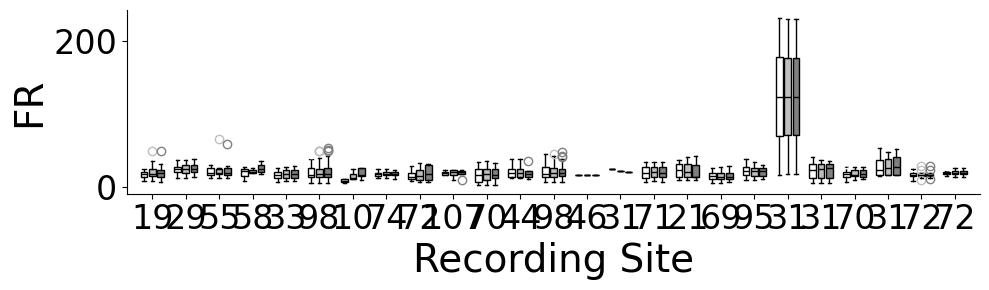

In [288]:
# Plot average FR on units
fr_colors = [[1,1,1], [0.75, 0.75, 0.75], [0.5, 0.5, 0.5]]
fig, ax = plt.subplots(1,1, figsize=(10,3))
for ievent, align_event in enumerate(align_events):
    test = []
    test = [np.mean(rasters['neural'][align_event][irec][:,np.array(df['good_trial'][df['date']==dates[irec]]),:][:,:,stable_unit_idx[irec]], axis=(0,1)) for irec in range(nrecs)]
    # aopy.visualization.plot_boxplots(test, list(np.arange(nrecs)+(0.25*ievent)), trendline=False, ax=ax)
    ax.set_xticks([], [])
    aopy.visualization.plot_boxplots(test, np.arange(len(test))+0.25*ievent, trendline=False, facecolor=fr_colors[ievent], box_width=0.2, ax=ax)
ax.set_xticks(np.arange(len(test))+0.25, recording_site), ax.set(xlabel='Recording Site', ylabel='FR')

fig.tight_layout()
plt.show()

fig, ax = plt.subplots(1,2, figsize=(12,3))
for ievent, align_event in enumerate(align_events):
    test_M1 = [np.mean(rasters['neural'][align_event][irec][:,np.array(df['good_trial'][df['date']==dates[irec]]),:][:,:,stable_unit_idx[irec]], axis=(0,1)) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
    test_PM = [np.mean(rasters['neural'][align_event][irec][:,np.array(df['good_trial'][df['date']==dates[irec]]),:][:,:,stable_unit_idx[irec]], axis=(0,1)) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]
    ax[0].set_xticks([], []), ax[1].set_xticks([], [])
    aopy.visualization.plot_boxplots(test_M1, np.arange(len(test_M1))+0.25*ievent, trendline=False, facecolor=fr_colors[ievent], box_width=0.2, ax=ax[0])
    aopy.visualization.plot_boxplots(test_PM, np.arange(len(test_PM))+0.25*ievent, trendline=False, facecolor=fr_colors[ievent], box_width=0.2, ax=ax[1])


ax[0].set_xticks(np.arange(len(test_M1))+0.25, recording_site[np.in1d(recording_site, recording_brain_areas['M1'])]), ax[0].set(xlabel='Recording Site', ylabel='FR', title='M1')
ax[1].set_xticks(np.arange(len(test_PM))+0.25, recording_site[np.in1d(recording_site, recording_brain_areas['PM'])]), ax[1].set(xlabel='Recording Site', ylabel='FR', title='PM')

fig.tight_layout()
plt.show()

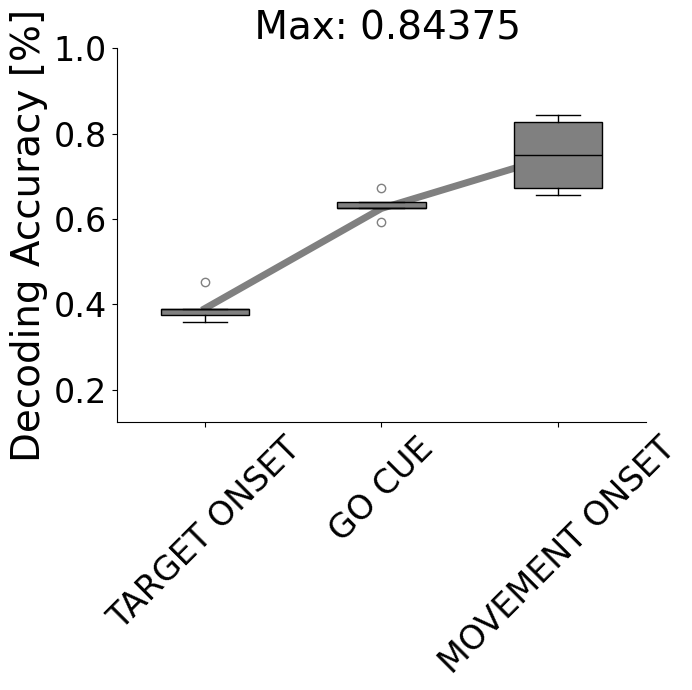

In [289]:
# All Units
fig, ax = plt.subplots(1,1,figsize=(7,7))
aopy.visualization.base.plot_boxplots([lda_results[align_event]['all_units_score'] for align_event in align_events], np.arange(len(align_events)), ax=ax)
ax.set(ylabel='Decoding Accuracy [%]', title=f" Max: {np.max([lda_results[align_event]['all_units_score'] for align_event in align_events])}", ylim=(0.125,1)) 
ax.set_xticks(np.arange(len(align_events)), align_events, rotation=45)
# ax[ievent].plot([trelevant1_time,trelevant1_time], [0,1], 'r--')
# ax[ievent].plot([trelevant2_time,trelevant2_time], [0,1], 'r--')
fig.tight_layout()
plt.show()

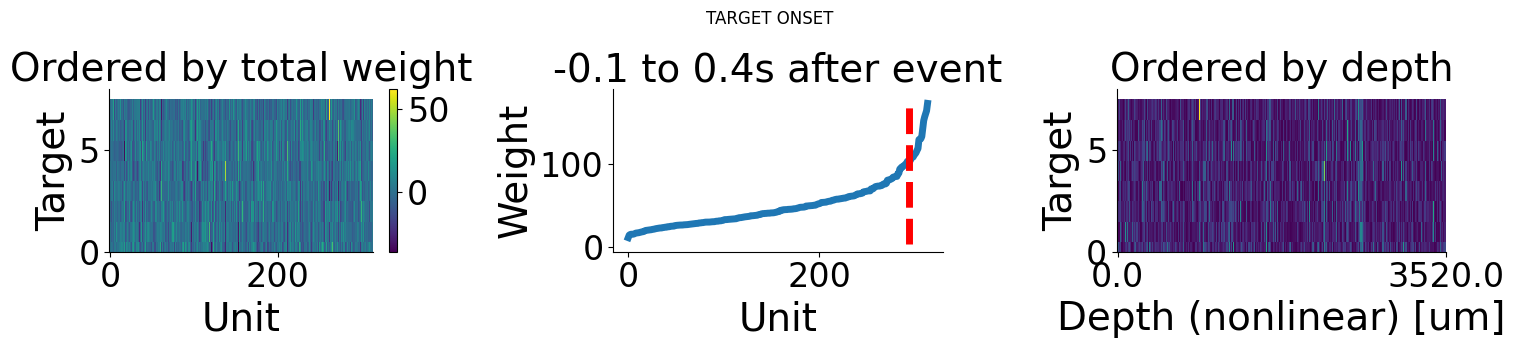

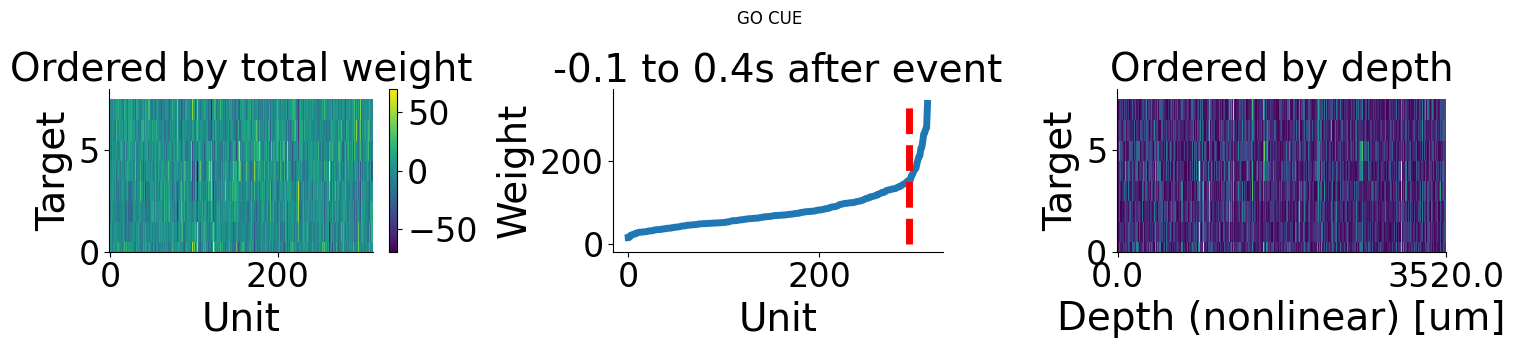

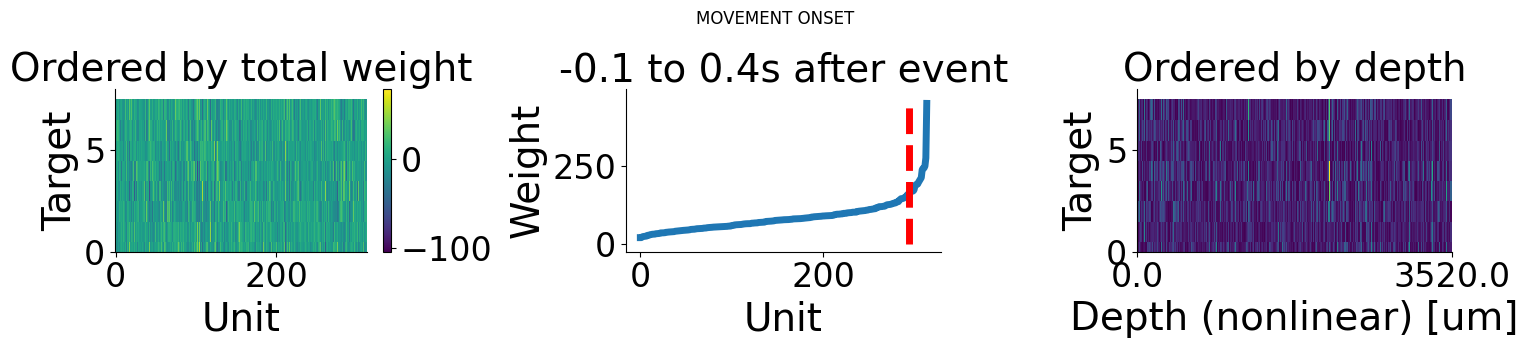

In [478]:
nimportant_units = 20
nall_units = lda_results[align_event]['all_units_weight'].shape[2]
rel_neuron_depth = np.concatenate([3840-neuron_pos[irec] - np.min(3840-neuron_pos[irec]) for irec in range(nrecs)])
all_sorted_weights = []
for align_event in align_events:
    fig, ax = plt.subplots(1,3,figsize=(15,3.5))
    
    sorted_weights = np.argsort(np.sum(np.abs(np.mean(lda_results[align_event]['all_units_weight'], axis=(0,3))), axis=0))
    all_sorted_weights.append(sorted_weights)
    ax0 = ax[0].pcolor(np.arange(nall_units), np.arange(ntargets), np.mean(lda_results[align_event]['all_units_weight'], axis=(0,3)))
    ax[0].set(title='Ordered by total weight', ylim=(0,ntargets), xlabel='Unit', ylabel='Target')
    cb = plt.colorbar(ax0)

    ax[1].plot(np.arange(nall_units), np.sum(np.abs(np.mean(lda_results[align_event]['all_units_weight'], axis=(0,3))), axis=0)[sorted_weights])
    ax[1].set(title=f'{trelevant1_time} to {trelevant2_time}s after event', xlabel='Unit', ylabel='Weight')
    ax[1].plot([nall_units-nimportant_units, nall_units-nimportant_units], ax[1].get_ylim(), 'r--')
    
    ax1 = ax[2].pcolor(np.arange(nall_units), np.arange(ntargets), np.abs(np.mean(lda_results[align_event]['all_units_weight'], axis=(0,3)))[:,np.argsort(rel_neuron_depth)])
    ax[2].set_xticks([0, nall_units], [np.min(rel_neuron_depth), np.max(rel_neuron_depth)])
    ax[2].set(title='Ordered by depth', ylim=(0,ntargets), ylabel='Target', xlabel='Depth (nonlinear) [um]')
    # cb = plt.colorbar(ax1)
    
    plt.suptitle(align_event)
    fig.tight_layout()
    plt.show()
    

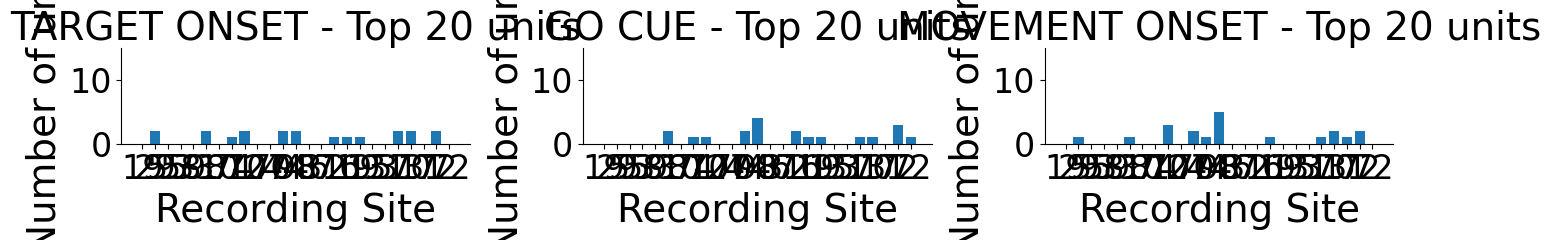

In [479]:
all_unit_recoring_number = np.concatenate([irec*np.ones(len(stable_unit_idx[irec])) for irec in range(nrecs)])
fig, ax = plt.subplots(1,3, figsize=(14, 2.5))
overlap_unit_idx = all_sorted_weights[0][-nimportant_units:][np.in1d(all_sorted_weights[0][-nimportant_units:], all_sorted_weights[2][-nimportant_units:])]
for ievent, event in enumerate(align_events):
    important_units = all_sorted_weights[ievent][-nimportant_units:]
    units_per_rec = []
    for irec in range(len(np.unique(all_unit_recoring_number))):
        units_per_rec.append(np.sum(all_unit_recoring_number[important_units] == irec))
        
        
    ax[ievent].bar(np.arange(len(units_per_rec)), units_per_rec)
    ax[ievent].set(xlabel='Recording Site', ylabel='Number of units', title=f"{event} - Top {nimportant_units} units", ylim=(0,15))
    ax[ievent].set_xticks(np.arange(len(units_per_rec)), recording_site)
fig.tight_layout()
plt.show()

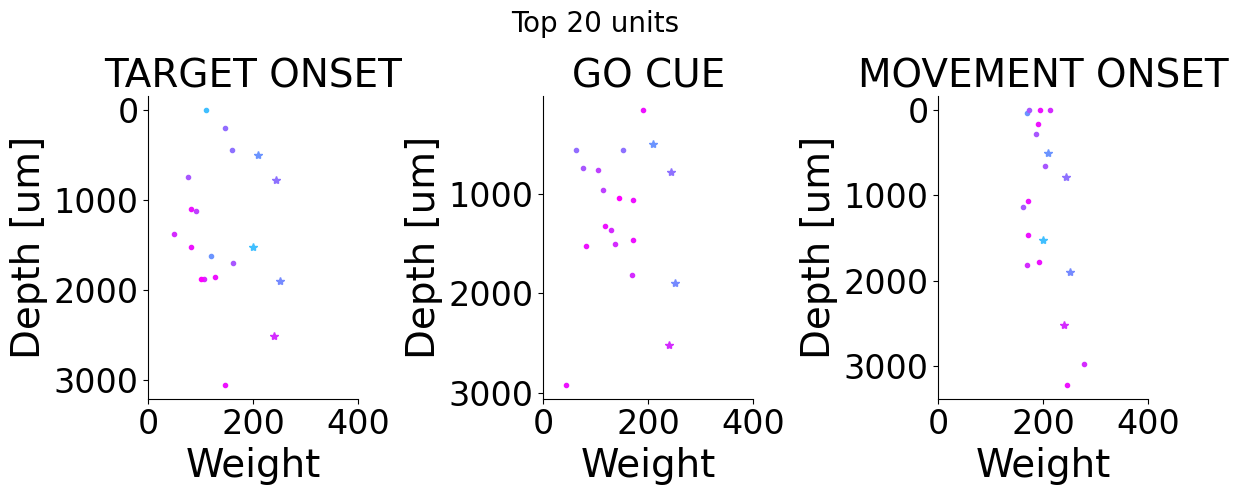

In [480]:
all_unit_recoring_number = np.concatenate([irec*np.ones(len(stable_unit_idx[irec])) for irec in range(nrecs)])
fig, ax = plt.subplots(1,3, figsize=(12, 5))
overlap_unit_idx = all_sorted_weights[0][-nimportant_units:][np.in1d(all_sorted_weights[0][-nimportant_units:], all_sorted_weights[2][-nimportant_units:])]
for ievent, event in enumerate(align_events):
    important_units = all_sorted_weights[ievent][-nimportant_units:]
    
    for unit_idx in important_units:
        if unit_idx in overlap_unit_idx:
            ax[ievent].plot(np.sum(np.abs(np.mean(lda_results[align_event]['all_units_weight'], axis=(0,3)))[:,unit_idx], axis=0), rel_neuron_depth[unit_idx],  '*', color=day_colors[int(all_unit_recoring_number[unit_idx])])
        else:
            ax[ievent].plot(np.sum(np.abs(np.mean(lda_results[align_event]['all_units_weight'], axis=(0,3)))[:,unit_idx], axis=0), rel_neuron_depth[unit_idx],  '.', color=day_colors[int(all_unit_recoring_number[unit_idx])])
    ax[ievent].invert_yaxis()
    ax[ievent].set(xlabel='Weight', ylabel='Depth [um]', title=f"{event}", xlim=(0,400))
plt.suptitle(f"Top {nimportant_units} units", fontsize=20)
fig.tight_layout()
plt.show()

#### Single channel decoding

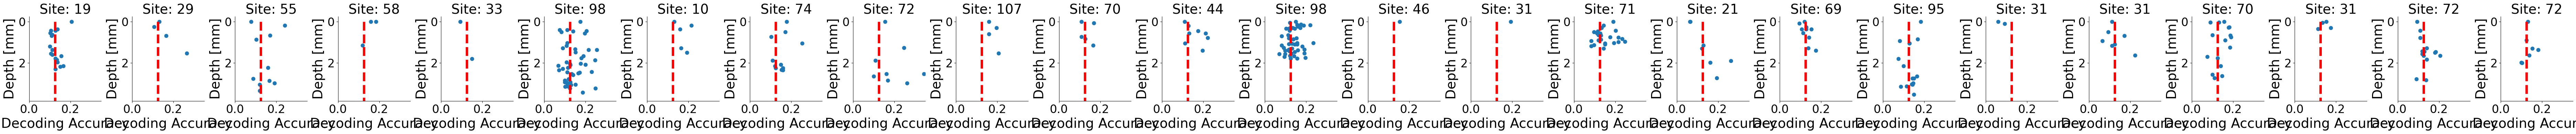

In [268]:
align_event = align_events[-1]
fig, ax = plt.subplots(1,nrecs, figsize=(nrecs*3,4))
for irec in range(nrecs):
    cbdsd = ax[irec].plot(np.mean(lda_results[align_event]['single_ch_decoding'][irec],axis=1),  np.array(unit_df[unit_df['date']==dates[irec]]['rel_depth'])/1000, '.', markersize=15)
    ax[irec].plot([0.125, 0.125], [0,4], 'r--')
    ax[irec].set(title=f"Site: {recording_site[irec]}", xlabel='Decoding Accuracy', ylabel = 'Depth [mm]', xlim=(0,0.35), ylim=(-.25,3.840))
    ax[irec].invert_yaxis()

fig.tight_layout()
plt.show()

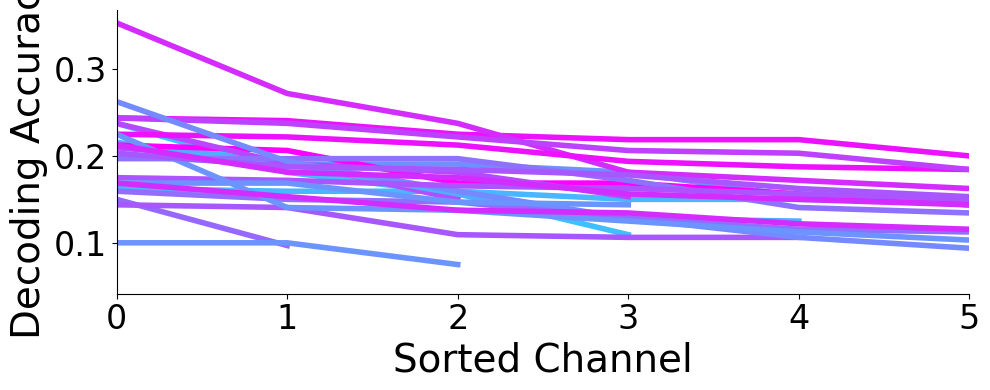

In [351]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
nch = lda_results[align_event]['single_ch_decoding'][0].shape[1]
for irec in range(nrecs):
    nch = lda_results[align_event]['single_ch_decoding'][irec].shape[0]
    # maxtidx = np.argmax(np.mean(lda_results[align_event]['single_ch_decoding'][irec], axis=1), axis=0)
    ax.plot(np.flip(np.sort([np.mean(lda_results[align_event]['single_ch_decoding'][irec],axis=1)[ich] for ich in range(nch)])), color=day_colors[irec], linewidth=4)
    ax.set(xlabel='Sorted Channel', ylabel='Decoding Accuracy')
    ax.set(xlim=(0,5))

fig.tight_layout()
plt.show()

In [352]:
align_event = align_events[-1]
single_ch_max_dec = []
single_ch_site = []
for ii in range(len(lda_results[align_event]['single_ch_decoding'])):
    if len(lda_results[align_event]['single_ch_decoding'][ii]) > 0:
        for iunit in range(lda_results[align_event]['single_ch_decoding'][ii].shape[0]):
            single_ch_max_dec.append(100*np.mean(lda_results[align_event]['single_ch_decoding'][ii], axis=1)[iunit])
            single_ch_site.append(ii)
    

In [353]:
fig, ax = plt.subplots(1,2,figsize=(10,5), gridspec_kw={'width_ratios':[1,3]})
single_ch_med = np.median(single_ch_max_dec)
single_ch_sd = np.std(single_ch_max_dec)
high_dec_mask = np.array(single_ch_max_dec) > single_ch_med+1*single_ch_sd
hist, bins = np.histogram(np.array(single_ch_site)[high_dec_mask], bins = np.arange(nrecs+1)-.5)
ax[0].hist(single_ch_max_dec, bins=np.arange(8,50,1), color=(.498, 0.098, .184), alpha=0.5)
ax[0].hist(np.array(single_ch_max_dec)[high_dec_mask], bins=np.arange(8,50,1), color=(.498, 0.098, .184))
# ax[0].plot([single_ch_med, single_ch_med], ax[0].get_ylim())
ax[0].plot([single_ch_med+1*single_ch_sd, single_ch_med+1*single_ch_sd], ax[0].get_ylim(), 'r', linewidth=5)
ax[0].set(xlabel='Single Unit \n Accuracy [%]', ylabel='Unit Count')
ax[0].set_xticks([15,30,45])
colors_hist = np.array(hist)
hist_denom, bins = np.histogram(np.array(single_ch_site), bins = np.arange(nrecs+1)-.5)
dec_map = ax[1].scatter(ecog_dec_acc[subject]['rec_locations'][:,0], ecog_dec_acc[subject]['rec_locations'][:,1], s=250, c=colors_hist/hist_denom, cmap='YlGnBu')
cb = plt.colorbar(dec_map)
# cb.set_ticks((0,.5))
# cb.set_label('High decoding units', color=(.498, 0.098, .184))
ax[1].set(xlim=(-6,6), ylim=(-6,6), xlabel='X [mm]', ylabel='Y [mm]')
ax[1].set_aspect('equal')

fig.tight_layout()
aopy.visualization.savefig(base_save_dir, 'surface_distribution.svg')

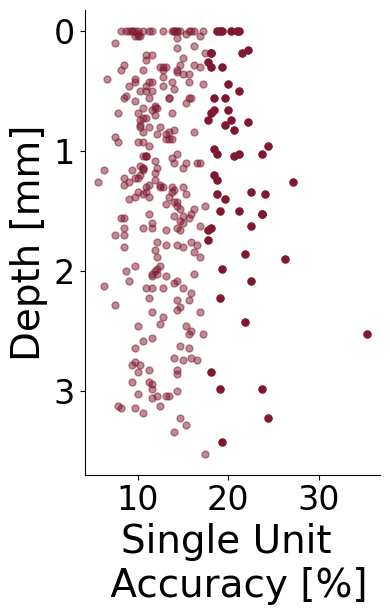

In [354]:
fig, ax = plt.subplots(1,1, figsize=(4,6.25))
dec_thresh = single_ch_med+1*single_ch_sd
for irec in range(nrecs):
    nch = lda_results[align_event]['single_ch_decoding'][irec].shape[0]
    rel_depth_list = list(unit_df[unit_df['rec_number']==irec]['rel_depth'])
    temp = []
    for ich in range(nch):
        temp.append(100*np.mean(lda_results[align_event]['single_ch_decoding'][irec],axis=1)[ich])
    ax.plot(np.array(temp)[np.argsort(rel_depth_list)],np.sort(rel_depth_list)/1000 ,'.', color=(.498, 0.098, .184), alpha=0.5, markersize=10)
    ax.plot(np.array(temp)[np.argsort(rel_depth_list)][np.array(temp)[np.argsort(rel_depth_list)] > dec_thresh], np.sort(rel_depth_list)[np.array(temp)[np.argsort(rel_depth_list)] > dec_thresh]/1000,'.', color=(.498, 0.098, .184), markersize=10)
    ax.set(ylabel='Depth [mm]', xlabel='Single Unit \n Accuracy [%]')
    ax.invert_yaxis()
fig.tight_layout()
aopy.visualization.savefig(base_save_dir, f'{subject}_event_lda_single_ch_depth.svg')

### All good units

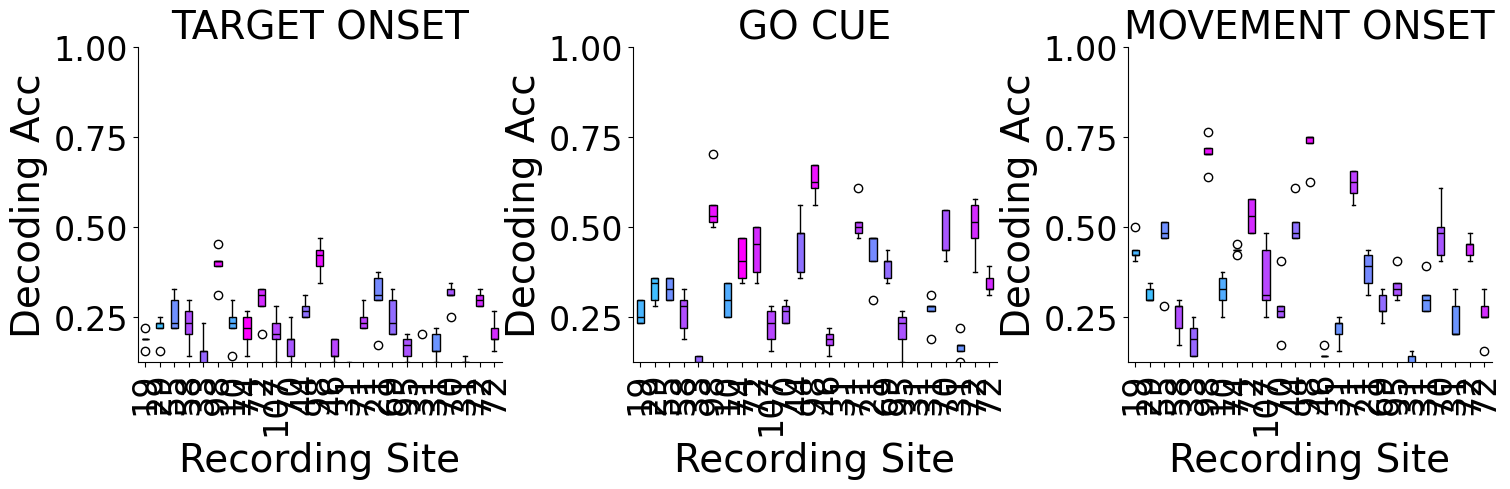

In [481]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
for ievent, align_event in enumerate(align_events):
    for irec in range(nrecs):
        # box1 = ax[ievent].boxplot([np.squeeze(lda_results[align_event]['scores'][irec]) for irec in range(nrecs)])
        box1 = ax[ievent].boxplot(np.squeeze(lda_results[align_event]['scores'][irec]), positions=[irec], patch_artist=True, widths=0.5, boxprops=dict(facecolor=day_colors[irec], color='black'), medianprops=dict(color='black'))
    ax[ievent].set(xlabel='Recording Site', ylabel='Decoding Acc', title=f"{align_event}",ylim=(0.125, 1))
    ax[ievent].set_xticks(np.arange(nrecs), recording_site, rotation=90)
    # ax[ievent].annotate(f"Max: {np.round(np.max(max_planning_dec_acc_recs),3)}", (0.25, 0.4))
fig.tight_layout()
plt.show()

In [482]:
# align_event = align_events[-1]
# for irec in range(nrecs):
#     fig, ax = plt.subplots(1,2,figsize=(10,2))
#     ax[0].plot(preproc_metadata['trial_time_axis'], np.mean(lda_results[align_event]['scores'][irec], axis=1))

#     max_tidx = np.argmax(np.mean(lda_results[align_event]['scores'][irec], axis=1))
#     ax[0].plot([preproc_metadata['trial_time_axis'][nlda_lags:][max_tidx], preproc_metadata['trial_time_axis'][nlda_lags:][max_tidx]], [0.1, 0.8], 'r--')
#     # Look at weights at max t
#     weightim = ax[1].pcolor(np.mean(lda_results[align_event]['weights'][irec], axis=3)[max_tidx,:,:])
#     ax[0].set(xlabel='Time', ylabel='Dec Acc')
#     ax[1].set(xlabel='Unit', ylabel='Target')
#     plt.suptitle(f"Recording {recording_site[irec]}")
#     cb = plt.colorbar(weightim, label='Weight')
    
#     unit_rank = np.flip(np.argsort((np.sum(np.abs(np.mean(lda_results[align_event]['weights'][irec], axis=3)[max_tidx,:,:]), axis=0))))
#     fig, ax = plt.subplots(1,1,figsize=(10,1.5))
#     # weightim = ax[0].pcolor(np.mean(lda_results['weights'][irec], axis=3)[max_tidx,:,unit_rank].T, vmin=-10, vmax=10)
#     # ax[0].set(xlabel='Unit number', ylabel='Target')
#     # cb = plt.colorbar(weightim, label='Weight')
#     ax.plot((np.sum(np.abs(np.mean(lda_results[align_event]['weights'][irec], axis=3)[max_tidx,:,:]), axis=0))[unit_rank])
#     ax.set(xlabel='Unit number', ylabel='Total weight', xlim=(0,50))
#     ax.set_xticks(np.arange(len(stable_unit_idx[irec]))[:50], stable_unit_labels[irec][unit_rank][:50], rotation = 75)
#     fig.tight_layout()
#     plt.show()
    
#     # Plot FR vs. time traces of the 10 highest weighted neurons
#     avg_fr_each_trial = np.mean(rasters['neural'][align_event][irec][:,:,stable_unit_idx[irec]], axis=0)
#     smooth_avg_fr_each_trial = aopy.analysis.base.calc_rolling_average(avg_fr_each_trial, window_size=17)
    
#     nunits_plot = 6
#     fig, ax = plt.subplots(2,nunits_plot, figsize=(nunits_plot*1.6,3))
#     for iunit in range(nunits_plot):
#         ax[0,iunit].plot(smooth_avg_fr_each_trial[:ntest_trials,unit_rank[iunit]])
#         ax[0,iunit].set(xlabel='Trial', ylabel='Firing rate', title=f"Unit: {stable_unit_labels[irec][unit_rank[iunit]]}")
#         ax[1,iunit].plot(unit_df[unit_df['rec_number']==irec].reset_index()['waveform'][unit_rank[iunit]], 'r--')

#     plt.suptitle(f"Recording {recording_site[irec]} - High weight units")
#     fig.tight_layout()
#     plt.show()
    
#     fig, ax = plt.subplots(2,nunits_plot, figsize=(nunits_plot*1.6,3))
#     for iunit in range(nunits_plot):
#         ax[0,iunit].plot(smooth_avg_fr_each_trial[:ntest_trials,unit_rank[-(iunit+1)]])
#         ax[1,iunit].set(xlabel='Trial', ylabel='Firing rate', title=f"Unit: {stable_unit_labels[irec][unit_rank[-(iunit+1)]]}")
#         ax[1,iunit].plot(unit_df[unit_df['rec_number']==irec].reset_index()['waveform'][unit_rank[-(iunit+1)]], 'r--')

#     plt.suptitle(f"Recording {recording_site[irec]} - Low weight units")
#     fig.tight_layout()
#     plt.show()

In [483]:
# fig, ax = plt.subplots(1,2,figsize=(14,4))
# [ax[0].plot(preproc_metadata['trial_time_axis'], np.mean(lda_results[align_event]['scores'][irec],axis=1), linewidth=4,color=day_colors[irec], label=f"{np.round(ecog_dec_acc_rec_site[align_event][irec],3)}") for irec in range(nrecs)]
# [ax[1].plot(lda_results[align_event]['dec_unit_weight_rank'][irec], linewidth=4,color=day_colors[irec], label=f"{np.round(ecog_dec_acc_rec_site[align_event][irec],3)}") for irec in range(nrecs)]
# ax[1].set(xlabel='Unit', ylabel='Total LDA weight')
# ax[1].set_yscale('log')
# ax[1].legend(bbox_to_anchor=(1,1))
# plt.show()

In [484]:
# nunitsplt = 30
# fig, ax = plt.subplots(2,2,figsize=(14,6))
# [ax[0,0].plot(lda_results[align_event]['dec_unit_weight_rank'][irec][:nunitsplt], linewidth=4,color=day_colors[irec]) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
# [ax[0,1].plot(lda_results[align_event]['dec_unit_weight_rank'][irec][:nunitsplt], linewidth=4,color=day_colors[irec]) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]

# [ax[1,0].plot(lda_results[align_event]['dec_unit_weight_rank'][irec][:nunitsplt]/np.max(lda_results[align_event]['dec_unit_weight_rank'][irec][:nunitsplt]), linewidth=4,color=day_colors[irec], label=f"{np.round(ecog_dec_acc_rec_site[align_event][irec],3)}") for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
# [ax[1,1].plot(lda_results[align_event]['dec_unit_weight_rank'][irec][:nunitsplt]/np.max(lda_results[align_event]['dec_unit_weight_rank'][irec][:nunitsplt]), linewidth=4,color=day_colors[irec], label=f"{np.round(ecog_dec_acc_rec_site[align_event][irec],3)}") for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]

# [ax[0, iax].set(xlabel='Unit', ylabel='LDA weight') for iax in range(ax.shape[0])]
# [ax[1, iax].set(xlabel='Unit', ylabel='Normalized LDA weight') for iax in range(ax.shape[0])]
# _, _ = ax[0,0].set(title='M1'), ax[0,1].set(title='PM')

# [ax[1,iax].legend() for iax in range(ax.shape[0])]
# plt.show()

In [485]:
# for ievent, align_event in enumerate(align_events):
#     fig, ax = plt.subplots(1,nrecs, figsize=(20,4))
#     for irec in range(nrecs):
#         ax[irec].plot(np.mean(np.abs(lda_results[align_event]['weights'][irec]), axis=(0,1,3)), 3840-neuron_pos[irec], '.')
#         ax[irec].set(xlabel='Weight', ylabel='', title=f'Rec Site: {recording_site[irec]}', xlim=(0, 12.5))
#         ax[irec].invert_yaxis()
#     plt.suptitle(f"{align_event}")
#     fig.tight_layout()
#     plt.show()

In [486]:
# for ievent, align_event in enumerate(align_events):
#     fig, ax = plt.subplots(1,nrecs, figsize=(20,4))
#     for irec in range(nrecs):
#         ax[irec].plot(np.mean(np.abs(lda_results[align_event]['weights'][irec]), axis=(0,1,3)), 3840-neuron_pos[irec], '.')
#         ax[irec].set(xlabel='Weight', ylabel='', title=f'Rec Site: {recording_site[irec]}', xlim=(0, 12.5))
#         ax[irec].invert_yaxis()
#     plt.suptitle(f"{align_event}")
#     fig.tight_layout()
#     plt.show()

In [487]:
# for ievent, align_event in enumerate(align_events):
#     fig, ax = plt.subplots(1,nrecs, figsize=(20,4))
#     for irec in range(nrecs):
#         for itarget in range(len(np.unique(df['target_idx']))):
#             ax[irec].plot(np.mean(np.abs(lda_results[align_event]['weights'][irec][:,itarget,:,:]), axis=(0,2)), 3840-neuron_pos[irec], '.',color=colors[itarget+1], alpha=0.5)
#         ax[irec].set(xlabel='Weight', ylabel='', title=f'Rec Site: {recording_site[irec]}')
#         ax[irec].invert_yaxis()
#     plt.suptitle(f"{align_event}")
#     fig.tight_layout()
#     plt.show()

### Neuron number matched

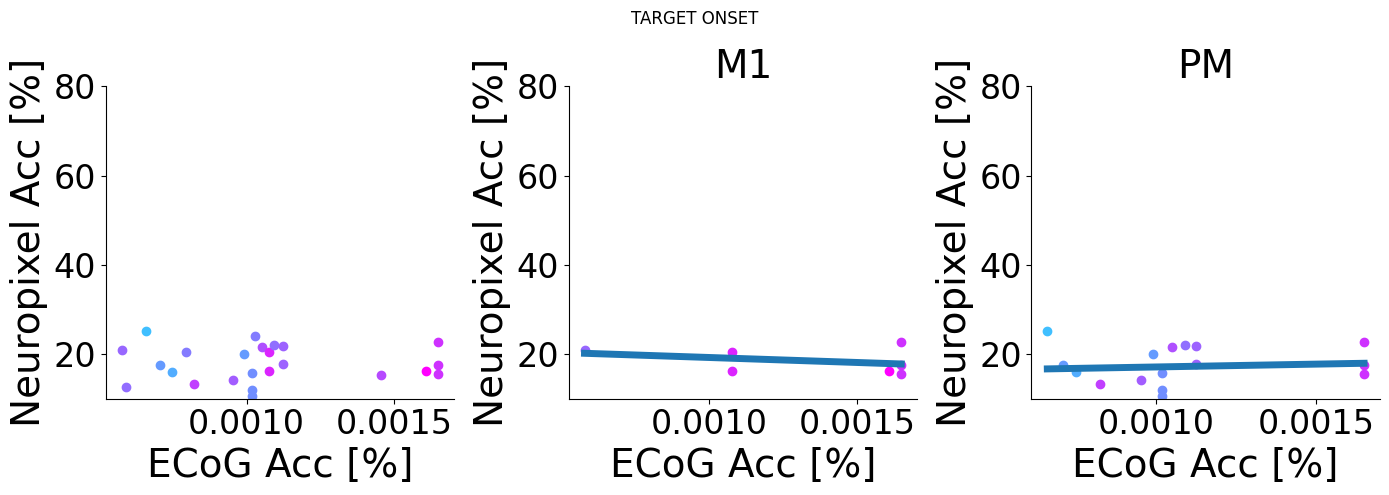

In [305]:
# Plot max decoding
for align_event in align_events:
    fig, ax = plt.subplots(1,3,figsize=(14,5))
    [ax[0].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[iday], 100*np.array(lda_results[align_event]['neural_space_max'])[iday], '.', color=day_colors[iday], markersize=12) for iday in range(nrecs)]
    # ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0]])               
    ax[0].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (2e7, 60))
    ax[0].set(xlabel='ECoG Acc [%]', ylabel='Neuropixel Acc [%]', ylim=(10, 80))
    
    [ax[1].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[iday], 100*np.array(lda_results[align_event]['neural_space_max'])[iday], '.', color=day_colors[iday], markersize=12) for iday in range(nrecs) if recording_site[iday] in recording_brain_areas['M1']]
    ax[1].plot([100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx]), 100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx])], [(lda_results[align_event]['neural_max_reg_fit_M1'].coef_*100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx])+lda_results[align_event]['neural_max_reg_fit_M1'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit_M1'].coef_*100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx])+lda_results[align_event]['neural_max_reg_fit_M1'].intercept_)[0]])               
    ax[1].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval_M1'],3)}", (2e7, 60))
    ax[1].set(xlabel='ECoG Acc [%]', ylabel='Neuropixel Acc [%]', ylim=(10, 80), title='M1')
    
    [ax[2].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[iday], 100*np.array(lda_results[align_event]['neural_space_max'])[iday], '.', color=day_colors[iday], markersize=12) for iday in range(nrecs) if recording_site[iday] in recording_brain_areas['PM']]
    ax[2].plot([100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx]), 100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx])], [(lda_results[align_event]['neural_max_reg_fit_PM'].coef_*100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx])+lda_results[align_event]['neural_max_reg_fit_PM'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit_PM'].coef_*100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx])+lda_results[align_event]['neural_max_reg_fit_PM'].intercept_)[0]])               
    ax[2].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval_PM'],3)}", (2e7, 60))
    ax[2].set(xlabel='ECoG Acc [%]', ylabel='Neuropixel Acc [%]', ylim=(10, 80), title='PM')
    
    fig.suptitle(f"{align_event}")
    fig.tight_layout()
    
        # if save_figs:
    aopy.visualization.savefig(base_save_dir, f'lda_dec_acc_{align_event}.svg')

In [239]:
## Plot spatial map of decoding
fig, ax = plt.subplots(1,3,figsize=(14,4))
for ievent, align_event in enumerate(align_events):
    colors = np.array(lda_results[align_event]['neural_space_max'])
    dec_map = ax[ievent].scatter(ecog_dec_acc[subject]['rec_locations'][:,0], ecog_dec_acc[subject]['rec_locations'][:,1], s=100, c=colors, cmap='YlGnBu', vmin=0.1, vmax=.55)
    cb = plt.colorbar(dec_map)
    ax[ievent].set(xlim=(-6,6), ylim=(-6,6), title=align_event)
    
fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1,nrecs, figsize=(40,3))
for irec in range(nrecs):
    cm = ax[irec].pcolor(np.mean(lda_results[align_event]['confusion_matrix'][irec][:,:,:], axis=0), vmin=0.125, vmax=.7)
    cb = plt.colorbar(cm)
    ax[irec].set(title=f"Rec Site: {recording_site[irec]}")

fig.tight_layout()
plt.show()

fig, ax = plt.subplots(1,nrecs, figsize=(40,3))
for irec in range(nrecs):
    cm = ax[irec].pcolor(np.mean(lda_results[align_event]['confusion_matrix'][irec][:,:,:], axis=0), vmin=0.125)
    cb = plt.colorbar(cm)
    ax[irec].set(title=f"Rec Site: {recording_site[irec]}")

fig.tight_layout()
plt.show()

In [ ]:
# Plot max decoding
tline_xmax = 7e7
tline_xmin = 0
for align_event in align_events:
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    m1_color='firebrick'
    pm_color='black'
    ax.plot(100*np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx], 100*np.array(lda_results[align_event]['neural_space_max'])[M1_rec_idx], '.', color=m1_color, markersize=10)
    ax.plot(100*np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx], 100*np.array(lda_results[align_event]['neural_space_max'])[PM_rec_idx], '.', color=pm_color, markersize=10)
    ax.plot([tline_xmin, tline_xmax], [(lda_results[align_event]['neural_max_reg_fit_M1'].coef_*tline_xmin+lda_results[align_event]['neural_max_reg_fit_M1'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit_M1'].coef_*tline_xmax+lda_results[align_event]['neural_max_reg_fit_M1'].intercept_)[0]], color=m1_color, linewidth=4)               
    ax.plot([tline_xmin, tline_xmax], [(lda_results[align_event]['neural_max_reg_fit_PM'].coef_*tline_xmin+lda_results[align_event]['neural_max_reg_fit_PM'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit_PM'].coef_*tline_xmax+lda_results[align_event]['neural_max_reg_fit_PM'].intercept_)[0]], color=pm_color, linewidth=4)               
    ax.annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (2e7, 60))
    ax.set(xlabel='ECoG Acc [%]', ylabel='Neuropixel Acc [%]', ylim=(0, 75), title=f"{align_event}")    
        # if save_figs:
    aopy.visualization.savefig(base_save_dir, f'lda_dec_acc_{align_event}.svg')

### KS drift

In [58]:
# # Plot max decoding
# for align_event in align_events:
#     fig, ax = plt.subplots(1,3,figsize=(10,3))
#     ax[0].plot(np.array(ksdrift['drift_max']), 100*np.array(lda_results[align_event]['neural_space_max']), 'k.', markersize=8)
#     # ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0]])               
#     # ax[0].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (3, 20))
#     ax[0].set(xlabel='KS Drift [um]', ylabel='Neuropixel Acc [%]', ylim=(10, 100))
    
#     ax[1].plot(np.array(ksdrift['drift_max'])[M1_rec_idx], 100*np.array(lda_results[align_event]['neural_space_max'])[M1_rec_idx], 'k.', markersize=8)
#     # ax[1].plot([100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx]), 100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx])], [(lda_results[align_event]['neural_max_reg_fit_M1'].coef_*100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx])+lda_results[align_event]['neural_max_reg_fit_M1'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit_M1'].coef_*100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx])+lda_results[align_event]['neural_max_reg_fit_M1'].intercept_)[0]])               
#     # ax[1].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval_M1'],3)}", (3, 20))
#     ax[1].set(xlabel='KS Drift [um]', ylabel='Neuropixel Acc [%]', ylim=(10, 100), title='M1')
    
#     ax[2].plot(np.array(ksdrift['drift_max'])[PM_rec_idx], 100*np.array(lda_results[align_event]['neural_space_max'])[PM_rec_idx], 'k.', markersize=8)
#     # ax[2].plot([100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx]), 100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx])], [(lda_results[align_event]['neural_max_reg_fit_PM'].coef_*100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx])+lda_results[align_event]['neural_max_reg_fit_PM'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit_PM'].coef_*100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx])+lda_results[align_event]['neural_max_reg_fit_PM'].intercept_)[0]])               
#     # ax[2].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval_PM'],3)}", (3, 20))
#     ax[2].set(xlabel='KS Drift [um]', ylabel='Neuropixel Acc [%]', ylim=(10, 100), title='PM')
    
#     fig.suptitle(f"{align_event}")
#     fig.tight_layout()

### Pseudopopulation

#### Random

In [ ]:
print(pseudopopulation_metadata['nrandom_units'])
for align_event in align_events:
    random_scores = np.array([np.mean(lda_results[align_event]['pseudopopulations']['random_scores_event'][igroup]) for igroup in range(len(lda_results[align_event]['pseudopopulations']['random_scores_event']))])
    fig, ax = plt.subplots(1,2,figsize=(12,5))
    ax[0].plot(random_scores[np.argsort(random_scores)])
    [ax[iax].set(xlabel='Time [s]', ylabel='Decoding Accuracy', ylim=(0.125,1), title=align_event) for iax in range(len(ax))]
    random_mean = np.mean(random_scores, axis=0)
    random_std = np.std(random_scores, axis=0)
    ax[1].boxplot(random_scores)
    ax[1].set(title=f"{align_event} - {pseudopopulation_metadata['nrandom_groups']} iteration $\mu \pm \sigma$")
    
    plt.suptitle(f"Random Unit Groups {align_event}")
    fig.tight_layout()
    plt.show()

#### Column

In [172]:
column_colors = []
for irec in range(len(column_units)):
    if len(column_units[irec]) > 0:
        date_mask = np.logical_and(ecog_dec_acc[subject]['rec_locations'][:,0] == column_units[irec]['rec_xpos'][0], ecog_dec_acc[subject]['rec_locations'][:,1] == column_units[irec]['rec_ypos'][0])
        date_idx = np.where(date_mask)[0][0]
        column_colors.append(day_colors[date_idx])
    else:
        column_colors.append([0,0,0])
        continue

In [31]:
# Decoding accuracy as a function of ecog maps
fig, ax = plt.subplots(1,3,figsize=(15,5))
for ievent, align_event in enumerate(align_events):
    column_scores = np.array([np.mean(lda_results[align_event]['pseudopopulations']['column_scores_event'][igroup]) for igroup in range(len(lda_results[align_event]['pseudopopulations']['column_scores_event'])) if len(lda_results[align_event]['pseudopopulations']['column_scores_event'][igroup])>0])
    column_site_idx = [igroup for igroup in range(len(column_units)) if len(lda_results[align_event]['pseudopopulations']['column_scores_event'][igroup])>0]
    xaxis = np.array(ecog_dec_acc_rec_site_pp[align_event])/np.nanmax(np.array(ecog_dec_acc_rec_site_pp[align_event]))
    _,_,_,pval,regfit = aopy.analysis.base.linear_fit_analysis2D(xaxis[~np.isnan(xaxis)], 100*column_scores)
    [ax[ievent].plot(np.array(ecog_dec_acc_rec_site_pp[align_event])[col]/np.nanmax(np.array(ecog_dec_acc_rec_site_pp[align_event])), 100*column_scores[icol], '.', color=column_colors[icol], markersize=30) for icol, col in enumerate(column_site_idx)]
    ax[ievent].plot([0, 1], [regfit.intercept_[0],regfit.coef_[0][0]+regfit.intercept_[0]], '--', color=(0.5,0.5,0.5))               
    ax[ievent].annotate(f"Regression p: {np.round(pval,3)}", (2e7, 60))
    ax[ievent].set(xlabel='$\mu$ECoG Weight [a.u.]', ylabel='Decoding Accuracy [%]', ylim=(12.5,100),xlim=(0,1.1), title=align_event)
    print(pval)
    if pval < 0.05:
        ax[ievent].annotate('*',(1.05,(2*10)+27), fontsize=30, color=(0.5,0.5,0.5))
    else:
        ax[ievent].annotate(f'{np.round(pval,3)}',(.95,35), fontsize=30, color=(0.5,0.5,0.5))

    fig.tight_layout()
    # aopy.visualization.savefig(base_save_dir, 'lda_column_ecog.svg')

KeyError: 'column_scores_event'

In [32]:
# plt.plot(xaxis[~np.isnan(yaxis)], 100*column_scores[~np.isnan(yaxis)], '.')

p=0.1126, $R^2$=0.2128


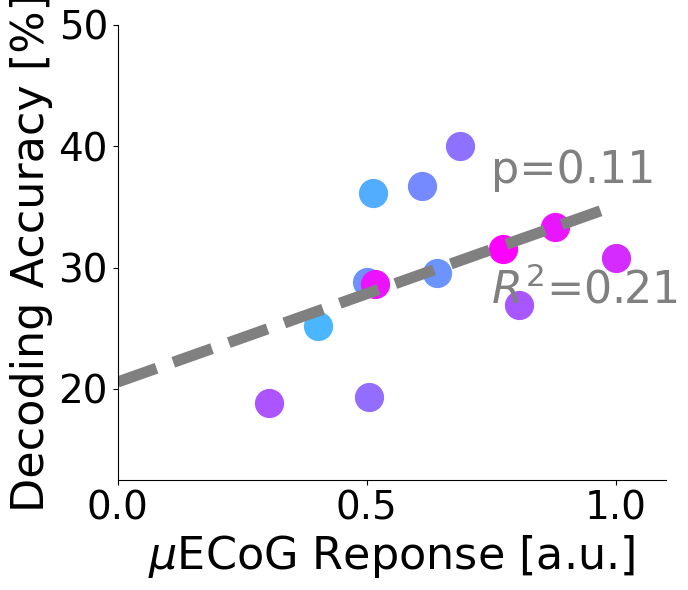

In [179]:
# Decoding accuracy as a function of ecog maps
fig, ax = plt.subplots(1,1,figsize=(7,6))
align_event = align_events[-1]
column_scores = np.array([np.mean(lda_results[align_event]['pseudopopulations']['column_scores_event'][igroup]) if len(lda_results[align_event]['pseudopopulations']['column_scores_event'][igroup])>0 else np.nan for igroup in range(len(lda_results[align_event]['pseudopopulations']['column_scores_event']))])
column_site_idx = [igroup for igroup in range(len(column_units)) if len(lda_results[align_event]['pseudopopulations']['column_scores_event'][igroup])>0]
xaxis = np.array(ecog_dec_acc_rec_site_pp[align_event])/np.nanmax(np.array(ecog_dec_acc_rec_site_pp[align_event]))
yaxis = np.array(column_scores)
_,R2,_,pval,regfit = aopy.analysis.base.linear_fit_analysis2D(xaxis[~np.isnan(yaxis)], 100*column_scores[~np.isnan(yaxis)])
[ax.plot(np.array(ecog_dec_acc_rec_site_pp[align_event])[icol]/np.nanmax(np.array(ecog_dec_acc_rec_site_pp[align_event])), 100*column_scores[icol], '.', color=column_colors[icol], markersize=40) for icol in range(len(column_scores))]
# [ax.annotate(f"{pp_column_sites[icol]}", (np.array(ecog_dec_acc_rec_site_pp[align_event])[icol]/np.nanmax(np.array(ecog_dec_acc_rec_site_pp[align_event])), 100*column_scores[icol]), ha='center', va='center') for icol in range(len(column_scores))]
# [ax.plot(np.array(ecog_dec_acc_rec_site_pp[align_event])[column_site_idx[icol]]/np.max(np.array(ecog_dec_acc_rec_site_pp[align_event])), 100*column_scores[icol], '.', color=column_colors[icol], markersize=30) for icol in range(len(column_scores))]
ax.plot([0, 1], [regfit.intercept_[0],regfit.coef_[0][0]+regfit.intercept_[0]], '--', color=(0.5,0.5,0.5))               
# ax[ievent].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (2e7, 60))
ax.set(xlabel='$\mu$ECoG Reponse [a.u.]', ylabel='Decoding Accuracy [%]', ylim=(12.5,50),xlim=(0,1.1))
print(f"p={np.round(pval,4)}, $R^2$={np.round(R2,4)}")
if pval < 0.05:
    ax.annotate('*',(1.05,(2*10)+27), fontsize=30, color=(0.5,0.5,0.5))
else:
    ax.annotate(f'p={np.round(pval,2)}',(.75,37), fontsize=32, color=(0.5,0.5,0.5))
    ax.annotate(f'$R^2$={np.round(R2,2)}',(.75,27), fontsize=32, color=(0.5,0.5,0.5))
    
fig.tight_layout()
aopy.visualization.savefig(base_save_dir, f'{subject}_lda_column_ecog.svg')

KeyError: 'column_scores_event'

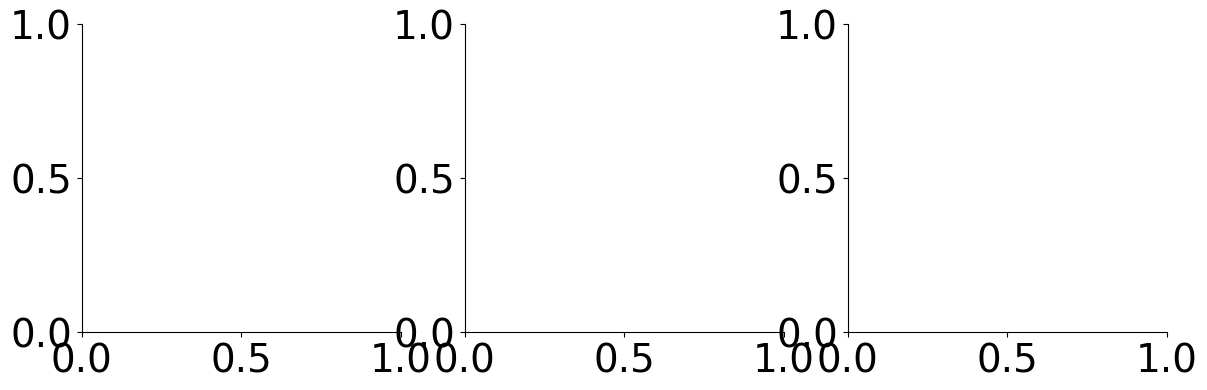

In [60]:
## Plot spatial map of decoding
rec_xpos = [np.unique(column_units[icol]['rec_xpos']) for icol in range(len(column_units))]
rec_ypos = [np.unique(column_units[icol]['rec_ypos']) for icol in range(len(column_units))]
fig, ax = plt.subplots(1,3,figsize=(14,4))
for ievent, align_event in enumerate(align_events):
    column_scores = np.array([np.mean(lda_results[align_event]['pseudopopulations']['column_scores_event'][igroup]) if len(lda_results[align_event]['pseudopopulations']['column_scores_event'][igroup])>0 else np.nan for igroup in range(len(lda_results[align_event]['pseudopopulations']['column_scores_event']))])
    colors = column_scores
    
    dec_map = ax[ievent].scatter(np.array(rec_xpos), np.array(rec_ypos), s=100, c=colors, cmap='YlGnBu', vmin=0.2, vmax=.55)
    cb = plt.colorbar(dec_map)
    ax[ievent].set(xlim=(-6,6), ylim=(-6,6), title=align_event)
    
fig.tight_layout()
plt.show()

In [63]:
print(ecog_dec_acc['affi']['rec_locations'][recording_site==29])
print(ecog_dec_acc['affi']['rec_locations'][recording_site==74])
print(recording_site.shape)

[[-3.79999184  0.75999837]]
[[3.79999184 3.79999184]]
(26,)


In [93]:
## Plot spatial map of decoding
rec_xpos = [np.unique(column_units[icol]['rec_xpos']) for icol in range(len(column_units))]
rec_ypos = [np.unique(column_units[icol]['rec_ypos']) for icol in range(len(column_units))]
align_event = align_events[-1]
fig, ax = plt.subplots(1,1,figsize=(6,5))
column_scores = np.array([np.mean(lda_results[align_event]['pseudopopulations']['column_scores_event'][igroup]) if len(lda_results[align_event]['pseudopopulations']['column_scores_event'][igroup])>0 else np.nan for igroup in range(len(lda_results[align_event]['pseudopopulations']['column_scores_event']))])
colors = column_scores*100

dec_map = ax.scatter(np.array(rec_xpos), np.array(rec_ypos), s=200, c=colors, cmap='YlGnBu', vmin=10, vmax=50)
cb = plt.colorbar(dec_map, label='Decoding Accuracy [%]')
cb.set_ticks([10,50])
ax.set(xlim=(-6,6), ylim=(-6,6), xlabel='X-position [mm]', ylabel='Y-position [mm]')
plt.gca().set_aspect("equal")
fig.tight_layout()
aopy.visualization.savefig(base_save_dir, f'{subject}_lda_np_spatial_map.svg')

0.1264345773153395
0.2057759602315976


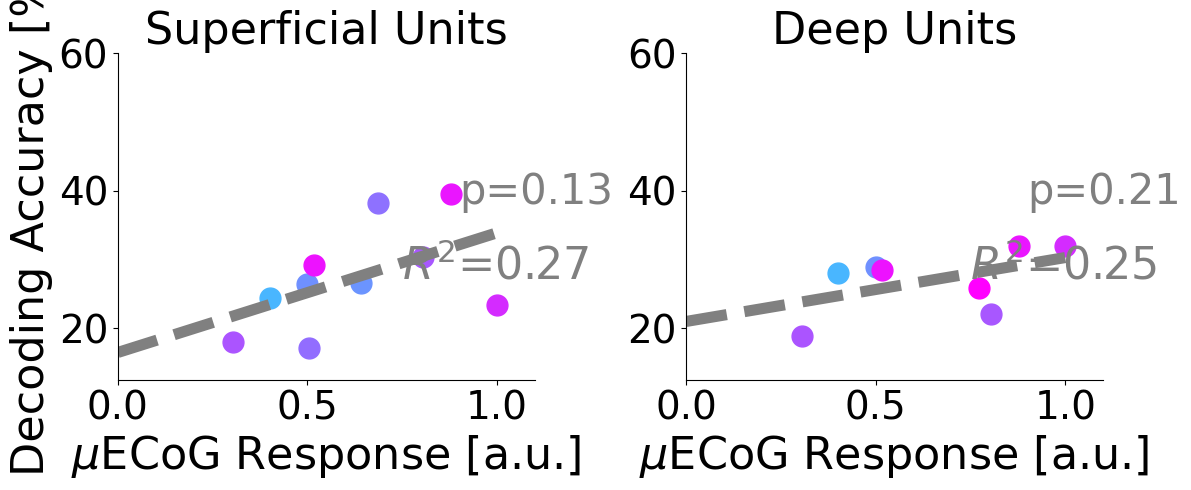

In [180]:
# PLot for ecog relationship for superficial units only and deep units only 
align_event = align_events[-1]
fig, ax = plt.subplots(1,2,figsize=(12,5))
superficial_scores = np.array([np.mean(lda_results[align_event]['pseudopopulations']['column_scores_superficial'][igroup]) if len(lda_results[align_event]['pseudopopulations']['column_scores_superficial'][igroup])>0 else np.nan for igroup in range(len(lda_results[align_event]['pseudopopulations']['column_scores_superficial']))])
deep_scores = np.array([np.mean(lda_results[align_event]['pseudopopulations']['column_scores_deep'][igroup]) if len(lda_results[align_event]['pseudopopulations']['column_scores_deep'][igroup])>0 else np.nan for igroup in range(len(lda_results[align_event]['pseudopopulations']['column_scores_deep']))])

xaxis = np.array(ecog_dec_acc_rec_site_pp[align_event])/np.nanmax(np.array(ecog_dec_acc_rec_site_pp[align_event]))
yaxis_superficial = np.array(superficial_scores)
yaxis_deep = np.array(deep_scores)

_,R2,_,pval_superficial,regfit_superficial = aopy.analysis.base.linear_fit_analysis2D(xaxis[np.logical_and(~np.isnan(yaxis_superficial), ~np.isnan(xaxis))], 100*superficial_scores[np.logical_and(~np.isnan(yaxis_superficial), ~np.isnan(xaxis))])
[ax[0].plot(np.array(ecog_dec_acc_rec_site_pp[align_event])[icol]/np.nanmax(np.array(ecog_dec_acc_rec_site_pp[align_event])), 100*superficial_scores[icol], '.', color=column_colors[icol], markersize=30) for icol in range(len(column_scores))]
ax[0].plot([0, 1], [regfit_superficial.intercept_[0],regfit_superficial.coef_[0][0]+regfit_superficial.intercept_[0]], '--', color=(0.5,0.5,0.5))               
# ax[ievent].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (2e7, 60))
ax[0].set(xlabel='$\mu$ECoG Response [a.u.]', ylabel='Decoding Accuracy [%]', ylim=(12.5,60),xlim=(0,1.1), title="Superficial Units")
print(pval_superficial)
if pval_superficial < 0.05:
    ax[0].annotate('*',(1.05,(2*10)+27), fontsize=30, color=(0.5,0.5,0.5))
else:
    # ax[0].annotate(f'{np.round(pval_superficial,3)}',(.95,35), fontsize=30, color=(0.5,0.5,0.5))
    ax[0].annotate(f'p={np.round(pval_superficial,2)}',(.9,38), fontsize=30, color=(0.5,0.5,0.5))
    ax[0].annotate(f'$R^2$={np.round(R2,2)}',(.75,27), fontsize=32, color=(0.5,0.5,0.5))

    
_,R2,_,pval_deep,regfit_deep = aopy.analysis.base.linear_fit_analysis2D(xaxis[np.logical_and(~np.isnan(yaxis_deep), ~np.isnan(xaxis))], 100*deep_scores[np.logical_and(~np.isnan(yaxis_deep), ~np.isnan(xaxis))])
[ax[1].plot(np.array(ecog_dec_acc_rec_site_pp[align_event])[icol]/np.nanmax(np.array(ecog_dec_acc_rec_site_pp[align_event])), 100*deep_scores[icol], '.', color=column_colors[icol], markersize=30) for icol in range(len(column_scores))]
ax[1].plot([0, 1], [regfit_deep.intercept_[0],regfit_deep.coef_[0][0]+regfit_deep.intercept_[0]], '--', color=(0.5,0.5,0.5))               
# ax[ievent].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (2e7, 60))
ax[1].set(xlabel='$\mu$ECoG Response [a.u.]', ylim=(12.5,60),xlim=(0,1.1), title="Deep Units")
print(pval_deep)
if pval_deep < 0.0005:
    ax[1].annotate('*',(1.05,(2*10)+27), fontsize=30, color=(0.5,0.5,0.5))
else:
    ax[1].annotate(f'p={np.round(pval_deep,2)}',(.9,38), fontsize=30, color=(0.5,0.5,0.5))
    ax[1].annotate(f'$R^2$={np.round(R2,2)}',(.75,27), fontsize=32, color=(0.5,0.5,0.5))


fig.tight_layout()
aopy.visualization.savefig(base_save_dir, f'{subject}_lda_supVSdeep.svg')

In [40]:
# # Plot unit weight by depth
# print(len(lda_results[align_event]['pseudopopulations']['column_weights']))
# print(lda_results[align_event]['pseudopopulations']['column_weights'][0].shape) # ntime, ntarget, nfold, niter
# # for align_event in align_events:
# align_event = align_events[-1]
# for igroup in range(len(lda_results[align_event]['pseudopopulations']['column_scores'])):
#     weights = np.mean(lda_results[align_event]['pseudopopulations']['column_weights'][igroup], axis=(2,3))

#### Depth

In [197]:
align_event = align_events[-1]
depth_color_grad = aopy.visualization.get_color_gradient_RGB(len(lda_results[align_event]['pseudopopulations']['depth_scores_event']), [1,0,0], [.5, .5, .5])

In [42]:
# depth_idx = np.where(groups_of_nunits_all_recs == ndepthunits+1)[0][0]
# for align_event in align_events:
#     if align_event == align_events[-1]:
#         unit_adding_scores = [np.mean(lda_results[align_event]['unit_adding']['scores'][igroup], axis=1) for igroup in range(len(lda_results[align_event]['unit_adding']['scores']))]
#         depth_scores = [np.mean(lda_results[align_event]['pseudopopulations']['depth_scores'][igroup], axis=1) for igroup in range(len(lda_results[align_event]['pseudopopulations']['depth_scores']))]
#         depth_scores_std = [np.std(lda_results[align_event]['pseudopopulations']['depth_scores'][igroup], axis=1) for igroup in range(len(lda_results[align_event]['pseudopopulations']['depth_scores']))]
#         depth_scores_max = [np.max(lda_results[align_event]['pseudopopulations']['depth_scores'][igroup], axis=1) for igroup in range(len(lda_results[align_event]['pseudopopulations']['depth_scores']))]
#         depth_scores_min = [np.min(lda_results[align_event]['pseudopopulations']['depth_scores'][igroup], axis=1) for igroup in range(len(lda_results[align_event]['pseudopopulations']['depth_scores']))]
#         fig, ax = plt.subplots(1,3,figsize=(13,3.5))
    
#         [ax[0].plot(preproc_metadata['trial_time_axis'], np.vstack(depth_scores)[igroup,:], color=depth_color_grad[igroup])  for igroup in range(len(lda_results[align_event]['pseudopopulations']['depth_scores']))]
#         ax[0].plot(preproc_metadata['trial_time_axis'], np.vstack(unit_adding_scores)[depth_idx,:], 'k')
#         ax[0].legend([column_units[igroup]['rec_site'][0] for igroup in range(len(column_units))], bbox_to_anchor=(1,1))
#         ax[0].set(xlabel='Time [s]', ylabel='Decoding Accuracy', ylim=(0.125,1), title=align_event)
#         ax[0].legend(pseudopopulation_metadata['depth_ranges'], bbox_to_anchor=(1,1))
#         # for igroup in range(len(lda_results[align_event]['pseudopopulations']['depth_scores'])):
#         #     ax[0].fill_between(preproc_metadata['trial_time_axis'][nlda_lags:], depth_scores[igroup]+depth_scores_std[igroup],depth_scores[igroup], alpha=0.5, color=f"C{igroup}")
#         #     ax[0].fill_between(preproc_metadata['trial_time_axis'][nlda_lags:], depth_scores[igroup]-depth_scores_std[igroup],depth_scores[igroup], alpha=0.5, color=f"C{igroup}")
    
        
#         depth_mean = np.mean(np.vstack(depth_scores), axis=0)
#         depth_std = np.mean(np.vstack(depth_scores_std), axis=0)
#         depth_max = np.mean(np.vstack(depth_scores_max), axis=0)
#         depth_min = np.mean(np.vstack(depth_scores_min), axis=0)
#         ax[1].plot(np.nanmax(np.vstack(depth_scores)[:,trelevant1:trelevant2],axis=1), np.mean(pseudopopulation_metadata['depth_ranges'], axis=1), color='firebrick') 
#         ax[1].set(xlabel='Decoding Accuracy', ylabel='Depth', xlim=(0.3, 1))
#         ax[1].plot([np.nanmax(np.vstack(unit_adding_scores)[depth_idx,trelevant1:trelevant2]), np.nanmax(np.vstack(unit_adding_scores)[depth_idx,trelevant1:trelevant2])], ax[1].get_ylim(), 'k')
#         ax[1].legend(['Depth', 'random'])
#         ax[1].invert_yaxis()
#         # ax[1].plot(preproc_metadata['trial_time_axis'], np.nanmean(depth_scores, axis=0), color='k')
#         # ax[1].fill_between(preproc_metadata['trial_time_axis'], depth_mean+depth_std, depth_mean, color='k', alpha=0.5)
#         # ax[1].fill_between(preproc_metadata['trial_time_axis'], depth_mean-depth_std, depth_mean, color='k', alpha=0.5)
    
    
#         for igroup in range(len(lda_results[align_event]['pseudopopulations']['depth_scores'])):
#             ax[2].plot(preproc_metadata['trial_time_axis'], np.vstack(depth_scores)[igroup,:], color=depth_color_grad[igroup])
#             ax[2].fill_between(preproc_metadata['trial_time_axis'], np.vstack(depth_scores_max)[igroup,:], np.vstack(depth_scores)[igroup,:], color=depth_color_grad[igroup], alpha=0.25)
#             ax[2].fill_between(preproc_metadata['trial_time_axis'], np.vstack(depth_scores_min)[igroup,:], np.vstack(depth_scores)[igroup,:], color=depth_color_grad[igroup], alpha=0.25)
#         ax[2].set(title=f"{align_event} - {pseudopopulation_metadata['nrandom_groups']} iteration envelope")
        
#         plt.suptitle(f"Column-based Unit Groups {align_event}")
#         fig.tight_layout()
#         plt.show()

In [43]:
depth_scores_by_site = []
fig, ax =plt.subplots(1,len(list(depth_group_info_by_site.keys())), figsize=(len(list(depth_group_info_by_site.keys()))*3, 3))
for isite, site in enumerate(list(depth_group_info_by_site.keys())):
    temp_depth_scores = np.array([lda_results[align_event]['pseudopopulations']['depth_scores_by_site_event'][site][igroup] for igroup in range(len(lda_results[align_event]['pseudopopulations']['depth_scores_by_site_event'][site]))])
    depth_score_max = [np.mean(temp_depth_scores[idepth,:]) for idepth in range(temp_depth_scores.shape[0])]
    
    ax[isite].plot(depth_score_max, np.mean(pseudopopulation_metadata['depth_ranges'], axis=1), '*')
    ax[isite].set(xlabel='Decoding Accuracy', ylabel='Depth', title=f"Site: {site}", xlim=(0, 0.9), ylim=(0, 3840))
    ax[isite].invert_yaxis()
fig.tight_layout()
plt.show()


19
55
70
71
72
73
95
98


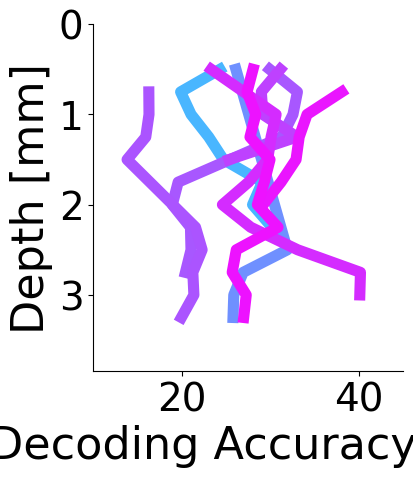

In [194]:
depth_scores_by_site = []
fig, ax =plt.subplots(1,1, figsize=(4,4.5))
site_max_depth = []
site_min_depth = []
site_depth_range = []
xpos_plt = []
chamber_xpos_plt = []
chamber_ypos_plt = []
depth_colors = []
good_sites = []
sites = np.array([column_units[irec]['rec_site'][0] for irec in range(len(column_units))])
xpos = np.array([column_units[irec]['rec_rcaxis'][0] for irec in range(len(column_units))])[np.argsort(sites)]
chamber_xpos = np.array([column_units[irec]['rec_xpos'][0] for irec in range(len(column_units))])[np.argsort(sites)]
chamber_ypos = np.array([column_units[irec]['rec_ypos'][0] for irec in range(len(column_units))])[np.argsort(sites)]
for isite, site in enumerate(list(depth_group_info_by_site.keys())):
    temp_depth_scores = np.array([lda_results[align_event]['pseudopopulations']['depth_scores_by_site_event'][site][igroup] for igroup in range(len(lda_results[align_event]['pseudopopulations']['depth_scores_by_site_event'][site])-1)])
    depth_score_max = [100*np.mean(temp_depth_scores[idepth,:]) for idepth in range(temp_depth_scores.shape[0])] # # Check this after event
    
    if np.sum(np.isnan(depth_score_max)) < 8:
        depth_nan_mask = ~np.isnan(depth_score_max)
        ax.plot(np.array(depth_score_max)[depth_nan_mask], (np.mean(pseudopopulation_metadata['depth_ranges'], axis=1)[:-1]/1000)[depth_nan_mask], color=column_colors[np.argsort(sites)[isite]])
        ax.set(xlabel='Decoding Accuracy [%]', ylabel='Depth [mm]', xlim=(10, 45), ylim=(0, 3.840))
        ax.invert_yaxis()
        start_idx = np.where(~np.isnan(depth_score_max))[0][0]
        end_idx = np.where(~np.isnan(depth_score_max))[0][-1]
        site_depth_range.append(depth_score_max[start_idx] - depth_score_max[end_idx])
        # site_max_depth.append(np.mean(pseudopopulation_metadata['depth_ranges'], axis=1)[np.argmax(depth_score_max)])
        # site_min_depth.append(np.mean(pseudopopulation_metadata['depth_ranges'], axis=1)[np.argmin(depth_score_max)])
        xpos_plt.append(xpos[isite])
        good_sites.append(site)
        chamber_xpos_plt.append(chamber_xpos[isite])
        chamber_ypos_plt.append(chamber_ypos[isite])
        # print(site,np.mean(pseudopopulation_metadata['depth_ranges'], axis=1)[np.argmax(depth_score_max)])
        depth_colors.append(column_colors[np.argsort(sites)[isite]])
        

aopy.visualization.savefig(base_save_dir, f'{subject}lda_depth_by_site.svg')

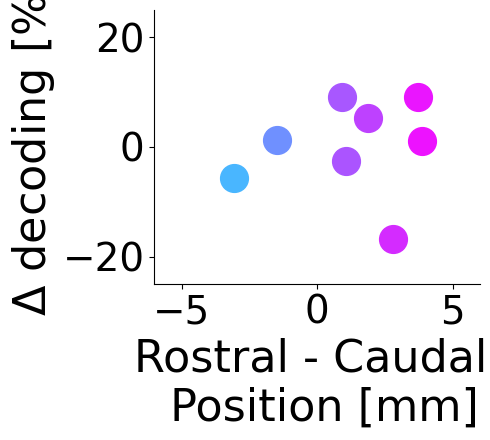

In [120]:
fig, ax = plt.subplots(1,1,figsize=(5,4.5))
[ax.plot(xpos_plt[icol],site_depth_range[icol],'.', markersize=40, color=depth_colors[icol]) for icol in range(len(depth_colors))]
# ax[1].plot(xpos_plt, site_min_depth,'.')
# ax[1].legend(['max','min'])
# ax[1].invert_yaxis()
ax.set(xlabel='Rostral - Caudal \n Position [mm]', ylabel='$\Delta$ decoding [%]', xlim=(-6,6), ylim=(-25,25))
# ax.set(title='Superficial vs. Deep \n Decoding Change')
fig.tight_layout()
aopy.visualization.savefig(base_save_dir, f'{subject}_lda_depth_dec_diff.svg')

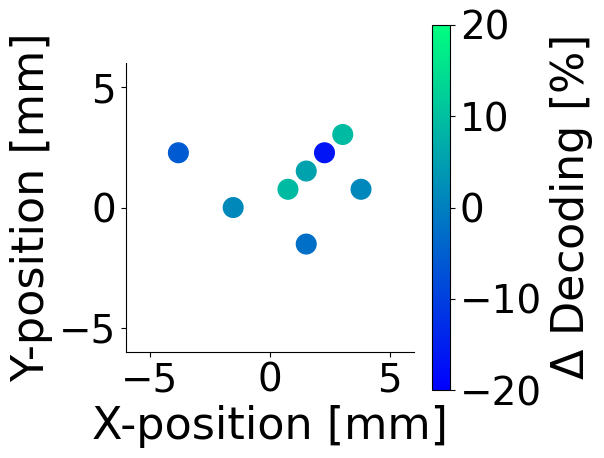

In [121]:
## Plot spatial map of decoding
align_event = align_events[-1]
fig, ax = plt.subplots(1,1,figsize=(6,5))
colors = site_depth_range

dec_map = ax.scatter(np.array(chamber_xpos_plt), np.array(chamber_ypos_plt), s=200, c=colors, cmap='winter', vmin=-20, vmax=20)
cb = plt.colorbar(dec_map, label='$\Delta$ Decoding [%]')
# cb.set_ticks([0.1,.5])
ax.set(xlim=(-6,6), ylim=(-6,6), xlabel='X-position [mm]', ylabel='Y-position [mm]')
plt.gca().set_aspect("equal")
fig.tight_layout()
aopy.visualization.savefig(base_save_dir, f'{subject}_lda_np_spatial_map_depth.svg')

In [ ]:
# # depth_idx = np.where(groups_of_nunits_all_recs == ndepthunits)[0][0]
# for site in recording_site:
#     for align_event in align_events:
#         if align_event == align_events[-1]:
#             unit_adding_scores = [np.mean(lda_results[align_event]['unit_adding']['scores'][igroup], axis=1) for igroup in range(len(lda_results[align_event]['unit_adding']['scores']))]
#             depth_scores = [np.mean(lda_results[align_event]['pseudopopulations']['depth_scores_by_site'][site][igroup], axis=1) for igroup in range(len(lda_results[align_event]['pseudopopulations']['depth_scores_by_site'][site]))]
#             depth_scores_std = [np.std(lda_results[align_event]['pseudopopulations']['depth_scores_by_site'][site][igroup], axis=1) for igroup in range(len(lda_results[align_event]['pseudopopulations']['depth_scores_by_site'][site]))]
#             depth_scores_max = [np.max(lda_results[align_event]['pseudopopulations']['depth_scores_by_site'][site][igroup], axis=1) for igroup in range(len(lda_results[align_event]['pseudopopulations']['depth_scores_by_site'][site]))]
#             depth_scores_min = [np.min(lda_results[align_event]['pseudopopulations']['depth_scores_by_site'][site][igroup], axis=1) for igroup in range(len(lda_results[align_event]['pseudopopulations']['depth_scores_by_site'][site]))]
#             fig, ax = plt.subplots(1,3,figsize=(13,3.5))
        
#             [ax[0].plot(preproc_metadata['trial_time_axis'], np.vstack(depth_scores)[igroup,:], color=depth_color_grad[igroup])  for igroup in range(len(lda_results[align_event]['pseudopopulations']['depth_scores_by_site'][site]))]
#             # ax[0].plot(preproc_metadata['trial_time_axis'], np.vstack(unit_adding_scores)[depth_idx,:], 'k')
#             ax[0].legend([column_units[igroup]['rec_site'][0] for igroup in range(len(column_units))], bbox_to_anchor=(1,1))
#             ax[0].set(xlabel='Time [s]', ylabel='Decoding Accuracy', ylim=(0.125,.8), title=align_event)
#             ax[0].legend(pseudopopulation_metadata['depth_ranges'], bbox_to_anchor=(1,1))
#             # for igroup in range(len(lda_results[align_event]['pseudopopulations']['depth_scores'])):
#             #     ax[0].fill_between(preproc_metadata['trial_time_axis'][nlda_lags:], depth_scores[igroup]+depth_scores_std[igroup],depth_scores[igroup], alpha=0.5, color=f"C{igroup}")
#             #     ax[0].fill_between(preproc_metadata['trial_time_axis'][nlda_lags:], depth_scores[igroup]-depth_scores_std[igroup],depth_scores[igroup], alpha=0.5, color=f"C{igroup}")
        
            
#             depth_mean = np.mean(np.vstack(depth_scores), axis=0)
#             depth_std = np.mean(np.vstack(depth_scores_std), axis=0)
#             depth_max = np.mean(np.vstack(depth_scores_max), axis=0)
#             depth_min = np.mean(np.vstack(depth_scores_min), axis=0)
#             ax[1].plot(np.nanmax(np.vstack(depth_scores)[:,trelevant1:trelevant2],axis=1), np.mean(pseudopopulation_metadata['depth_ranges'], axis=1), color='firebrick') 
#             ax[1].set(xlabel='Decoding Accuracy', ylabel='Depth', xlim=(0.3, 0.8))
#             # ax[1].plot([np.nanmax(np.vstack(unit_adding_scores)[depth_idx,trelevant1:trelevant2]), np.nanmax(np.vstack(unit_adding_scores)[depth_idx,trelevant1:trelevant2])], ax[1].get_ylim(), 'k')
#             ax[1].legend(['Depth', 'random'])
#             ax[1].invert_yaxis()
#             # ax[1].plot(preproc_metadata['trial_time_axis'], np.nanmean(depth_scores, axis=0), color='k')
#             # ax[1].fill_between(preproc_metadata['trial_time_axis'], depth_mean+depth_std, depth_mean, color='k', alpha=0.5)
#             # ax[1].fill_between(preproc_metadata['trial_time_axis'], depth_mean-depth_std, depth_mean, color='k', alpha=0.5)
        
        
#             for igroup in range(len(lda_results[align_event]['pseudopopulations']['depth_scores_by_site'][isite])):
#                 ax[2].plot(preproc_metadata['trial_time_axis'], np.vstack(depth_scores)[igroup,:], color=depth_color_grad[igroup])
#                 ax[2].fill_between(preproc_metadata['trial_time_axis'], np.vstack(depth_scores_max)[igroup,:], np.vstack(depth_scores)[igroup,:], color=depth_color_grad[igroup], alpha=0.25)
#                 ax[2].fill_between(preproc_metadata['trial_time_axis'], np.vstack(depth_scores_min)[igroup,:], np.vstack(depth_scores)[igroup,:], color=depth_color_grad[igroup], alpha=0.25)
#             ax[2].set(title=f"{align_event} - {niterations} iteration envelope")
            
#             plt.suptitle(f"Column-based Unit Groups {align_event}")
#             fig.tight_layout()
#             plt.show()

#### High decoding Units

In [ ]:
# fig, ax = plt.subplots(1,3,figsize=(10,3))
# for ievent, align_event in enumerate(align_events):
#     ax[ievent].plot(preproc_metadata['trial_time_axis'], lda_results[align_event]['pseudopopulations']['high_dec_scores'])
#     ax[ievent].set(xlabel='Time [s]', ylabel='Decoding Accuracy', title=f"{align_event} - Top {nimportant_units} Units", ylim=(0.125, 1))

# fig.tight_layout()
# plt.show()

In [ ]:
# # Waveforms of high decoding units
# fig, ax = plt.subplots(1,nimportant_units, figsize=(nimportant_units*2,2))
# for iunit in range(nimportant_units):
#     ax[iunit].plot(high_decoding_units[-1]['waveform'][iunit])
#     ax[iunit].set(xlabel='Time', ylabel='$\mu$V', ylim=(-200, 250), title=f"Site: {high_decoding_units[-1]['rec_site'][iunit]}")
    
# fig.tight_layout()
# plt.show()

In [ ]:
# # Waveforms of low decoding units
# fig, ax = plt.subplots(1,nimportant_units, figsize=(nimportant_units*2,2))
# for iunit in range(nimportant_units):
#     ax[iunit].plot(low_decoding_units[-1]['waveform'][iunit])
#     ax[iunit].set(xlabel='Time', ylabel='$\mu$V', ylim=(-200, 250), title=f"Site: {low_decoding_units[-1]['rec_site'][iunit]}")
    
# fig.tight_layout()
# plt.show()

In [ ]:
    # # Plot FR vs. time traces of the 10 highest weighted neurons
    # avg_fr_each_trial = np.mean(rasters['neural'][align_event][irec][:,:,stable_unit_idx[irec]], axis=0)
    # smooth_avg_fr_each_trial = aopy.analysis.base.calc_rolling_average(avg_fr_each_trial, window_size=17)
    
    # nunits_plot = 8
    # fig, ax = plt.subplots(1,nunits_plot, figsize=(nunits_plot*1.6,2))
    # for iunit in range(nunits_plot):
    #     ax[iunit].plot(smooth_avg_fr_each_trial[:ntest_trials,unit_rank[iunit]])
    #     ax[iunit].set(xlabel='Trial', ylabel='Firing rate', title=f"Unit: {stable_unit_labels[irec][unit_rank[iunit]]}")

    # plt.suptitle(f"Recording {recording_site[irec]} - High weight units")
    # fig.tight_layout()
    # plt.show()

### Trial adding

In [ ]:
# Plot number of stable units as a function of trials for each align_event and recording
### Move to unit quality notebook
# for align_event in align_events:
#     fig, ax = plt.subplots(1,3,figsize=(10,3))
#     for irec in range(nrecs):
#         nstable_units_temp = [len(stable_unit_idx_nunits_tradd[align_event][itradd][irec]) for itradd in range(ntrial_adding_bins)]
#         ax[0].plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, nstable_units_temp, color=day_colors[irec])
#         if recording_site[irec] in recording_brain_areas['M1']:
#             ax[1].plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, nstable_units_temp, color=day_colors[irec])
#         elif recording_site[irec] in recording_brain_areas['PM']:
#             ax[2].plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, nstable_units_temp, color=day_colors[irec])
#     [iax.set(xlabel='Trials', ylabel='Number of Stable Units') for iax in ax]
#     plt.suptitle(f"{align_event} - Neurons active on {100*min_trial_prop}% of trials")
#     fig.tight_layout()
#     plt.show()

In [ ]:
# for iax, align_event in enumerate(align_events):
#     fig, ax = plt.subplots(1,3, figsize=(10,3))
#     ax[0].plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, lda_results_tradd[align_event]['neural_max_pcc_pval'])
#     ax[1].plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, lda_results_tradd[align_event]['neural_max_pcc_pval_M1'])
#     ax[2].plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, lda_results_tradd[align_event]['neural_max_pcc_pval_PM'])
    
#     ax[0].set(xlabel="Trials", ylabel="pvalue", title='All Recordings')
#     ax[1].set(xlabel="Trials", ylabel="pvalue", title="M1")
#     ax[2].set(xlabel="Trials", ylabel="pvalue", title="PM")
    
#     ax0_twinx = ax[0].twinx()
#     ax0_twinx.plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, np.squeeze([lda_results_tradd[align_event]['neural_max_reg_fit'][itradd].coef_ for itradd in range(ntrial_adding_bins)]), 'k')
#     ax0_twinx.set(ylabel='Slope (black)')
    
#     ax1_twinx = ax[1].twinx()
#     ax1_twinx.plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, np.squeeze([lda_results_tradd[align_event]['neural_max_reg_fit_M1'][itradd].coef_ for itradd in range(ntrial_adding_bins)]), 'k')
#     ax1_twinx.set(ylabel='Slope (black)')
    
#     ax2_twinx = ax[2].twinx()
#     ax2_twinx.plot(np.arange(1,ntrial_adding_bins+1)*ntrial_bin_size, np.squeeze([lda_results_tradd[align_event]['neural_max_reg_fit_PM'][itradd].coef_ for itradd in range(ntrial_adding_bins)]), 'k')
#     ax2_twinx.set(ylabel='Slope (black)')
    
#     plt.suptitle(f"{align_event}")
#     fig.tight_layout()
#     plt.show()

### Unit adding

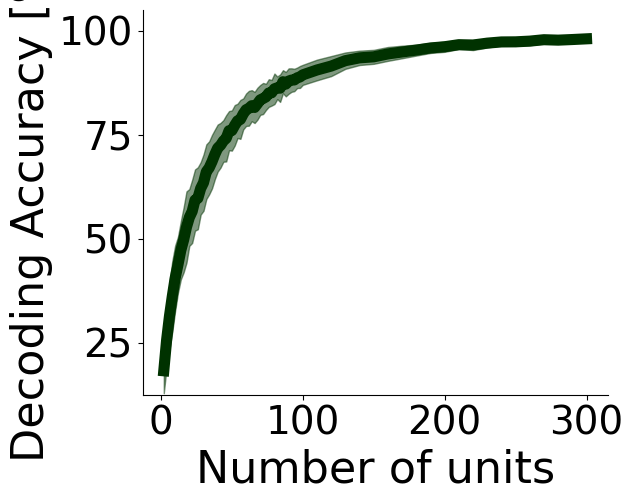

In [88]:
# for align_event in align_events:
align_event = align_events[-1]
affi_color = [0,0.19607,0]
unit_adding_scores_event = 100*np.mean(np.array(lda_results[align_event]['unit_adding']['scores_event']), axis=1)
unit_adding_std_event = 100*np.std(np.array(lda_results[align_event]['unit_adding']['scores_event']), axis=1)
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.fill_between(groups_of_nunits_all_recs, unit_adding_scores_event - unit_adding_std_event, unit_adding_scores_event + unit_adding_std_event, color=affi_color, alpha=0.5)
ax.plot(groups_of_nunits_all_recs, unit_adding_scores_event, color=affi_color)
ax.set_xticks([0,100,200,300])
ax.set(xlabel='Number of units', ylabel='Decoding Accuracy [%]',  ylim=(12.5,105))
aopy.visualization.savefig(base_save_dir, f'{subject}_lda_decoding_unit_adding_all_units{align_event}_event.svg')

  0%|          | 0/19 [00:00<?, ?it/s]

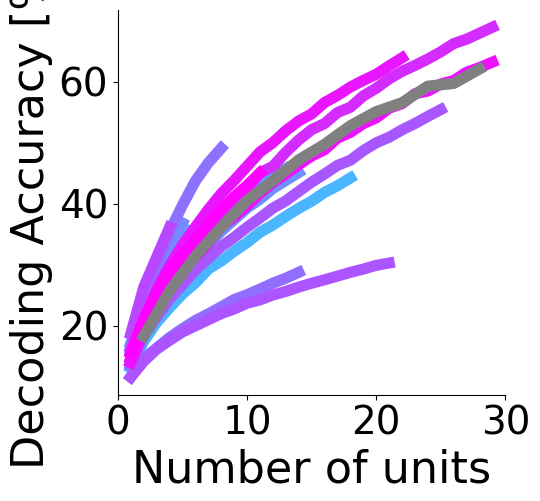

In [109]:
# for align_event in align_events:
align_event = align_events[-1]
fig, ax = plt.subplots(1,1,figsize=(5,5))
# For each recording location
for igroup in tqdm(range(len(column_units))):

    unit_adding_scores_rec = np.mean(np.array(lda_results[align_event]['unit_adding']['scores_recording'][igroup]), axis=(1,2))*100
    unit_adding_std_rec = np.std(np.array(lda_results[align_event]['unit_adding']['scores_recording'][igroup]), axis=(1,2))*100    
    ax.plot(groups_of_nunits[:len(unit_adding_scores_rec)], unit_adding_scores_rec, color=column_colors[igroup])
    
ax.plot(groups_of_nunits_all_recs[np.where(groups_of_nunits_all_recs < np.max(groups_of_nunits))[0]], unit_adding_scores_event[np.where(groups_of_nunits_all_recs < np.max(groups_of_nunits))[0]], color=(0.5,0.5,0.5))
ax.set(xlabel='Number of units', ylabel='Decoding Accuracy [%] ', xlim=(0,30))
aopy.visualization.savefig(base_save_dir, f'{subject}_lda_column_unit_add_{align_event}.svg')

KeyError: 'scores'

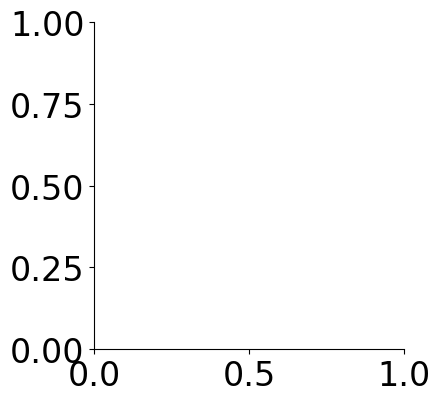

In [525]:
# for align_event in align_events:
align_event = align_events[-1]
fig, ax = plt.subplots(1,1,figsize=(4,4.25))
unit_adding_scores = [100*np.mean(lda_results[align_event]['unit_adding']['scores'][igroup], axis=1) for igroup in range(len(lda_results[align_event]['unit_adding']['scores']))]
# For each recording location
for igroup in tqdm(range(len(column_units))):

    unit_adding_scores_rec = [100*np.mean(lda_results[align_event]['unit_adding']['scores_recording'][igroup][iunit_group], axis=1) for iunit_group in range(len(lda_results[align_event]['unit_adding']['scores_recording'][igroup]))]
    unit_adding_std_rec = [100*np.std(lda_results[align_event]['unit_adding']['scores_recording'][igroup][iunit_group], axis=1) for iunit_group in range(len(lda_results[align_event]['unit_adding']['scores_recording'][igroup]))]
    unit_adding_max_rec = [100*np.max(lda_results[align_event]['unit_adding']['scores_recording'][igroup][iunit_group], axis=1) for iunit_group in range(len(lda_results[align_event]['unit_adding']['scores_recording'][igroup]))]
    unit_adding_min_rec = [100*np.min(lda_results[align_event]['unit_adding']['scores_recording'][igroup][iunit_group], axis=1) for iunit_group in range(len(lda_results[align_event]['unit_adding']['scores_recording'][igroup]))]

    tempx = []
    tempy = []
    tempstd = []
    tempmax = []
    tempmin = []
    for iunit_group in range(len(unit_adding_scores_rec)):
        tempx.append(groups_of_nunits[iunit_group])
        max_idx = np.argmax(unit_adding_scores_rec[iunit_group][trelevant1:trelevant2]) + trelevant1
        tempy.append(unit_adding_scores_rec[iunit_group][max_idx])
        tempstd.append(unit_adding_std_rec[iunit_group][max_idx])
        tempmax.append(unit_adding_max_rec[iunit_group][max_idx])
        tempmin.append(unit_adding_min_rec[iunit_group][max_idx])
    if column_units[igroup]['rec_site'][0] == 0:
        ax.plot(tempx, tempy, color='k')
    else:
        ax.plot(tempx, tempy, color=column_colors[igroup])
    
ax.plot(groups_of_nunits_all_recs_time, np.max(np.vstack(unit_adding_scores)[:,trelevant1:trelevant2], axis=1)[:len(groups_of_nunits)], color=(0.5,0.5,0.5))
ax.set(xlabel='Number of units', ylabel='Decoding Accuracy [%] ', xlim=(0,30))
aopy.visualization.savefig(base_save_dir, f'{subject}_lda_column_unit_add_{align_event}.svg')

In [ ]:
# for align_event in align_events:
align_event = align_events[-1]
fig, ax = plt.subplots(1,3,figsize=(12,4.5))
unit_adding_scores = [100*np.mean(lda_results[align_event]['unit_adding']['scores'][igroup], axis=1) for igroup in range(len(lda_results[align_event]['unit_adding']['scores']))]
# For each recording location
for igroup in tqdm(range(len(column_units))):

    unit_adding_scores_rec = [100*np.mean(lda_results[align_event]['unit_adding']['scores_recording'][igroup][iunit_group], axis=1) for iunit_group in range(len(lda_results[align_event]['unit_adding']['scores_recording'][igroup]))]
    unit_adding_std_rec = [100*np.std(lda_results[align_event]['unit_adding']['scores_recording'][igroup][iunit_group], axis=1) for iunit_group in range(len(lda_results[align_event]['unit_adding']['scores_recording'][igroup]))]
    unit_adding_max_rec = [100*np.max(lda_results[align_event]['unit_adding']['scores_recording'][igroup][iunit_group], axis=1) for iunit_group in range(len(lda_results[align_event]['unit_adding']['scores_recording'][igroup]))]
    unit_adding_min_rec = [100*np.min(lda_results[align_event]['unit_adding']['scores_recording'][igroup][iunit_group], axis=1) for iunit_group in range(len(lda_results[align_event]['unit_adding']['scores_recording'][igroup]))]

    tempx = []
    tempy = []
    tempstd = []
    tempmax = []
    tempmin = []
    for iunit_group in range(len(unit_adding_scores_rec)):
        tempx.append(groups_of_nunits[iunit_group])
        max_idx = np.argmax(unit_adding_scores_rec[iunit_group][trelevant1:trelevant2]) + trelevant1
        tempy.append(unit_adding_scores_rec[iunit_group][max_idx])
        tempstd.append(unit_adding_std_rec[iunit_group][max_idx])
        tempmax.append(unit_adding_max_rec[iunit_group][max_idx])
        tempmin.append(unit_adding_min_rec[iunit_group][max_idx])

    ax[0].plot(tempx, tempy, color=column_colors[igroup])
    ax[1].plot(tempx, tempy, color=column_colors[igroup])
    ax[1].fill_between(tempx, np.array(tempy)+np.array(tempstd), tempy, alpha=0.5, color=column_colors[igroup])
    ax[1].fill_between(tempx, np.array(tempy)-np.array(tempstd), tempy, alpha=0.5, color=column_colors[igroup])
    ax[2].fill_between(tempx, tempmax, tempmin, alpha=0.5)
    
ax[0].plot(groups_of_nunits_all_recs_time, np.max(np.vstack(unit_adding_scores)[:,trelevant1:trelevant2], axis=1)[:len(groups_of_nunits)], color=(0.5,0.5,0.5))
plt.suptitle(f"{align_event}")
ax[0].set(xlabel='Number of units', ylabel='Decoding \n Accuracy [%] ', xlim=(0,30))
ax[1].set(xlabel='Number of units', ylabel='Decoding Accuracy', title='Mean +/- std')
ax[2].set(xlabel='Number of units', ylabel='Decoding Accuracy', title='Max - min envelope')
fig.tight_layout()
aopy.visualization.savefig(base_save_dir, f'{subject}_lda_column_unit_add_{align_event}.svg')

### Spike band power

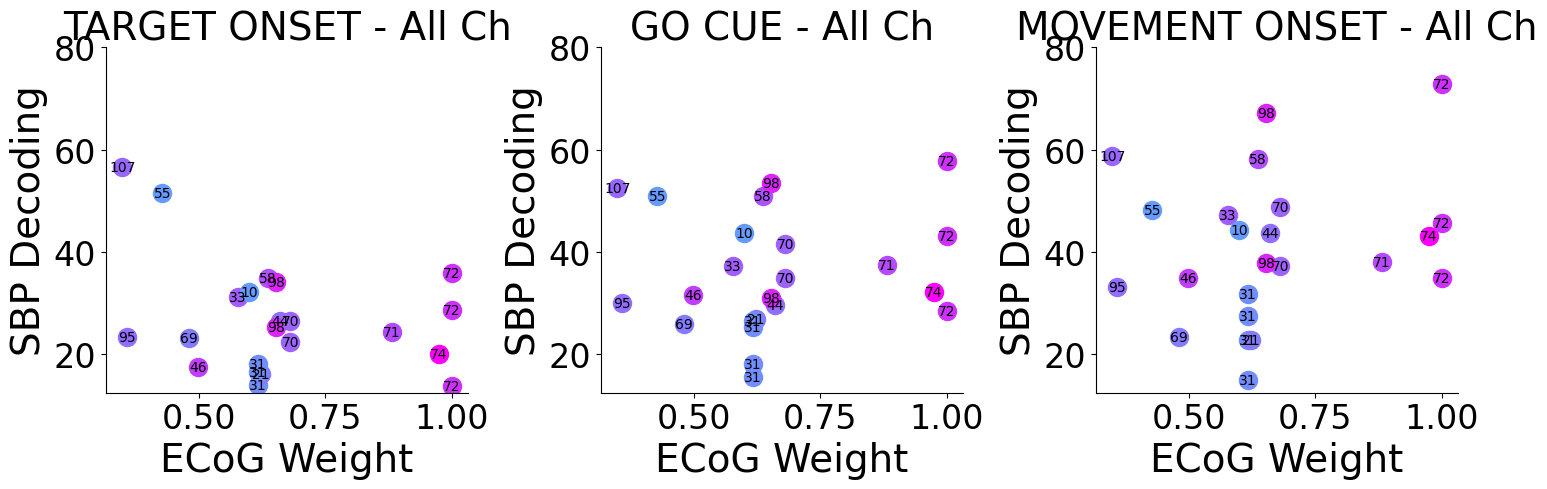

In [323]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
for ievent, align_event in enumerate(align_events):
    max_scores = np.array([np.mean(lda_results[align_event]['sbp']['scores_event'][irec]) for irec in range(nrecs)])
    [ax[ievent].plot(ecog_dec_acc_rec_site[align_event][irec]/np.nanmax(ecog_dec_acc_rec_site[align_event]), 100*max_scores[irec], '.', markersize=26, color=day_colors[irec]) for irec in range(nrecs)]
    [ax[ievent].annotate(f"{recording_site[irec]}", (ecog_dec_acc_rec_site[align_event][irec]/np.nanmax(ecog_dec_acc_rec_site[align_event]), 100*max_scores[irec]), ha='center', va='center') for irec in range(nrecs)]
    ax[ievent].set(xlabel='ECoG Weight', ylabel='SBP Decoding', title=f"{align_event} - All Ch", ylim=(12.5, 80))
fig.tight_layout()
plt.show()

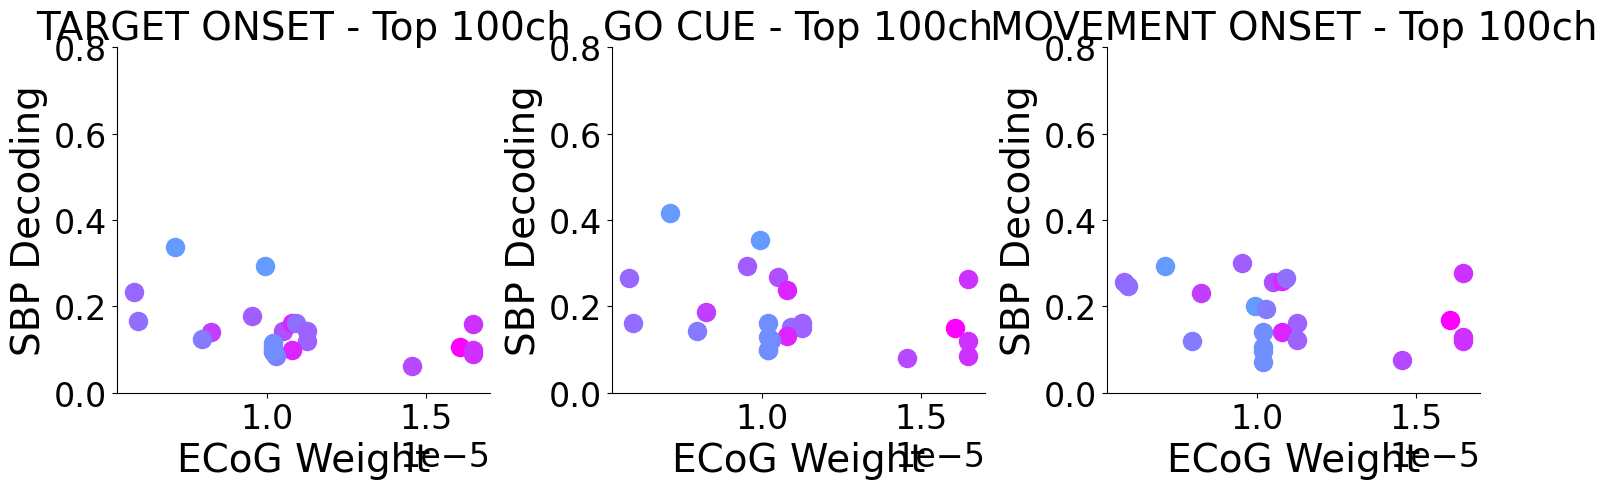

In [317]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
for ievent, align_event in enumerate(align_events):
    max_scores = np.array([np.mean(lda_results[align_event]['sbp']['scores_top_ch_event'][irec]) for irec in range(nrecs)])
    [ax[ievent].plot(ecog_dec_acc_rec_site[align_event][irec], max_scores[irec], '.', markersize=26, color=day_colors[irec]) for irec in range(nrecs)]
    ax[ievent].set(xlabel='ECoG Weight', ylabel='SBP Decoding', title=f"{align_event} - Top {nsbp_ch}ch", ylim=(0, .8))
fig.tight_layout()
plt.show()

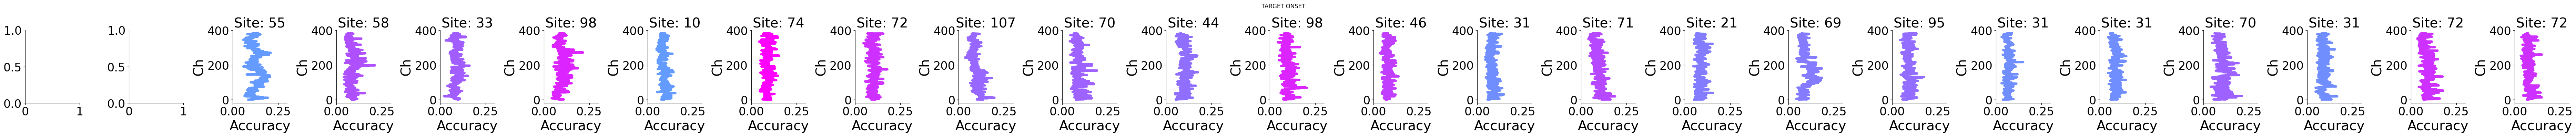

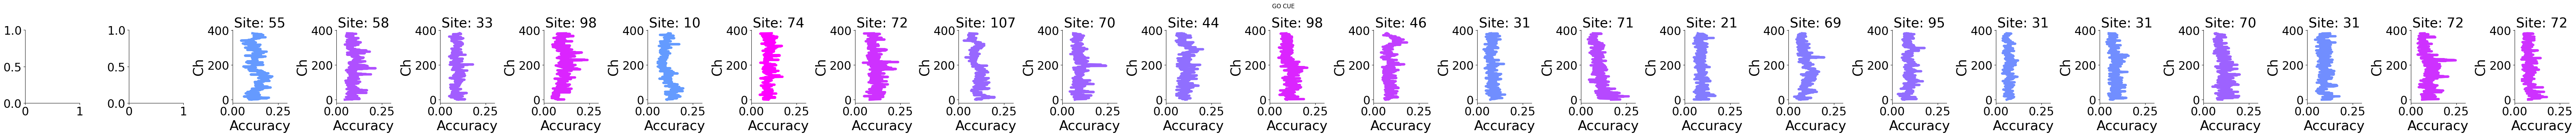

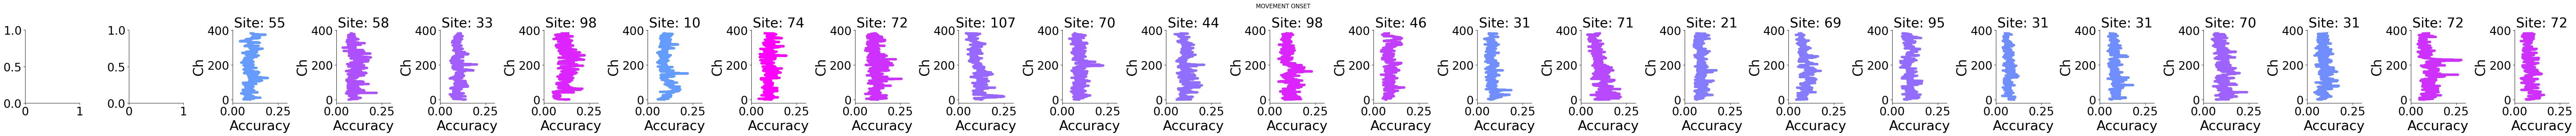

In [318]:
for align_event in align_events:
    fig, ax = plt.subplots(1,nrecs, figsize=(nrecs*3,4))
    for irec in range(nrecs):
        if ~np.isnan(lda_results[align_event]['sbp']['single_ch_decoding_event'][irec]).any():
            ax[irec].plot(np.mean(lda_results[align_event]['sbp']['single_ch_decoding_event'][irec],axis=1), np.arange(384), color=day_colors[irec])
            ax[irec].set(title=f"Site: {recording_site[irec]}", xlabel='Accuracy', ylabel='Ch', xlim=(0,0.3))

        
    plt.suptitle(f"{align_event}")
    fig.tight_layout()
    plt.show()

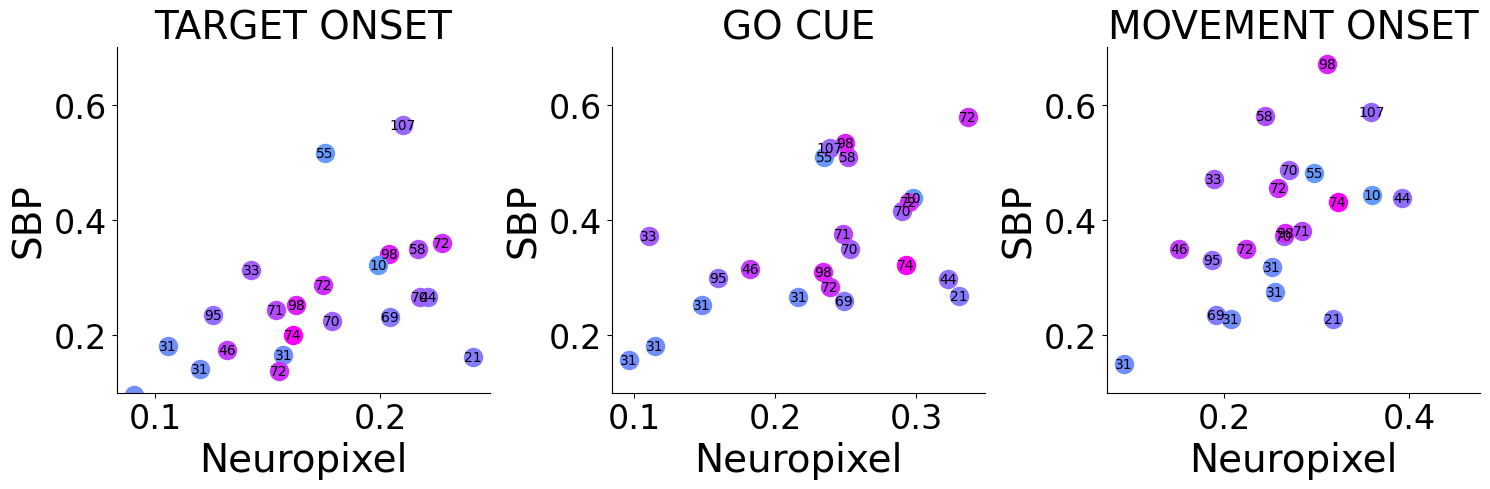

In [319]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
for ievent, align_event in enumerate(align_events):
    max_scores = np.array([np.mean(lda_results[align_event]['sbp']['scores_event'][irec]) for irec in range(nrecs)])
    [ax[ievent].plot(np.array(lda_results[align_event]['neural_space_max'])[irec], max_scores[irec], '.', markersize=26, color=day_colors[irec]) for irec in range(nrecs)]
    [ax[ievent].annotate(f"{recording_site[irec]}", (np.array(lda_results[align_event]['neural_space_max'])[irec], max_scores[irec]), ha='center', va='center') for irec in range(nrecs)]

    ax[ievent].set(xlabel='Neuropixel', ylabel='SBP', title=f"{align_event}", ylim=(0.1,.7))
fig.tight_layout()
plt.show()

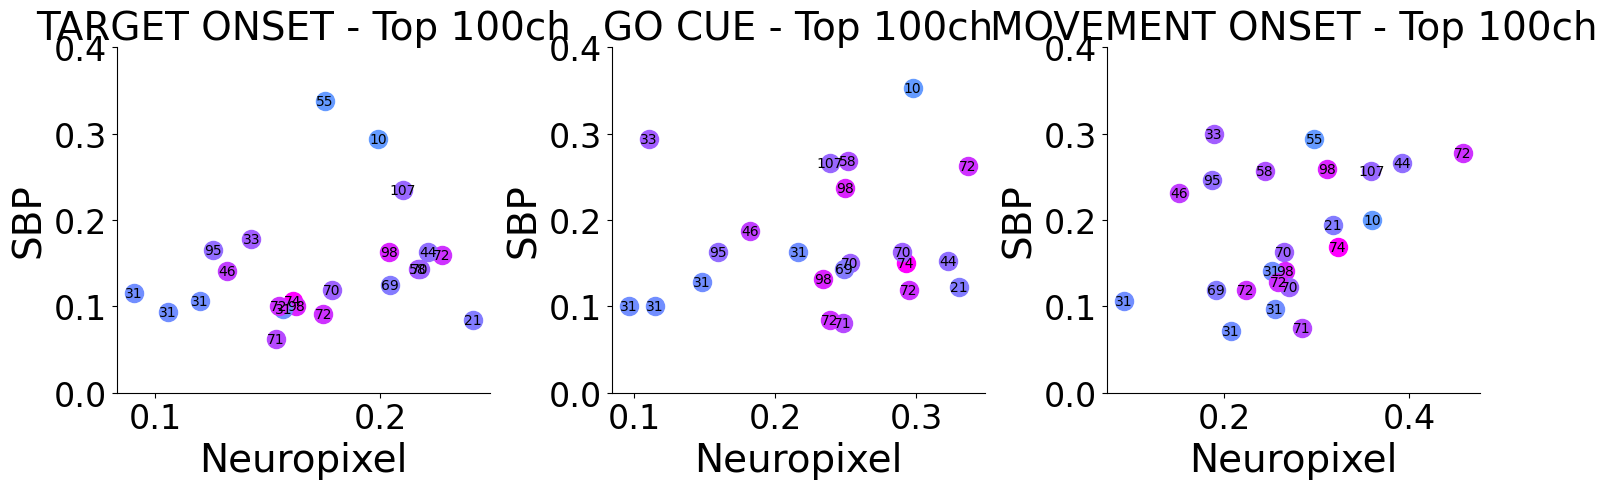

In [320]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
for ievent, align_event in enumerate(align_events):
    max_scores = np.array([np.mean(lda_results[align_event]['sbp']['scores_top_ch_event'][irec]) for irec in range(nrecs)])
    [ax[ievent].plot(np.array(lda_results[align_event]['neural_space_max'])[irec], max_scores[irec], '.', markersize=26, color=day_colors[irec]) for irec in range(nrecs)]
    [ax[ievent].annotate(f"{recording_site[irec]}", (np.array(lda_results[align_event]['neural_space_max'])[irec], max_scores[irec]), ha='center', va='center') for irec in range(nrecs)]

    ax[ievent].set(xlabel='Neuropixel', ylabel='SBP', title=f"{align_event} - Top {nsbp_ch}ch", ylim=(0,.4))
fig.tight_layout()
plt.show()

### LFP Power

NameError: name 'nbands' is not defined

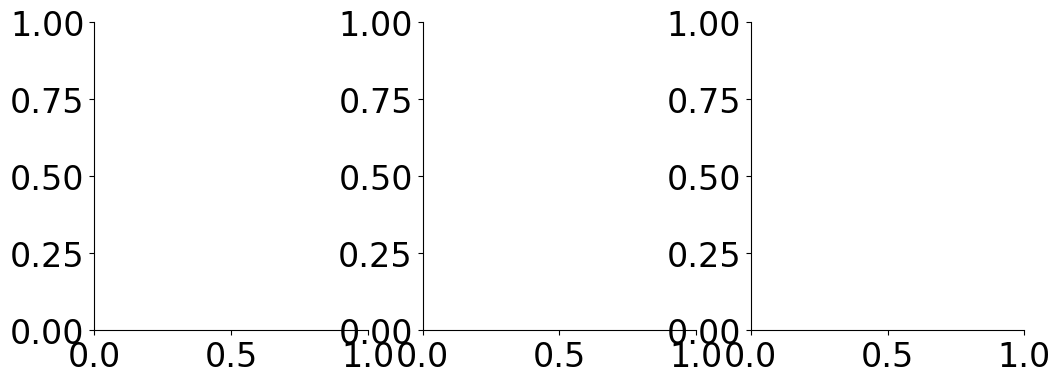

In [321]:
fig, ax = plt.subplots(1,3,figsize=(12,4))
for ievent, align_event in enumerate(align_events):
    for iband in range(nbands):
        ax[ievent].errorbar(iband, np.mean(lda_results[align_event]['lfp'][iband]['all_units_score']), yerr=np.std(lda_results[align_event]['lfp'][iband]['all_units_score']))
        ax[ievent].plot(iband, np.mean(lda_results[align_event]['lfp'][iband]['all_units_score']), 'k.', markersize=10)
        
    ax[ievent].set(xlabel='Freq Band', ylabel='Accuracy', title=f"{align_event}", ylim=(0.1, 0.6))
    ax[ievent].set_xticks(np.arange(nbands), np.arange(nbands))
fig.tight_layout()
plt.show()

In [ ]:
# # All channels for each recording site
# for iband in range(nbands):
#     fig, ax = plt.subplots(1,len(align_events), figsize=(len(align_events)*4, 3))
#     for ievent, align_event in enumerate(align_events):
#         for irec in range(nrecs):
#             ax[ievent].plot(preproc_metadata['trial_time_axis'], np.mean(lda_results[align_event]['lfp'][iband]['all_units_score'][irec], axis=1), color=day_colors[irec])
#             ax[ievent].set(xlabel='Time [s]', ylabel='Decoding Accuracy', title=f"{align_event}", ylim=(0.125, 0.9))
#     fig.tight_layout()
#     plt.show()

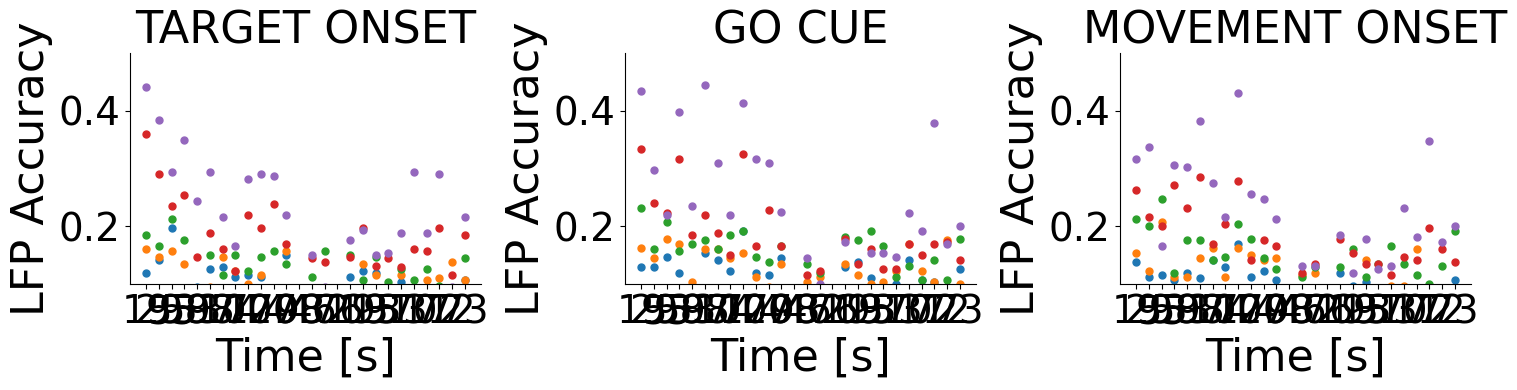

In [158]:
fig, ax = plt.subplots(1,3,figsize=(15,4))
for ievent, align_event in enumerate(align_events):
    max_lfp_dec_acc_recs = {}
    for iband in range(nbands):
        max_lfp_dec_acc_recs[iband] = [np.mean(lda_results[align_event]['lfp'][iband]['scores'][irec]) for irec in range(nrecs)]
        [ax[ievent].plot(irec, np.mean(lda_results[align_event]['lfp'][iband]['scores'][irec]), '.', markersize=10, color=f"C{iband}") for irec in range(nrecs)]
        ax[ievent].set(xlabel='Time [s]', ylabel='LFP Accuracy', title=f"{align_event}",ylim=(0.1, .5))
        ax[ievent].set_xticks(np.arange(nrecs), recording_site)
    
fig.tight_layout()
plt.show()

0.9103950096471857
0.07668357805249873
0.2800393382744134
0.6257270239539559
0.47540708982763386


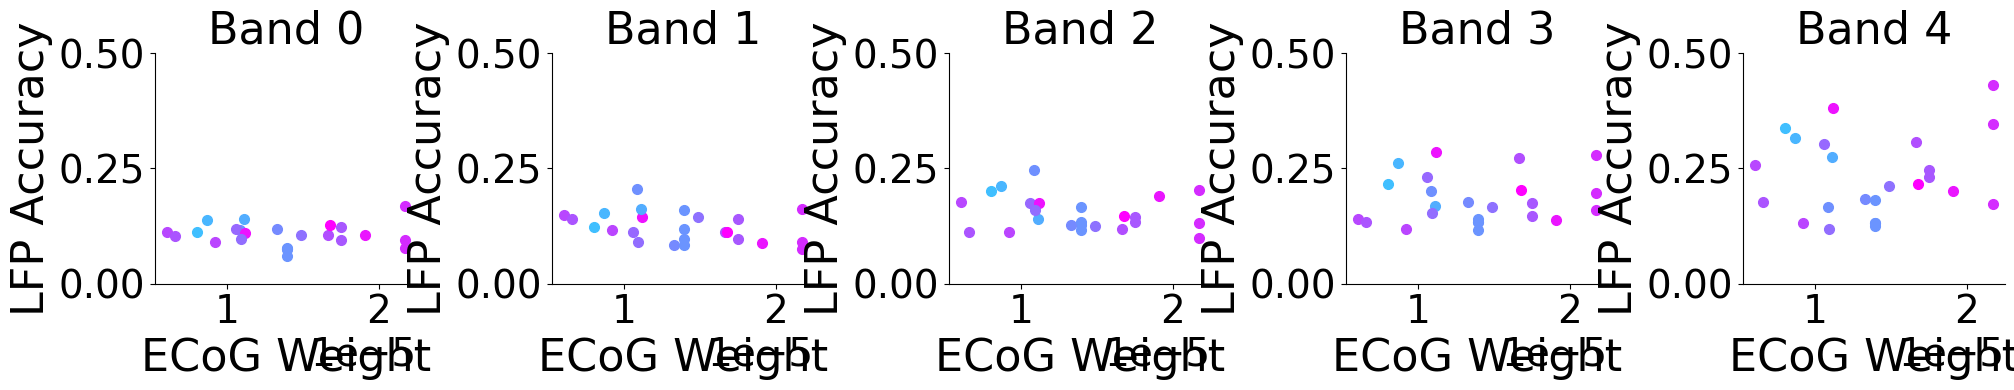

In [159]:
fig, ax = plt.subplots(1,nbands, figsize=(4*nbands,4))
for iband in range(nbands):
    [ax[iband].plot(ecog_dec_acc_rec_site[align_event][irec], max_lfp_dec_acc_recs[iband][irec], '.', markersize=14, color=day_colors[irec]) for irec in range(nrecs)]
    ax[iband].set(xlabel='ECoG Weight', ylabel='LFP Accuracy', title=f"Band {iband}", ylim=(0, 0.5))
    xaxis = np.array(ecog_dec_acc_rec_site[align_event])
    yaxis = 100*np.array(max_lfp_dec_acc_recs[iband])
    _,_,_,pval,regfit = aopy.analysis.base.linear_fit_analysis2D(xaxis[~np.isnan(yaxis)],yaxis[~np.isnan(yaxis)] )
    print(pval)
fig.tight_layout()
plt.show()

In [225]:
irec, np.array(max_lfp_dec_acc_recs[iband])[rec_site_idx]

(5, array([0.38125,     nan]))

p=0.5703, $R^2$=0.0142


/tmp/ipykernel_2516753/3663865790.py:10: RuntimeWarning: Mean of empty slice
  column_scores[irec] = np.nanmean(np.array(max_lfp_dec_acc_recs[iband])[rec_site_idx])


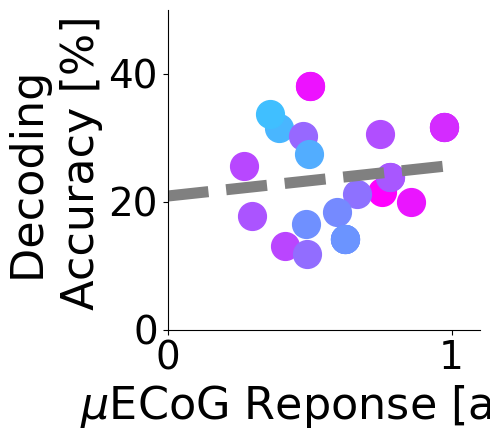

In [241]:
# Decoding accuracy as a function of ecog maps
iband = 4

fig, ax = plt.subplots(1,1,figsize=(5,4.5))
align_event = align_events[-1]
column_scores = np.zeros(nrecs)*np.nan

for irec in range(nrecs):
    rec_site_idx = recording_site == recording_site[irec]
    column_scores[irec] = np.nanmean(np.array(max_lfp_dec_acc_recs[iband])[rec_site_idx])
    
xaxis = np.array(ecog_dec_acc_rec_site[align_event])/np.nanmax(np.array(ecog_dec_acc_rec_site[align_event]))
yaxis = np.array(column_scores)
_,R2,_,pval,regfit = aopy.analysis.base.linear_fit_analysis2D(xaxis[~np.isnan(yaxis)], 100*column_scores[~np.isnan(yaxis)])
[ax.plot(np.array(ecog_dec_acc_rec_site[align_event])[icol]/np.nanmax(np.array(ecog_dec_acc_rec_site[align_event])), 100*column_scores[icol], '.', color=day_colors[icol], markersize=40) for icol in range(nrecs)]
# [ax.annotate(f"{pp_column_sites[icol]}", (np.array(ecog_dec_acc_rec_site_pp[align_event])[icol]/np.nanmax(np.array(ecog_dec_acc_rec_site_pp[align_event])), 100*column_scores[icol]), ha='center', va='center') for icol in range(len(column_scores))]
# [ax.plot(np.array(ecog_dec_acc_rec_site_pp[align_event])[column_site_idx[icol]]/np.max(np.array(ecog_dec_acc_rec_site_pp[align_event])), 100*column_scores[icol], '.', color=column_colors[icol], markersize=30) for icol in range(len(column_scores))]
ax.plot([0, 1], [regfit.intercept_[0],regfit.coef_[0][0]+regfit.intercept_[0]], '--', color=(0.5,0.5,0.5))               
# ax[ievent].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (2e7, 60))
ax.set(xlabel='$\mu$ECoG Reponse [a.u.]', ylabel='Decoding \n Accuracy [%]', ylim=(0,50),xlim=(0,1.1))
print(f"p={np.round(pval,4)}, $R^2$={np.round(R2,4)}")
# if pval < 0.05:
#     ax.annotate('*',(1.05,(2*10)+27), fontsize=30, color=(0.5,0.5,0.5))
# else:
    # ax.annotate(f'p={np.round(pval,2)}',(.75,37), fontsize=32, color=(0.5,0.5,0.5))
    # ax.annotate(f'$R^2$={np.round(R2,2)}',(.75,27), fontsize=32, color=(0.5,0.5,0.5))
    
fig.tight_layout()
aopy.visualization.savefig(base_save_dir, f'{subject}_lda_column_ecog_lfp.svg')

/tmp/ipykernel_2516753/4083745348.py:6: RuntimeWarning: Mean of empty slice
  lfp_scores[recording_site==site] = np.nanmean(lfp_scores[recording_site==site])


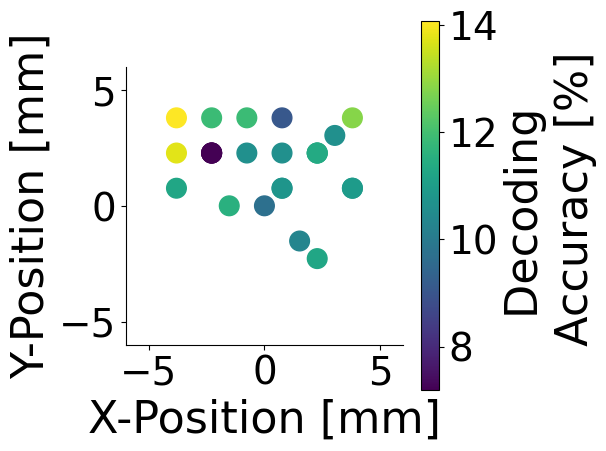

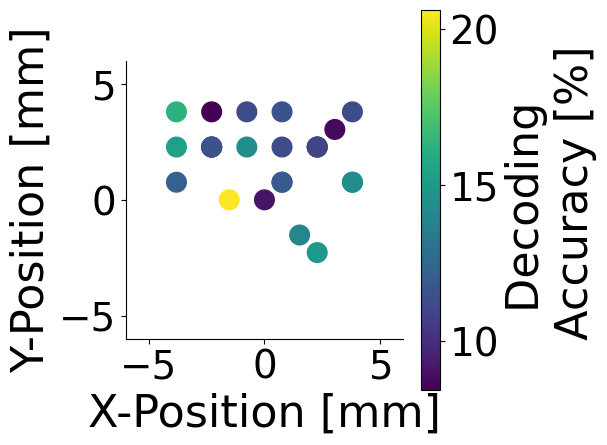

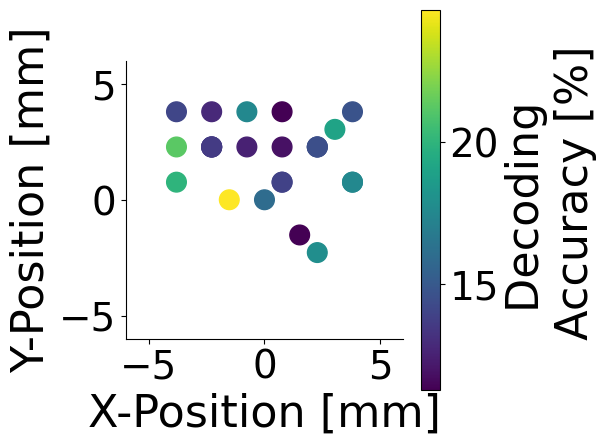

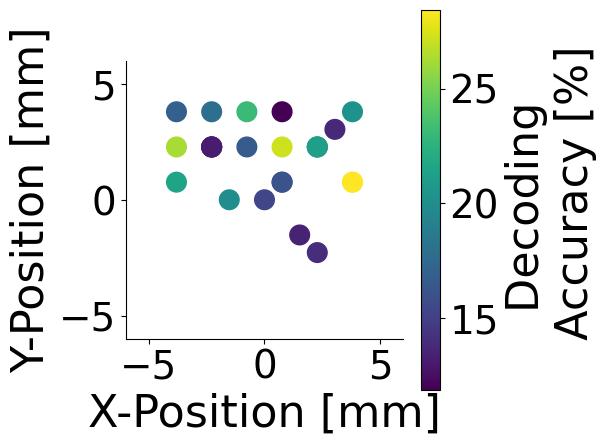

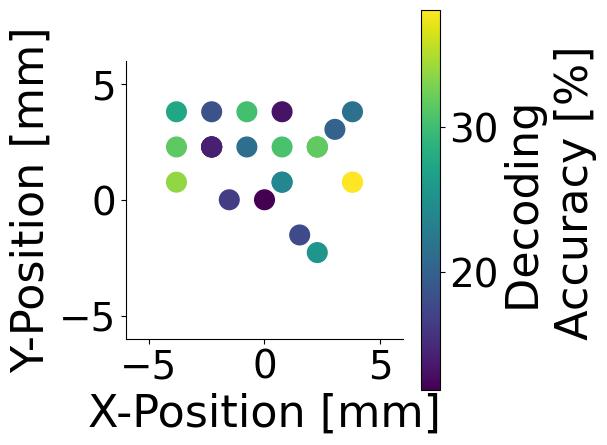

In [240]:
align_event = align_events[-1]
for iband in range(nbands):
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    lfp_scores = np.array([max_lfp_dec_acc_recs[iband][irec] for irec in range(nrecs)])
    for site in recording_site:
        lfp_scores[recording_site==site] = np.nanmean(lfp_scores[recording_site==site])
    dec_map = ax.scatter(ecog_dec_acc[subject]['rec_locations'][:,0], ecog_dec_acc[subject]['rec_locations'][:,1], s=200,c=100*(lfp_scores))
    cb = plt.colorbar(dec_map, label='Decoding \n Accuracy [%]')
    ax.set(xlim=(-6,6), ylim=(-6,6))
    ax.set(xlabel='X-Position [mm]', ylabel='Y-Position [mm]', xlim=(-6,6), ylim=(-6,6))
    # ax.set(title='Superficial vs. Deep \n Decoding Change')
    plt.gca().set_aspect("equal")
    fig.tight_layout()
    aopy.visualization.savefig(base_save_dir, f'{subject}_lda_depth_dec_spatial_map_lfp_band{iband}.svg')

KeyError: 'lfp_single_ch'

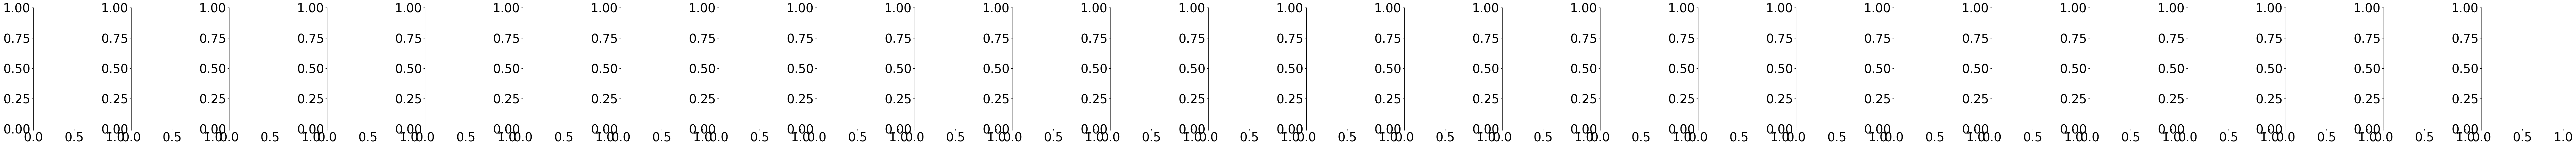

In [161]:
for align_event in align_events:
    fig, ax = plt.subplots(1,nrecs, figsize=(nrecs*4,5))
    for iband in range(nbands):
        for irec in range(nrecs):
            cbdsd = ax[irec].plot(aopy.analysis.base.calc_rolling_average(np.mean(lda_results[align_event]['lfp_single_ch'][iband]['scores'][irec],axis=1), 51), np.arange(384), color=f'C{iband}')
            # cb = plt.colorbar(cbdsd)
            ax[irec].set(title=f"{recording_site[irec]}", xlim=(0.07, 0.15))

        plt.suptitle(f"{align_event}")
    fig.tight_layout()
    plt.show()

In [ ]:
align_event = align_events[-1]
for iband in range(nbands):
    fig, ax = plt.subplots(1,1, figsize=(10,3.5))
    nch = lda_results[align_event]['lfp_single_ch'][iband]['scores'][0].shape[1]
    for irec in range(nrecs):
        maxtidx = np.argmax(np.mean(lda_results[align_event]['lfp_single_ch'][iband]['scores'][irec], axis=2), axis=0)
        ax.plot(np.flip(np.sort([np.mean(lda_results[align_event]['lfp_single_ch'][iband]['scores'][irec],axis=2)[maxtidx[ich],ich] for ich in range(nch)])), color=day_colors[irec])
        ax.set(xlabel='Sorted Channel', ylabel='Decoding Accuracy', ylim=(0.125,0.3))
    plt.suptitle(f"Band: {iband}")
    fig.tight_layout()
    plt.show()

In [ ]:
align_event = align_events[-1]
for irec in range(nrecs):
    fig, ax = plt.subplots(1,2, figsize=(8,3))
    for iband in range(nbands):
        nch = lda_results[align_event]['lfp_single_ch'][iband]['scores'][0].shape[1]
        maxtidx = np.argmax(np.mean(lda_results[align_event]['lfp_single_ch'][iband]['scores'][irec], axis=2), axis=0)
        ax[0].plot(np.flip(np.sort([np.mean(lda_results[align_event]['lfp_single_ch'][iband]['scores'][irec],axis=2)[maxtidx[ich],ich] for ich in range(nch)])))
        ax[1].plot(scipy.signal.medfilt([np.mean(lda_results[align_event]['lfp_single_ch'][iband]['scores'][irec],axis=2)[maxtidx[ich],ich] for ich in range(nch)],21), 3820-preproc_metadata['ch_ypos'])
        ax[1].invert_yaxis()
    ax[0].set(xlabel='Sorted Channel', ylabel='Decoding Accuracy', ylim=(0.125, 0.3), title=f"Rec Site: {recording_site[irec]}")
    ax[1].set(ylabel='Depth [um]', xlabel='Decoding Accuracy', xlim=(0.125, 0.3), title=f"Rec Site: {recording_site[irec]}")
    ax[0].legend(preproc_metadata['lfp_bands'])
    fig.tight_layout()
    plt.show()

In [90]:
yaxis_deep

array([], dtype=float64)

0.7264955633550536
0.36353184470926514
0.900005682429659
0.6392025947061701
0.8136566868354242
0.08196221353930949
0.2604736883830656
0.08254063877929105
0.09958742730172952
0.3641871131059373


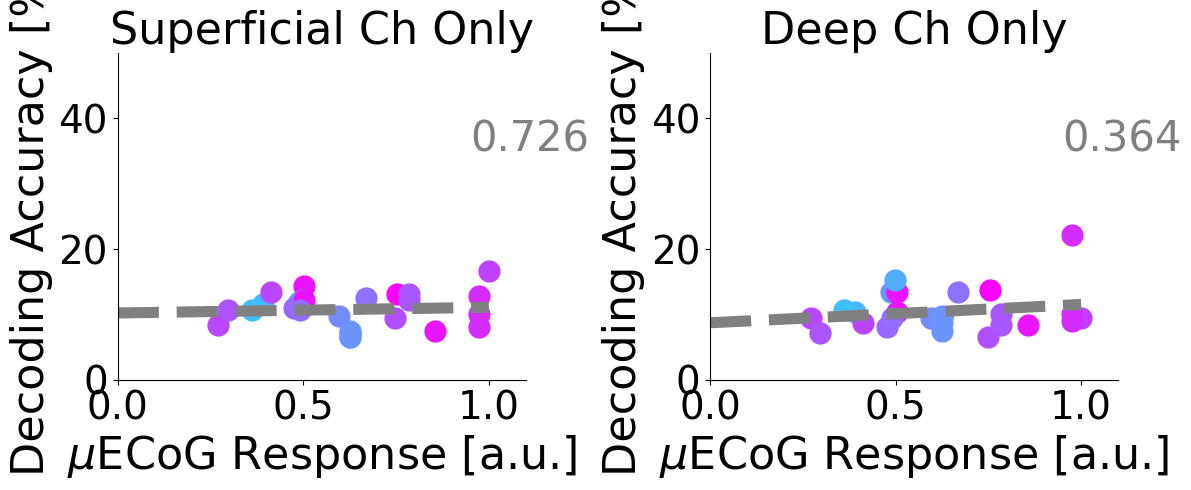

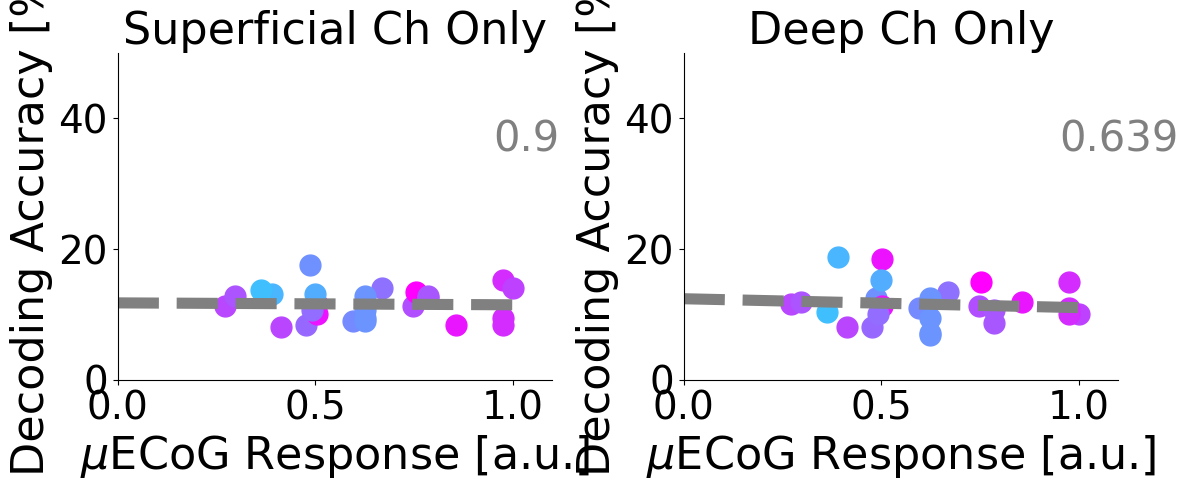

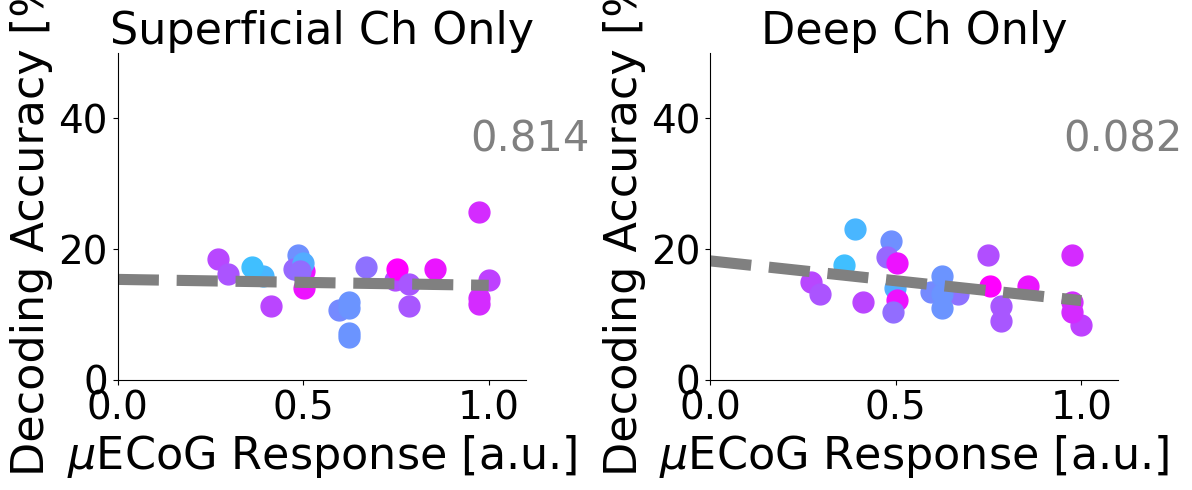

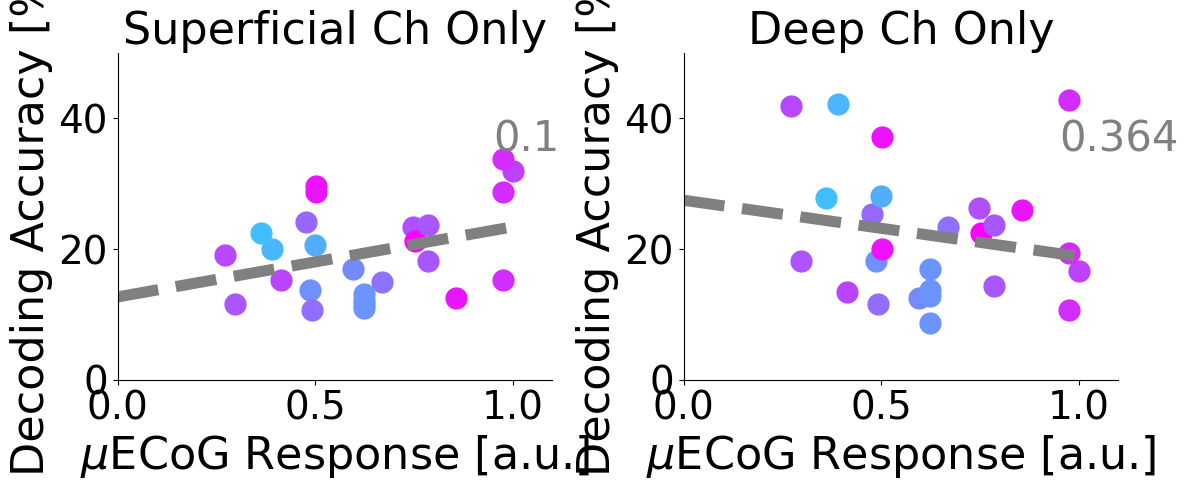

In [147]:
# PLot for ecog relationship for superficial units only and deep units only 
align_event = align_events[-1]
for iband in range(nbands):
    fig, ax = plt.subplots(1,2,figsize=(12,5))
    superficial_scores = np.array([np.mean(lda_results[align_event]['lfp_superficial_ch'][iband]['scores'][igroup]) for igroup in range(len(lda_results[align_event]['lfp_superficial_ch'][iband]['scores']))])
    deep_scores = np.array([np.mean(lda_results[align_event]['lfp_deep_ch'][iband]['scores'][igroup]) for igroup in range(len(lda_results[align_event]['lfp_deep_ch'][iband]['scores']))])

    xaxis = np.array(ecog_dec_acc_rec_site[align_event])/np.nanmax(np.array(ecog_dec_acc_rec_site[align_event]))
    yaxis_superficial = np.array(superficial_scores)
    yaxis_deep = np.array(deep_scores)

    _,_,_,pval_superficial,regfit_superficial = aopy.analysis.base.linear_fit_analysis2D(xaxis[np.logical_and(~np.isnan(yaxis_superficial), ~np.isnan(xaxis))], 100*superficial_scores[np.logical_and(~np.isnan(yaxis_superficial), ~np.isnan(xaxis))])
    [ax[0].plot(np.array(ecog_dec_acc_rec_site[align_event])[icol]/np.nanmax(np.array(ecog_dec_acc_rec_site[align_event])), 100*superficial_scores[icol], '.', color=day_colors[icol], markersize=30) for icol in range(nrecs)]
    ax[0].plot([0, 1], [regfit_superficial.intercept_[0],regfit_superficial.coef_[0][0]+regfit_superficial.intercept_[0]], '--', color=(0.5,0.5,0.5))               
    # ax[ievent].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (2e7, 60))
    ax[0].set(xlabel='$\mu$ECoG Response [a.u.]', ylabel='Decoding Accuracy [%]', ylim=(0,50),xlim=(0,1.1), title="Superficial Ch Only")
    print(pval_superficial)
    if pval_superficial < 0.05:
        ax[0].annotate('*',(1.05,(2*10)+27), fontsize=30, color=(0.5,0.5,0.5))
    else:
        ax[0].annotate(f'{np.round(pval_superficial,3)}',(.95,35), fontsize=30, color=(0.5,0.5,0.5))


    _,_,_,pval_deep,regfit_deep = aopy.analysis.base.linear_fit_analysis2D(xaxis[np.logical_and(~np.isnan(yaxis_deep), ~np.isnan(xaxis))], 100*deep_scores[np.logical_and(~np.isnan(yaxis_deep), ~np.isnan(xaxis))])
    [ax[1].plot(np.array(ecog_dec_acc_rec_site[align_event])[irec]/np.nanmax(np.array(ecog_dec_acc_rec_site[align_event])), 100*deep_scores[irec], '.', color=day_colors[irec], markersize=30) for irec in range(nrecs)]
    ax[1].plot([0, 1], [regfit_deep.intercept_[0],regfit_deep.coef_[0][0]+regfit_deep.intercept_[0]], '--', color=(0.5,0.5,0.5))               
    # ax[ievent].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (2e7, 60))
    ax[1].set(xlabel='$\mu$ECoG Response [a.u.]', ylabel='Decoding Accuracy [%]', ylim=(0,50),xlim=(0,1.1), title="Deep Ch Only")
    print(pval_deep)
    if pval_deep < 0.05:
        ax[1].annotate('*',(1.05,(2*10)+27), fontsize=30, color=(0.5,0.5,0.5))
    else:
        ax[1].annotate(f'{np.round(pval_deep,3)}',(.95,35), fontsize=30, color=(0.5,0.5,0.5))

    fig.tight_layout()
    aopy.visualization.savefig(base_save_dir, f'{subject}_lda_supVSdeep_lfp_band{iband}.svg')

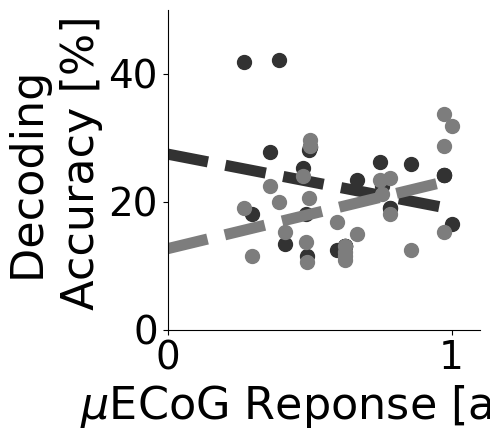

In [235]:
# Decoding accuracy as a function of ecog maps
iband = 4

fig, ax = plt.subplots(1,1,figsize=(5,4.5))
align_event = align_events[-1]
superficial_column_scores = np.zeros(nrecs)*np.nan
deep_column_scores = np.zeros(nrecs)*np.nan
superficial_scores = np.array([np.mean(lda_results[align_event]['lfp_superficial_ch'][iband]['scores'][igroup]) for igroup in range(len(lda_results[align_event]['lfp_superficial_ch'][iband]['scores']))])
deep_scores = np.array([np.mean(lda_results[align_event]['lfp_deep_ch'][iband]['scores'][igroup]) for igroup in range(len(lda_results[align_event]['lfp_deep_ch'][iband]['scores']))])
for irec in range(nrecs):
    rec_site_idx = recording_site == recording_site[irec]
    superficial_column_scores[irec] = np.nanmean(np.array(superficial_scores)[rec_site_idx])
    deep_column_scores[irec] = np.nanmean(np.array(deep_scores)[rec_site_idx])

yaxis = np.array(deep_scores)
_,R2,_,pval,regfit = aopy.analysis.base.linear_fit_analysis2D(xaxis[~np.isnan(yaxis)], 100*deep_column_scores[~np.isnan(yaxis)])
[ax.plot(np.array(ecog_dec_acc_rec_site[align_event])[icol]/np.nanmax(np.array(ecog_dec_acc_rec_site[align_event])), 100*deep_column_scores[icol], '.', color=[0.196,0.196,0.196], markersize=20) for icol in range(nrecs)]
ax.plot([0, 1], [regfit.intercept_[0],regfit.coef_[0][0]+regfit.intercept_[0]], '--', color=(0.196,0.196,0.196))               
# ax.annotate(f'p={np.round(pval,2)}',(.75,17), fontsize=32, color=(0.196,0.196,0.196))
# ax.annotate(f'$R^2$={np.round(R2,2)}',(.75,7), fontsize=32, color=(0.196,0.196,0.196))
    
xaxis = np.array(ecog_dec_acc_rec_site[align_event])/np.nanmax(np.array(ecog_dec_acc_rec_site[align_event]))
yaxis = np.array(superficial_column_scores)
_,R2,_,pval,regfit = aopy.analysis.base.linear_fit_analysis2D(xaxis[~np.isnan(yaxis)], 100*superficial_column_scores[~np.isnan(yaxis)])
[ax.plot(np.array(ecog_dec_acc_rec_site[align_event])[icol]/np.nanmax(np.array(ecog_dec_acc_rec_site[align_event])), 100*superficial_scores[icol], '.', color=[0.49,0.49,0.49], markersize=20) for icol in range(nrecs)]
ax.plot([0, 1], [regfit.intercept_[0],regfit.coef_[0][0]+regfit.intercept_[0]], '--', color=(0.49,0.49,0.49))               
# ax.annotate(f'p={np.round(pval,2)}',(.75,37), fontsize=32, color=(0.49,0.49,0.49))
# ax.annotate(f'$R^2$={np.round(R2,2)}',(.75,27), fontsize=32, color=(0.49,0.49,0.49))


 
    
ax.set(xlabel='$\mu$ECoG Reponse [a.u.]', ylabel='Decoding \n Accuracy [%]', ylim=(0,50),xlim=(0,1.1))
fig.tight_layout()
aopy.visualization.savefig(base_save_dir, f'{subject}_lda_column_ecog_lfp_supVdeep.svg')

In [185]:
align_event = align_events[-1]
for iband in range(nbands):
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    superficial_scores = np.array([np.mean(lda_results[align_event]['lfp_superficial_ch'][iband]['scores'][igroup]) for igroup in range(len(lda_results[align_event]['lfp_superficial_ch'][iband]['scores']))])
    deep_scores = np.array([np.mean(lda_results[align_event]['lfp_deep_ch'][iband]['scores'][igroup]) for igroup in range(len(lda_results[align_event]['lfp_deep_ch'][iband]['scores']))])
    
    dec_map = ax.scatter(ecog_dec_acc[subject]['rec_locations'][:,0], ecog_dec_acc[subject]['rec_locations'][:,1], s=200,c=100*(superficial_scores-deep_scores), cmap='winter', vmin=-10, vmax=10)
    cb = plt.colorbar(dec_map, label='$\Delta$ decoding')
    ax.set(xlim=(-6,6), ylim=(-6,6))
    ax.set(xlabel='X-Position [mm]', ylabel='Y-Position [mm]', xlim=(-6,6), ylim=(-6,6))
    # ax.set(title='Superficial vs. Deep \n Decoding Change')
    plt.gca().set_aspect("equal")
    fig.tight_layout()
    aopy.visualization.savefig(base_save_dir, f'{subject}_lda_depth_dec_diff_lfp_band{iband}.svg')

In [206]:
align_event = align_events[-1]
fig, ax = plt.subplots(1,1, figsize=(4,4.5))
# for iband in range(nbands):
site_depth_range_lfp = []
iband = 4
for irec in range(nrecs):
    if recording_site[irec] in good_sites:
        cbdsd = ax.plot(100*np.mean(lda_results[align_event]['lfp_window'][iband]['scores_window'][irec],axis=1)[:-1],  np.mean(pseudopopulation_metadata['depth_ranges'], axis=1)[:-1]/1000, color=day_colors[irec])
        # cb = plt.colorbar(cbdsd)
        first_idx = np.where(np.logical_not(np.isnan(np.mean(lda_results[align_event]['lfp_window'][iband]['scores_window'][irec],axis=1))))[0][0]
        last_idx = np.where(np.logical_not(np.isnan(np.mean(lda_results[align_event]['lfp_window'][iband]['scores_window'][irec],axis=1))))[0][-1]
        site_depth_range_lfp.append(100*np.mean(lda_results[align_event]['lfp_window'][iband]['scores_window'][irec],axis=1)[first_idx] - 100*np.mean(lda_results[align_event]['lfp_window'][iband]['scores_window'][irec],axis=1)[last_idx])
        ax.set(xlabel='Decoding Accuracy [%]', ylabel='Depth [mm]', xlim=(5, 45), ylim=(0, 3.840))
        ax.set_yticks([0,1,2,3])
        ax.invert_yaxis()
fig.tight_layout()
aopy.visualization.savefig(base_save_dir, f'{subject}_lda_depth_dec_window_lfp_band{iband}.svg')

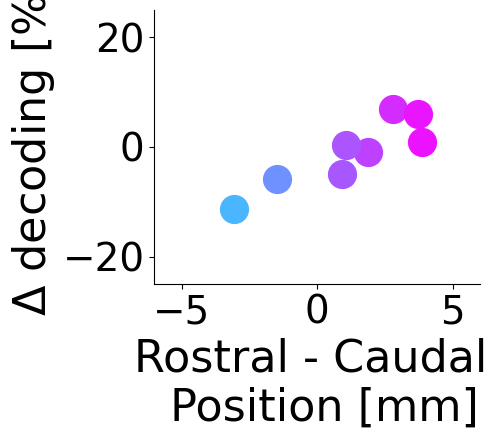

In [210]:
fig, ax = plt.subplots(1,1,figsize=(5,4.5))
[ax.plot(xpos_plt[icol],site_depth_range_lfp[icol],'.', markersize=40, color=depth_colors[icol]) for icol in range(len(depth_colors))]
# ax[1].plot(xpos_plt, site_min_depth,'.')
# ax[1].legend(['max','min'])
# ax[1].invert_yaxis()
ax.set(xlabel='Rostral - Caudal \n Position [mm]', ylabel='$\Delta$ decoding [%]', xlim=(-6,6), ylim=(-25,25))
# ax.set(title='Superficial vs. Deep \n Decoding Change')
fig.tight_layout()
aopy.visualization.savefig(base_save_dir, f'{subject}_lda_depth_dec_diff.svg')

In [108]:
align_event = align_events[-1]
fig, ax = plt.subplots(1,nrecs, figsize=(nrecs*4,5))
# for iband in range(nbands):

iband = 4
for irec in range(nrecs):
    cbdsd = ax[irec].plot(np.mean(lda_results[align_event]['lfp_window'][iband]['scores_window'][irec],axis=1)[:-1],  np.mean(pseudopopulation_metadata['depth_ranges'], axis=1)[:-1]/1000, color=f'C{iband}')
    # cb = plt.colorbar(cbdsd)
    ax[irec].set(title=f"{recording_site[irec]}")
    ax[irec].invert_yaxis()

plt.suptitle(f"{align_event}")
fig.tight_layout()
plt.show()

In [127]:
np.mean(lda_results[align_event]['lfp_window'][iband]['scores_window'][irec],axis=1)
np.where(np.logical_not(np.isnan(np.mean(lda_results[align_event]['lfp_window'][iband]['scores_window'][irec],axis=1))))[0][0]

0

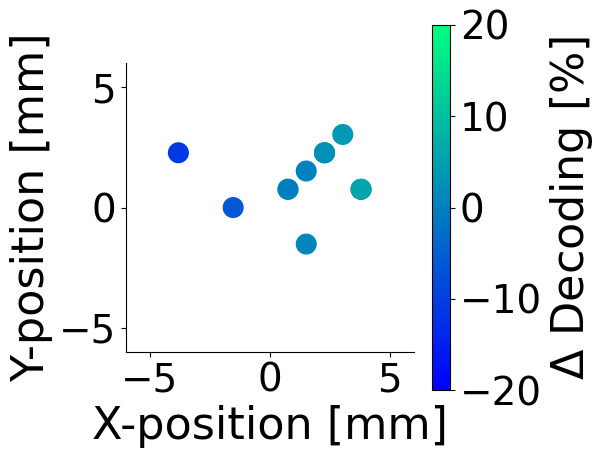

In [209]:
## Plot spatial map of decoding
align_event = align_events[-1]
fig, ax = plt.subplots(1,1,figsize=(6,5))
colors = site_depth_range_lfp
good_site_idx = np.in1d(recording_site, good_sites)
dec_map = ax.scatter(ecog_dec_acc[subject]['rec_locations'][good_site_idx,0], ecog_dec_acc[subject]['rec_locations'][good_site_idx,1], s=200, c=colors, cmap='winter', vmin=-20, vmax=20)
cb = plt.colorbar(dec_map, label='$\Delta$ Decoding [%]')
# cb.set_ticks([0.1,.5])
ax.set(xlim=(-6,6), ylim=(-6,6), xlabel='X-position [mm]', ylabel='Y-position [mm]')
plt.gca().set_aspect("equal")
fig.tight_layout()
aopy.visualization.savefig(base_save_dir, f'{subject}_lda_np_spatial_map_depth_lfp.svg')

In [215]:
# Plot layout of where the max depth is
align_event = align_events[-1]
fig, ax = plt.subplots(1,1,figsize=(6,5))
max_depth_lfp = [np.mean(pseudopopulation_metadata['depth_ranges'], axis=1)[:-1][np.argmax(np.mean(lda_results[align_event]['lfp_window'][iband]['scores_window'][irec],axis=1)[:-1])] for irec in range(nrecs)]
colors = np.array(max_depth_lfp)[good_site_idx]/1000
colors = np.array(max_depth_lfp)/1000

# dec_map = ax.scatter(ecog_dec_acc[subject]['rec_locations'][good_site_idx,0], ecog_dec_acc[subject]['rec_locations'][good_site_idx,1], s=200, c=colors, cmap='spring', vmin=0, vmax=3.840)
dec_map = ax.scatter(ecog_dec_acc[subject]['rec_locations'][:,0], ecog_dec_acc[subject]['rec_locations'][:,1], s=200, c=colors, cmap='spring', vmin=0, vmax=3.840)
cb = plt.colorbar(dec_map, label=' Depth of max \n  decoding [mm]')
# cb = plt.colorbar(dec_map)
# cb.set_ticks([0.1,.5])
ax.set(xlim=(-6,6), ylim=(-6,6), xlabel='X-position [mm]', ylabel='Y-position [mm]')
plt.gca().set_aspect("equal")
fig.tight_layout()
aopy.visualization.savefig(base_save_dir, f'{subject}_lda_np_spatial_map_depthidx_lfp.svg')

## Linear Regression

### Trial averaged per target

In [ ]:
ifold = 1
for align_event in align_events:
    fig, ax = plt.subplots(1,nrecs,figsize=(3*nrecs,3))
    for irec in range(nrecs):
        unique_targets = np.unique(lin_reg_results[align_event]['test_label_idx_tavg'][ifold])
        [ax[irec].plot(lin_reg_results[align_event]['test_pred_velo_tavg'][irec][ifold][lin_reg_results[align_event]['test_label_idx_tavg'][irec][ifold]==itarget,1], lin_reg_results[align_event]['test_pred_velo_tavg'][irec][ifold][lin_reg_results[align_event]['test_label_idx_tavg'][irec][ifold]==itarget,2], '.', color=colors[ii]) for ii, itarget in enumerate(unique_targets)]
        [ax[irec].plot(np.mean(lin_reg_results[align_event]['test_pred_velo_tavg'][irec][ifold][lin_reg_results[align_event]['test_label_idx_tavg'][irec][ifold]==itarget,1], axis=0), np.mean(lin_reg_results[align_event]['test_pred_velo_tavg'][irec][ifold][lin_reg_results[align_event]['test_label_idx_tavg'][irec][ifold]==itarget,2], axis=0), '.', markersize=20, color=colors[ii]) for ii, itarget in enumerate(unique_targets)]
        [ax[irec].plot(np.mean(lin_reg_results[align_event]['test_velo_tavg'][irec][ifold][lin_reg_results[align_event]['test_label_idx_tavg'][irec][ifold]==itarget,0], axis=0), np.mean(lin_reg_results[align_event]['test_velo_tavg'][irec][ifold][lin_reg_results[align_event]['test_label_idx_tavg'][irec][ifold]==itarget,1], axis=0), '*', markersize=20, color=colors[ii]) for ii, itarget in enumerate(unique_targets)]
        # [ax[irec].set(xlabel="TRD 1 (x)", ylabel="TRD 2 (y)", title=f"Rec Site {recording_site[irec]}", xlim=(-35,35), ylim=(-35,35)) for irec in range(nrecs)]
        [ax[irec].set(xlabel="TRD 1 (x)", ylabel="TRD 2 (y)", title=f"Rec Site {recording_site[irec]}") for irec in range(nrecs)]
    
    plt.suptitle(f"{align_event}")
    fig.tight_layout()
    plt.show()    

In [ ]:
align_event in align_events[-1]
for irec in range(nrecs):
    fig, ax = plt.subplots(2,1,figsize=(15,3))
    ax[0].plot(lin_reg_results[align_event]['test_velo_tavg'][irec][ifold][:,0], label='x velo')
    ax[0].plot(lin_reg_results[align_event]['test_pred_velo_tavg'][irec][ifold][:,1], label='predicted')
    ax[0].set(xlabel='Trial Number')
    ax[0].legend()
    ax[1].plot(lin_reg_results[align_event]['test_velo_tavg'][irec][ifold][:,1], label='y velo')
    ax[1].plot(lin_reg_results[align_event]['test_pred_velo_tavg'][irec][ifold][:,2], label='predicted')
    ax[1].set(xlabel='Trial Number')
    ax[1].legend()
    plt.suptitle(f"Recording Site: {recording_site[irec]}")
    fig.tight_layout()
    plt.show()

In [ ]:
align_event in align_events[-1]
for irec in range(nrecs):
    fig, ax = plt.subplots(2,1,figsize=(15,3))
    ax[0].plot(lin_reg_results[align_event]['test_velo_tavg_hand'][irec][ifold][:,0], label='x velo')
    ax[0].plot(lin_reg_results[align_event]['test_pred_velo_tavg_hand'][irec][ifold][:,1], label='predicted')
    ax[0].set(xlabel='Trial Number')
    ax[0].legend()
    ax[1].plot(lin_reg_results[align_event]['test_velo_tavg_hand'][irec][ifold][:,1], label='y velo')
    ax[1].plot(lin_reg_results[align_event]['test_pred_velo_tavg_hand'][irec][ifold][:,2], label='predicted')
    ax[1].set(xlabel='Trial Number')
    ax[1].legend()
    plt.suptitle(f"Recording Site: {recording_site[irec]}")
    fig.tight_layout()
    plt.show()

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12,3))
for ievent, align_event in enumerate(align_events):    
    tavg_scores = np.array([np.mean(lin_reg_results[align_event]['scores_tavg'][irec], axis=0) for irec in range(nrecs)])
    [ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], tavg_scores[irec,0], '.', color=day_colors[irec]) for irec in range(nrecs)]
    
    # for irec in range(nrecs):
    #     mse = np.mean([sklearn.metrics.mean_squared_error(lin_reg_results[align_event]['test_velo_tavg'][irec][ifold][:,0], lin_reg_results[align_event]['test_pred_velo_tavg'][irec][ifold][:,0]) for ifold in range(nfolds)])
    #     ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], mse, '.', color=day_colors[irec])
    ax[ievent].set(xlabel="ECoG", ylabel="Trial averaged $R^2$", title=align_event)
plt.suptitle(f"X velocity")
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(1,3, figsize=(12,3))
for ievent, align_event in enumerate(align_events):    
    tavg_scores = np.array([np.mean(lin_reg_results[align_event]['scores_tavg'][irec], axis=0) for irec in range(nrecs)])
    [ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], tavg_scores[irec,1], '.', color=day_colors[irec]) for irec in range(nrecs)]
    ax[ievent].set(xlabel="ECoG", ylabel="Trial averaged $R^2$", title=align_event, ylim=(-5,1))
plt.suptitle(f"Y velocity")
fig.tight_layout()
plt.show()
    

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12,3))
for ievent, align_event in enumerate(align_events): 
    for irec in range(nrecs):
        mae = np.mean([sklearn.metrics.mean_absolute_error(lin_reg_results[align_event]['test_velo_tavg'][irec][ifold][:,0], lin_reg_results[align_event]['test_pred_velo_tavg'][irec][ifold][:,1]) for ifold in range(nfolds)])
        ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], mae, '.', color=day_colors[irec])
    ax[ievent].set(xlabel="ECoG", ylabel="Mean Abs Error", title=align_event)
plt.suptitle(f"X velocity")
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(1,3, figsize=(12,3))
for ievent, align_event in enumerate(align_events): 
    for irec in range(nrecs):
        mae = np.mean([sklearn.metrics.mean_absolute_error(lin_reg_results[align_event]['test_velo_tavg'][irec][ifold][:,1], lin_reg_results[align_event]['test_pred_velo_tavg'][irec][ifold][:,2]) for ifold in range(nfolds)])
        ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], mae, '.', color=day_colors[irec])
    ax[ievent].set(xlabel="ECoG", ylabel="Mean Abs Error", title=align_event)
plt.suptitle(f"Y velocity")
fig.tight_layout()
plt.show()
    

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12,3))
for ievent, align_event in enumerate(align_events): 
    for irec in range(nrecs):
        mae = np.mean([sklearn.metrics.mean_absolute_error(lin_reg_results[align_event]['test_velo_tavg'][irec][ifold][:,0], lin_reg_results[align_event]['test_pred_velo_tavg'][irec][ifold][:,1]) for ifold in range(nfolds)])
        if recording_site[irec] in recording_brain_areas['M1']:
            ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], mae, '.', color='purple')
        else:
            ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], mae, '.', color='blue')
    ax[ievent].set(xlabel="ECoG", ylabel="Mean Abs Error", title=align_event)
plt.suptitle(f"X velocity")
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(1,3, figsize=(12,3))
for ievent, align_event in enumerate(align_events): 
    for irec in range(nrecs):
        mae = np.mean([sklearn.metrics.mean_absolute_error(lin_reg_results[align_event]['test_velo_tavg'][irec][ifold][:,1], lin_reg_results[align_event]['test_pred_velo_tavg'][irec][ifold][:,2]) for ifold in range(nfolds)])
        if recording_site[irec] in recording_brain_areas['M1']:
            ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], mae, '.', color='purple')
        else:
            ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], mae, '.', color='blue')
    ax[ievent].set(xlabel="ECoG", ylabel="Mean Abs Error", title=align_event)
plt.suptitle(f"Y velocity")
fig.tight_layout()
plt.show()
    

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12,3))
for ievent, align_event in enumerate(align_events): 
    for irec in range(nrecs):
        mae = np.mean([sklearn.metrics.mean_absolute_error(lin_reg_results[align_event]['test_velo_tavg'][irec][ifold][:,0], lin_reg_results[align_event]['test_pred_velo_tavg'][irec][ifold][:,1]) for ifold in range(nfolds)])
        if recording_site[irec] in recording_brain_areas['M1']:
            ax[ievent].plot(np.abs(100*np.array(ecog_dec_acc_rec_site_x[align_event])[irec]), mae, '.', color='purple')
        else:
            ax[ievent].plot(np.abs(100*np.array(ecog_dec_acc_rec_site_x[align_event])[irec]), mae, '.', color='blue')
    ax[ievent].set(xlabel="ECoG X", ylabel="Mean Abs Error", title=align_event)
plt.suptitle(f"X velocity vs. X velo ECoG")
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(1,3, figsize=(12,3))
for ievent, align_event in enumerate(align_events): 
    for irec in range(nrecs):
        mae = np.mean([sklearn.metrics.mean_absolute_error(lin_reg_results[align_event]['test_velo_tavg'][irec][ifold][:,1], lin_reg_results[align_event]['test_pred_velo_tavg'][irec][ifold][:,2]) for ifold in range(nfolds)])
        if recording_site[irec] in recording_brain_areas['M1']:
            ax[ievent].plot(np.abs(100*np.array(ecog_dec_acc_rec_site_y[align_event])[irec]), mae, '.', color='purple')
        else:
            ax[ievent].plot(np.abs(100*np.array(ecog_dec_acc_rec_site_y[align_event])[irec]), mae, '.', color='blue')
    ax[ievent].set(xlabel="ECoG Y", ylabel="Mean Abs Error", title=align_event)
plt.suptitle(f"Y velocity vs. Y velo ECoG")
fig.tight_layout()
plt.show()
    

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12,3))
for ievent, align_event in enumerate(align_events): 
    for irec in range(nrecs):
        mae_x = np.mean([sklearn.metrics.mean_absolute_error(lin_reg_results[align_event]['test_velo_tavg'][irec][ifold][:,0], lin_reg_results[align_event]['test_pred_velo_tavg'][irec][ifold][:,1]) for ifold in range(nfolds)])
        mae_y = np.mean([sklearn.metrics.mean_absolute_error(lin_reg_results[align_event]['test_velo_tavg'][irec][ifold][:,1], lin_reg_results[align_event]['test_pred_velo_tavg'][irec][ifold][:,2]) for ifold in range(nfolds)])
        if recording_site[irec] in recording_brain_areas['M1']:
            ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], np.sqrt(mae_x**2+mae_y**2), '.', color='purple')
        else:
            ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], np.sqrt(mae_x**2+mae_y**2), '.', color='blue')
    ax[ievent].set(xlabel="ECoG", ylabel="Mean Abs Error", title=align_event)
plt.suptitle(f"Combined error in X and Y directions")
fig.tight_layout()
plt.show()


#### Neuron Matched

In [ ]:
# Neuron number matched 
# lin_reg_results[align_event]['scores_tavg_nmatch']
fig, ax = plt.subplots(1,3, figsize=(12,3))
for ievent, align_event in enumerate(align_events): 
    for irec in range(nrecs):
        mae = np.mean(lin_reg_results[align_event]['mae_tavg_nmatch'][irec])
        if recording_site[irec] in recording_brain_areas['M1']:
            ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], mae, '.', color='purple')
        else:
            ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], mae, '.', color='blue')
    
    # Plot trendline/significance
    ax[ievent].plot([100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx]), 100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx])], [(lin_reg_results[align_event]['tavg_nmatch_reg_fit_M1'].coef_*100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx])+lin_reg_results[align_event]['tavg_nmatch_reg_fit_M1'].intercept_)[0],(lin_reg_results[align_event]['tavg_nmatch_reg_fit_M1'].coef_*100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx])+lin_reg_results[align_event]['tavg_nmatch_reg_fit_M1'].intercept_)[0]], color='purple')               
    ax[ievent].plot([100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx]), 100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx])], [(lin_reg_results[align_event]['tavg_nmatch_reg_fit_PM'].coef_*100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx])+lin_reg_results[align_event]['tavg_nmatch_reg_fit_PM'].intercept_)[0],(lin_reg_results[align_event]['tavg_nmatch_reg_fit_PM'].coef_*100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx])+lin_reg_results[align_event]['tavg_nmatch_reg_fit_PM'].intercept_)[0]], color='blue')               
    ax[ievent].annotate(f"M1 p: {np.round(lin_reg_results[align_event]['tavg_nmatch_pcc_pval_M1'],3)}", (4e7, 60), color='purple')
    ax[ievent].annotate(f"PM p: {np.round(lin_reg_results[align_event]['tavg_nmatch_pcc_pval_PM'],3)}", (4e7, 70), color='blue')
    
    ax[ievent].set(xlabel="ECoG", ylabel="Mean Abs Error", title=align_event, ylim=(0, 100))
plt.suptitle(f"Combined error in X and Y directions - Neuron Matched")
fig.tight_layout()
plt.show()


In [ ]:
# Neuron number matched 
# lin_reg_results[align_event]['scores_tavg_nmatch']
fig, ax = plt.subplots(1,3, figsize=(12,3))
for ievent, align_event in enumerate(align_events): 
    for irec in range(nrecs):
        mae_dist = lin_reg_results[align_event]['mae_tavg_nmatch'][irec]
        vplts1 = ax[ievent].violinplot(mae_dist, positions=[(100*np.array(ecog_dec_acc_rec_site[align_event]))[irec]], showmedians=True, showmeans=False, widths = 5e6)
        if recording_site[irec] in recording_brain_areas['M1']:            
            vplts1['bodies'][0].set_color('purple')
            vplts1['cbars'].set_colors('purple')
            vplts1['cmedians'].set_colors('purple')
            vplts1['cmins'].set_colors('purple')
            vplts1['cmaxes'].set_colors('purple')
        else:
            vplts1['bodies'][0].set_color('blue')
            vplts1['cbars'].set_colors('blue')
            vplts1['cmedians'].set_colors('blue')
            vplts1['cmins'].set_colors('blue')
            vplts1['cmaxes'].set_colors('blue')
    
    # Plot trendline/significance
    ax[ievent].plot([100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx]), 100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx])], [(lin_reg_results[align_event]['tavg_nmatchdist_reg_fit_M1'].coef_*100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx])+lin_reg_results[align_event]['tavg_nmatchdist_reg_fit_M1'].intercept_)[0],(lin_reg_results[align_event]['tavg_nmatchdist_reg_fit_M1'].coef_*100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx])+lin_reg_results[align_event]['tavg_nmatchdist_reg_fit_M1'].intercept_)[0]], color='purple')               
    ax[ievent].plot([100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx]), 100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx])], [(lin_reg_results[align_event]['tavg_nmatchdist_reg_fit_PM'].coef_*100*np.min(np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx])+lin_reg_results[align_event]['tavg_nmatchdist_reg_fit_PM'].intercept_)[0],(lin_reg_results[align_event]['tavg_nmatchdist_reg_fit_PM'].coef_*100*np.max(np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx])+lin_reg_results[align_event]['tavg_nmatchdist_reg_fit_PM'].intercept_)[0]], color='blue')               
    ax[ievent].annotate(f"M1 p: {np.round(lin_reg_results[align_event]['tavg_nmatchdist_pcc_pval_M1'],5)}", (5e7, 100), color='purple')
    ax[ievent].annotate(f"PM p: {np.round(lin_reg_results[align_event]['tavg_nmatchdist_pcc_pval_PM'],5)}", (5e7, 120), color='blue')
    
    ax[ievent].set(xlabel="ECoG", ylabel="Mean Abs Error", title=align_event, ylim=(0, 175))
plt.suptitle(f"Combined error in X and Y directions - Neuron Matched")
fig.tight_layout()
plt.show()


### Concatenated trials

#### All units

In [ ]:
ntimeplot = 10000
ifold = 0
align_event = align_events[-1]
for irec in range(nrecs):
    fig, ax = plt.subplots(2,1,figsize=(15,3))
    ax[0].plot(lin_reg_results[align_event]['test_pos'][irec][ifold][:ntimeplot,0], label='x pos')
    ax[0].plot(lin_reg_results[align_event]['test_pred_pos'][irec][ifold][:ntimeplot,1], label='predicted')
    ax[0].legend()
    ax[1].plot(lin_reg_results[align_event]['test_pos'][irec][ifold][:ntimeplot,1], label='y pos')
    ax[1].plot(lin_reg_results[align_event]['test_pred_pos'][irec][ifold][:ntimeplot,2], label='predicted')
    ax[1].legend()
    plt.suptitle(f"Recording Site: {recording_site[irec]}")
    fig.tight_layout()
    plt.show()

In [ ]:
ntimeplot = 10000
ifold = 0
align_event = align_events[-1]
for irec in range(nrecs):
    fig, ax = plt.subplots(2,1,figsize=(15,3))
    ax[0].plot(lin_reg_results[align_event]['test_velo'][irec][ifold][:ntimeplot,0], label='x velo')
    ax[0].plot(lin_reg_results[align_event]['test_pred_velo'][irec][ifold][:ntimeplot,1], label='predicted')
    ax[0].legend()
    ax[1].plot(lin_reg_results[align_event]['test_velo'][irec][ifold][:ntimeplot,1], label='y velo')
    ax[1].plot(lin_reg_results[align_event]['test_pred_velo'][irec][ifold][:ntimeplot,2], label='predicted')
    ax[1].legend()
    plt.suptitle(f"Recording Site: {recording_site[irec]}")
    fig.tight_layout()
    plt.show()

In [ ]:
# Linear regression weights

for align_event in align_events:
    fig, ax = plt.subplots(1,nrecs, figsize=(nrecs*3.5, 3))
    [ax[irec].pcolor(lin_reg_results[align_event]['subspaces_pos'][irec][:,0,:].T,cmap='bwr', vmin=-0.2, vmax=0.2) for irec in range(nrecs)]
    [ax[irec].set(xlabel="unit", ylabel="fold", title=f"{recording_site[irec]}") for irec in range(nrecs)]
    plt.suptitle(f"{align_event} - X-direction")
    fig.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots(1,nrecs, figsize=(nrecs*3.5, 3))
    [ax[irec].pcolor(lin_reg_results[align_event]['subspaces_pos'][irec][:,1,:].T,cmap='bwr', vmin=-0.2, vmax=0.2) for irec in range(nrecs)]
    [ax[irec].set(xlabel="unit", ylabel="fold", title=f"{recording_site[irec]}") for irec in range(nrecs)]
    plt.suptitle(f"{align_event} - Y-direction")
    fig.tight_layout()
    plt.show()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,3))
[ax.plot(np.sort(np.abs(np.mean(lin_reg_results[align_event]['subspaces_pos'][irec][:,0,:], axis=1))), color=day_colors[irec]) for irec in range(nrecs)]
ax.set(xlabel='Number of units', ylabel='Regression Weight')
plt.show()

In [ ]:
# Plot x-pos results
fig, ax = plt.subplots(1,3,figsize=(10,3))
for ievent, align_event in enumerate(align_events):
    avg_scores_x = [np.mean(lin_reg_results[align_event]['scores_pos'][irec], axis=0)[0] for irec in range(nrecs)]
    [ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], np.array(avg_scores_x)[irec], '.',color=day_colors[irec], markersize=8) for irec in range(nrecs)]
    # ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0]])               
    # ax[0].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (3, 20))
    ax[ievent].set(xlabel='ECoG Acc [%]', ylabel='Neuropixel Acc [r^2]', title=align_event, ylim=(-0.35, 0.9))
plt.suptitle(f"Linear regression to x-position")
fig.tight_layout()
plt.show()
    
# Plot y-pos results
fig, ax = plt.subplots(1,3,figsize=(10,3))
for ievent, align_event in enumerate(align_events):
    avg_scores_y = [np.mean(lin_reg_results[align_event]['scores_pos'][irec], axis=0)[1] for irec in range(nrecs)]
    [ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], np.array(avg_scores_y)[irec], '.', color=day_colors[irec], markersize=8) for irec in range(nrecs)]
    # ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0]])               
    # ax[0].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (3, 20))
    ax[ievent].set(xlabel='ECoG Acc [%]', ylabel='Neuropixel Acc [r^2]', ylim=(-0.35, 0.9))
plt.suptitle(f"Linear regression to y-position")
fig.tight_layout()
plt.show()

In [ ]:
# Plot x-pos results as a function of number of units
fig, ax = plt.subplots(1,3,figsize=(10,3))
for ievent, align_event in enumerate(align_events):
    avg_scores_x = [np.mean(lin_reg_results[align_event]['scores_pos'][irec], axis=0)[0] for irec in range(nrecs)]
    [ax[ievent].plot(lin_reg_results[align_event]['subspaces_pos'][irec].shape[0], np.array(avg_scores_x)[irec], '.',color=day_colors[irec], markersize=8) for irec in range(nrecs)]
    # ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0]])               
    # ax[0].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (3, 20))
    ax[ievent].set(xlabel='Number of Units', ylabel='Neuropixel Acc [r^2]', title=align_event, ylim=(-0.35, 0.9))
plt.suptitle(f"Linear regression to x-position")
fig.tight_layout()
plt.show()
    
# Plot y-pos results
fig, ax = plt.subplots(1,3,figsize=(10,3))
for ievent, align_event in enumerate(align_events):
    avg_scores_y = [np.mean(lin_reg_results[align_event]['scores_pos'][irec], axis=0)[1] for irec in range(nrecs)]
    [ax[ievent].plot(lin_reg_results[align_event]['subspaces_pos'][irec].shape[0], np.array(avg_scores_y)[irec], '.', color=day_colors[irec], markersize=8) for irec in range(nrecs)]
    # ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0]])               
    # ax[0].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (3, 20))
    ax[ievent].set(xlabel='Number of Units', ylabel='Neuropixel Acc [r^2]', ylim=(-0.35, 0.9))
plt.suptitle(f"Linear regression to y-position")
fig.tight_layout()
plt.show()

In [ ]:
# split by brain area
# Plot x-pos results
fig, ax = plt.subplots(1,3,figsize=(10,3))
for ievent, align_event in enumerate(align_events):
    avg_scores_x = [np.mean(lin_reg_results[align_event]['scores_pos'][irec], axis=0)[0] for irec in range(nrecs)]
    [ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], np.array(avg_scores_x)[irec], '.',color='purple', markersize=8) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
    [ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], np.array(avg_scores_x)[irec], '.',color='blue', markersize=8) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]
    # ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0]])               
    # ax[0].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (3, 20))
    ax[ievent].set(xlabel='ECoG Acc [%]', ylabel='Neuropixel Acc [r^2]', title=align_event, ylim=(-0.35, 0.9))
plt.suptitle(f"Linear regression to x-position - All units")
fig.tight_layout()
plt.show()
    
# Plot y-pos results
fig, ax = plt.subplots(1,3,figsize=(10,3))
for ievent, align_event in enumerate(align_events):
    avg_scores_y = [np.mean(lin_reg_results[align_event]['scores_pos'][irec], axis=0)[1] for irec in range(nrecs)]
    [ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], np.array(avg_scores_y)[irec], '.',color='purple', markersize=8) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
    [ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], np.array(avg_scores_y)[irec], '.',color='blue', markersize=8) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]
    # ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0]])               
    # ax[0].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (3, 20))
    ax[ievent].set(xlabel='ECoG Acc [%]', ylabel='Neuropixel Acc [r^2]', ylim=(-0.35, 0.9))
plt.suptitle(f"Linear regression to y-position - All units")
fig.tight_layout()
plt.show()

In [ ]:
# split by brain area
# Plot x-pos results
fig, ax = plt.subplots(1,3,figsize=(10,3))
for ievent, align_event in enumerate(align_events):
    avg_scores_x = [np.mean(lin_reg_results[align_event]['scores_pos'][irec], axis=0)[0] for irec in range(nrecs)]
    [ax[ievent].plot(lin_reg_results[align_event]['subspaces_pos'][irec].shape[0], np.array(avg_scores_x)[irec], '.',color='purple', markersize=8) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
    [ax[ievent].plot(lin_reg_results[align_event]['subspaces_pos'][irec].shape[0], np.array(avg_scores_x)[irec], '.',color='blue', markersize=8) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]
    # ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0]])               
    # ax[0].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (3, 20))
    ax[ievent].set(xlabel='Number of units', ylabel='Neuropixel Acc [r^2]', title=align_event, ylim=(-0.35, 0.85))
plt.suptitle(f"Linear regression to x-position - All units")
fig.tight_layout()
plt.show()
    
# Plot y-pos results
fig, ax = plt.subplots(1,3,figsize=(10,3))
for ievent, align_event in enumerate(align_events):
    avg_scores_y = [np.mean(lin_reg_results[align_event]['scores_pos'][irec], axis=0)[1] for irec in range(nrecs)]
    [ax[ievent].plot(lin_reg_results[align_event]['subspaces_pos'][irec].shape[0], np.array(avg_scores_y)[irec], '.',color='purple', markersize=8) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
    [ax[ievent].plot(lin_reg_results[align_event]['subspaces_pos'][irec].shape[0], np.array(avg_scores_y)[irec], '.',color='blue', markersize=8) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]
    # ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0]])               
    # ax[0].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (3, 20))
    ax[ievent].set(xlabel='Number of units', ylabel='Neuropixel Acc [r^2]', ylim=(-0.35, 0.85))
plt.suptitle(f"Linear regression to y-position - All units")
fig.tight_layout()
plt.show()

In [ ]:
# Plot x-velo results
fig, ax = plt.subplots(1,3,figsize=(10,3))
for ievent, align_event in enumerate(align_events):
    avg_scores = [np.mean(lin_reg_results[align_event]['scores_velo'][irec], axis=0)[0] for irec in range(nrecs)]
    ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event]), np.array(avg_scores), 'k.', markersize=8)
    # ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0]])               
    # ax[0].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (3, 20))
    ax[ievent].set(xlabel='ECoG Acc [%]', ylabel='Neuropixel Acc [r^2]')
plt.suptitle(f"Linear regression to x-velocity")
fig.tight_layout()
plt.show()
    
# Plot y-velo results
fig, ax = plt.subplots(1,3,figsize=(10,3))
for ievent, align_event in enumerate(align_events):
    avg_scores = [np.mean(lin_reg_results[align_event]['scores_velo'][irec], axis=0)[1] for irec in range(nrecs)]
    ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event]), np.array(avg_scores), 'k.', markersize=8)
    # ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0]])               
    # ax[0].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (3, 20))
    ax[ievent].set(xlabel='ECoG Acc [%]', ylabel='Neuropixel Acc [r^2]')
plt.suptitle(f"Linear regression to y-velocity")
fig.tight_layout()
plt.show()

#### Neuron matched

In [ ]:
for align_event in align_events:
    fig, ax = plt.subplots(2,nrecs,figsize=(20,6))
    [ax[0,irec].pcolor(lin_reg_results[align_event]['scores_pos_nmatch'][irec][:,0,:].T, vmin=-0.7, vmax=0.7, cmap='bwr') for irec in range(nrecs)]
    [ax[1,irec].pcolor(lin_reg_results[align_event]['scores_pos_nmatch'][irec][:,1,:].T, vmin=-0.7, vmax=0.7, cmap='bwr') for irec in range(nrecs)]
    [ax[0,irec].set(xlabel='Fold', ylabel='Unit group') for irec in range(nrecs)]
    [ax[1,irec].set(xlabel='Fold', ylabel='Unit group') for irec in range(nrecs)]
    [ax[0,irec].set_title(f"Rec site {recording_site[irec]}", color=day_colors[irec]) for irec in range(nrecs)]
    [ax[1,irec].set_title(f"Rec site {recording_site[irec]}", color=day_colors[irec]) for irec in range(nrecs)]
    plt.suptitle(f"{align_event} - $R^2$")
    fig.tight_layout()
    plt.show()

In [ ]:
# Plot score variability across unit group
fig, ax = plt.subplots(1,len(align_events), figsize=(4*len(align_events), 3))
for ievent, align_event in enumerate(align_events):
    [ax[ievent].plot(lin_reg_results[align_event]['subspaces_pos'][irec].shape[0], np.var(np.mean(lin_reg_results[align_event]['scores_pos_nmatch'][irec][:,0,:], axis=0)),'.', color=day_colors[irec]) for irec in range(nrecs)]
    ax[ievent].set(xlabel='Total number of units', ylabel='$R^2$ variability across unit groups', title=align_event)
fig.tight_layout()
plt.show()

In [ ]:
# Plot x-pos results
fig, ax = plt.subplots(1,3,figsize=(10,3))
for ievent, align_event in enumerate(align_events):
    avg_scores = [np.median(lin_reg_results[align_event]['scores_pos_nmatch'][irec], axis=(0,2))[0] for irec in range(nrecs)]
    [ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], np.array(avg_scores)[irec], '.', color=day_colors[irec], markersize=8) for irec in range(nrecs)]
    # ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0]])               
    # ax[0].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (3, 20))
    ax[ievent].set(xlabel='ECoG Acc [%]', ylabel='Neuropixel Acc [r^2]', title=align_event)
plt.suptitle(f"Linear regression to x-position")
fig.tight_layout()
plt.show()
    
# Plot y-pos results
fig, ax = plt.subplots(1,3,figsize=(10,3))
for ievent, align_event in enumerate(align_events):
    avg_scores = [np.mean(lin_reg_results[align_event]['scores_pos_nmatch'][irec], axis=(0,2))[1] for irec in range(nrecs)]
    [ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], np.array(avg_scores)[irec], '.', color=day_colors[irec], markersize=8) for irec in range(nrecs)]
    # ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0]])               
    # ax[0].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (3, 20))
    ax[ievent].set(xlabel='ECoG Acc [%]', ylabel='Neuropixel Acc [r^2]')
plt.suptitle(f"Linear regression to y-position")
fig.tight_layout()
plt.show()

In [ ]:
# Plot x-pos results
fig, ax = plt.subplots(1,3,figsize=(10,3))
for ievent, align_event in enumerate(align_events):
    avg_scores_x = [np.mean(lin_reg_results[align_event]['scores_pos_nmatch'][irec], axis=(0,2))[0] for irec in range(nrecs)]
    [ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], np.array(avg_scores_x)[irec], '.',color='purple', markersize=8) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
    [ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], np.array(avg_scores_x)[irec], '.',color='blue', markersize=8) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]
    # ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0]])               
    # ax[0].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (3, 20))
    ax[ievent].set(xlabel='ECoG Acc [%]', ylabel='Neuropixel Acc [r^2]', title=align_event)
plt.suptitle(f"Linear regression to x-position")
fig.tight_layout()
plt.show()
    
# Plot y-pos results
fig, ax = plt.subplots(1,3,figsize=(10,3))
for ievent, align_event in enumerate(align_events):
    avg_scores_y = [np.mean(lin_reg_results[align_event]['scores_pos_nmatch'][irec], axis=(0,2))[1] for irec in range(nrecs)]
    [ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], np.array(avg_scores_y)[irec], '.',color='purple', markersize=8) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
    [ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], np.array(avg_scores_y)[irec], '.',color='blue', markersize=8) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]
    # ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0]])               
    # ax[0].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (3, 20))
    ax[ievent].set(xlabel='ECoG Acc [%]', ylabel='Neuropixel Acc [r^2]')
plt.suptitle(f"Linear regression to y-position")
fig.tight_layout()
plt.show()

In [ ]:
# Plot x-pos results
fig, ax = plt.subplots(1,3,figsize=(10,3))
for ievent, align_event in enumerate(align_events):
    avg_scores_x = [np.mean(lin_reg_results[align_event]['scores_pos_nmatch'][irec], axis=(0,2))[0] for irec in range(nrecs)]
    avg_scores_y = [np.mean(lin_reg_results[align_event]['scores_pos_nmatch'][irec], axis=(0,2))[1] for irec in range(nrecs)]
    avg_scores_both = (np.array(avg_scores_x) + np.array(avg_scores_x))/2
    [ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], avg_scores_both[irec], '.',color='purple', markersize=8) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
    [ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], avg_scores_both[irec], '.',color='blue', markersize=8) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]
    # ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0]])               
    # ax[0].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (3, 20))
    ax[ievent].set(xlabel='ECoG Acc [%]', ylabel='Neuropixel Acc [r^2]', title=align_event)
plt.suptitle(f"Linear regression to average x and y")
fig.tight_layout()
plt.show()
    

In [ ]:
# Plot x-pos results
fig, ax = plt.subplots(1,3,figsize=(10,3))
for ievent, align_event in enumerate(align_events):
    avg_scores_x = [np.mean(lin_reg_results[align_event]['scores_velo_nmatch'][irec], axis=(0,2))[0] for irec in range(nrecs)]
    [ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], np.array(avg_scores_x)[irec], '.',color='purple', markersize=8) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
    [ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], np.array(avg_scores_x)[irec], '.',color='blue', markersize=8) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]
    # ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0]])               
    # ax[0].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (3, 20))
    ax[ievent].set(xlabel='ECoG Acc [%]', ylabel='Neuropixel Acc [r^2]', title=align_event)
plt.suptitle(f"Linear regression to x-velocity")
fig.tight_layout()
plt.show()
    
# Plot y-pos results
fig, ax = plt.subplots(1,3,figsize=(10,3))
for ievent, align_event in enumerate(align_events):
    avg_scores_y = [np.mean(lin_reg_results[align_event]['scores_velo_nmatch'][irec], axis=(0,2))[1] for irec in range(nrecs)]
    [ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], np.array(avg_scores_y)[irec], '.',color='purple', markersize=8) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
    [ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[irec], np.array(avg_scores_y)[irec], '.',color='blue', markersize=8) for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]
    # ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0]])               
    # ax[0].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (3, 20))
    ax[ievent].set(xlabel='ECoG Acc [%]', ylabel='Neuropixel Acc [r^2]')
plt.suptitle(f"Linear regression to y-velocity")
fig.tight_layout()
plt.show()

#### Split by brain area

In [ ]:
# Plot x-pos results
fig, ax = plt.subplots(1,3,figsize=(10,3))
for ievent, align_event in enumerate(align_events):
    avg_scores = [np.mean(lin_reg_results[align_event]['scores_pos_nmatch'][irec], axis=(0,2))[0] for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
    ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx], np.array(avg_scores), 'k.', markersize=8)
    # ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0]])               
    # ax[0].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (3, 20))
    ax[ievent].set(xlabel='ECoG Acc [%]', ylabel='Neuropixel Acc [r^2]', title=align_event)
plt.suptitle(f"Linear regression to x-position - M1")
fig.tight_layout()
plt.show()
    
# Plot y-pos results
fig, ax = plt.subplots(1,3,figsize=(10,3))
for ievent, align_event in enumerate(align_events):
    avg_scores = [np.mean(lin_reg_results[align_event]['scores_pos_nmatch'][irec], axis=(0,2))[1] for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
    ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[M1_rec_idx], np.array(avg_scores), 'k.', markersize=8)
    # ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0]])               
    # ax[0].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (3, 20))
    ax[ievent].set(xlabel='ECoG Acc [%]', ylabel='Neuropixel Acc [r^2]')
plt.suptitle(f"Linear regression to y-position - M1 ")
fig.tight_layout()
plt.show()

In [ ]:
# Plot x-pos results
fig, ax = plt.subplots(1,3,figsize=(10,3))
for ievent, align_event in enumerate(align_events):
    avg_scores = [np.mean(lin_reg_results[align_event]['scores_pos_nmatch'][irec], axis=(0,2))[0] for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]
    ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx], np.array(avg_scores), 'k.', markersize=8)
    # ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0]])               
    # ax[0].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (3, 20))
    ax[ievent].set(xlabel='ECoG Acc [%]', ylabel='Neuropixel Acc [$r^2$]', title=align_event)
plt.suptitle(f"Linear regression to x-position - PM")
fig.tight_layout()
plt.show()
    
# Plot y-pos results
fig, ax = plt.subplots(1,3,figsize=(10,3))
for ievent, align_event in enumerate(align_events):
    avg_scores = [np.mean(lin_reg_results[align_event]['scores_pos_nmatch'][irec], axis=(0,2))[1] for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]
    ax[ievent].plot(100*np.array(ecog_dec_acc_rec_site[align_event])[PM_rec_idx], np.array(avg_scores), 'k.', markersize=8)
    # ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0]])               
    # ax[0].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (3, 20))
    ax[ievent].set(xlabel='ECoG Acc [%]', ylabel='Neuropixel Acc [$r^2$]')
plt.suptitle(f"Linear regression to y-position - PM")
fig.tight_layout()
plt.show()

#### KS Drift

In [ ]:
# Plot x-pos results
fig, ax = plt.subplots(1,3,figsize=(10,3))
for ievent, align_event in enumerate(align_events):
    avg_scores = [np.mean(lin_reg_results[align_event]['scores_pos_nmatch'][irec], axis=(0,2))[0] for irec in range(nrecs)]
    ax[ievent].plot(np.array(ksdrift['drift_max'])[:-1], np.array(avg_scores), 'k.', markersize=8)
    # ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0]])               
    # ax[0].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (3, 20))
    ax[ievent].set(xlabel='KS Drift [um]', ylabel='Neuropixel Acc [r^2]', title=align_event)
plt.suptitle(f"Linear regression to x-position")
fig.tight_layout()
plt.show()
    
# Plot y-pos results
fig, ax = plt.subplots(1,3,figsize=(10,3))
for ievent, align_event in enumerate(align_events):
    avg_scores = [np.mean(lin_reg_results[align_event]['scores_pos_nmatch'][irec], axis=(0,2))[1] for irec in range(nrecs)]
    ax[ievent].plot(np.array(ksdrift['drift_max'])[:-1], np.array(avg_scores), 'k.', markersize=8)
    # ax[0].plot([100*np.min(ecog_dec_acc_rec_site[align_event]), 100*np.max(ecog_dec_acc_rec_site[align_event])], [(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.min(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0],(lda_results[align_event]['neural_max_reg_fit'].coef_*100*np.max(ecog_dec_acc_rec_site[align_event])+lda_results[align_event]['neural_max_reg_fit'].intercept_)[0]])               
    # ax[0].annotate(f"Regression p: {np.round(lda_results[align_event]['neural_max_pcc_pval'],3)}", (3, 20))
    ax[ievent].set(xlabel='KS Drift [um]', ylabel='Neuropixel Acc [r^2]')
plt.suptitle(f"Linear regression to y-position")
fig.tight_layout()
plt.show()

## LDA vs. Linear regression

In [ ]:
for align_event in align_events:
    fig, ax = plt.subplots(1,3,figsize=(10,3))
    lda_dec_acc = np.array([np.max(np.mean(lda_results[align_event]['scores'][irec],axis=1)) for irec in range(nrecs)])
    lin_reg_r2 = np.array([np.mean(lin_reg_results[align_event]['scores_pos'][irec], axis=(0)) for irec in range(nrecs)])
    ax[0].plot(lda_dec_acc, lin_reg_r2[:,0], '.', label='X')
    ax[0].plot(lda_dec_acc, lin_reg_r2[:,1], '.', label='Y')
    ax[0].set(xlabel='LDA Accuracy', ylabel='Linear Reg $R^2$', title='All')
    ax[0].legend(loc='lower right')
    
    [ax[1].plot(lda_dec_acc[irec], lin_reg_r2[irec,0], '.', label='X', color='royalblue') for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
    [ax[1].plot(lda_dec_acc[irec], lin_reg_r2[irec,1], '.', label='Y', color='orange') for irec in range(nrecs)  if recording_site[irec] in recording_brain_areas['M1']]
    ax[1].set(xlabel='LDA Accuracy', ylabel='Linear Reg $R^2$', title='M1')
    
    [ax[2].plot(lda_dec_acc[irec], lin_reg_r2[irec,0], '.', label='X', color='royalblue') for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]
    [ax[2].plot(lda_dec_acc[irec], lin_reg_r2[irec,1], '.', label='Y', color='orange') for irec in range(nrecs)  if recording_site[irec] in recording_brain_areas['PM']]
    ax[2].set(xlabel='LDA Accuracy', ylabel='Linear Reg $R^2$', title='PM')
    
    plt.suptitle(f"{align_event}")
    fig.tight_layout()
    plt.show()
    

In [ ]:
for align_event in align_events:
    fig, ax = plt.subplots(1,3,figsize=(10,3))
    lin_reg_r2 = np.array([np.mean(lin_reg_results[align_event]['scores_pos_nmatch'][irec], axis=(0,2)) for irec in range(nrecs)])
    ax[0].plot(lda_results[align_event]['neural_space_max'], lin_reg_r2[:,0], '.', label='X')
    ax[0].plot(lda_results[align_event]['neural_space_max'], lin_reg_r2[:,1], '.', label='Y')
    ax[0].set(xlabel='LDA Accuracy', ylabel='Linear Reg $R^2$', title='All')
    ax[0].legend(loc='lower right')
    
    [ax[1].plot(lda_results[align_event]['neural_space_max'][irec], lin_reg_r2[irec,0], '.', label='X', color='royalblue') for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['M1']]
    [ax[1].plot(lda_results[align_event]['neural_space_max'][irec], lin_reg_r2[irec,1], '.', label='Y', color='orange') for irec in range(nrecs)  if recording_site[irec] in recording_brain_areas['M1']]
    ax[1].set(xlabel='LDA Accuracy', ylabel='Linear Reg $R^2$', title='M1')
    
    [ax[2].plot(lda_results[align_event]['neural_space_max'][irec], lin_reg_r2[irec,0], '.', label='X', color='royalblue') for irec in range(nrecs) if recording_site[irec] in recording_brain_areas['PM']]
    [ax[2].plot(lda_results[align_event]['neural_space_max'][irec], lin_reg_r2[irec,1], '.', label='Y', color='orange') for irec in range(nrecs)  if recording_site[irec] in recording_brain_areas['PM']]
    ax[2].set(xlabel='LDA Accuracy', ylabel='Linear Reg $R^2$', title='PM')
    
    plt.suptitle(f"{align_event}")
    fig.tight_layout()

# Save decoding accuracies

In [ ]:
save_dir = "/media/moor-data/results/Ryan/neuropixel_targeting/np_analysis_preproc_data"
aopy.data.base.pkl_write(f"{subject}_np_decoding_accuracy", (lda_results[align_event]['neural_space'], recording_site), save_dir)